In [1]:
### Prepare module structure ###

import sys
sys.path.append('../')

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
from data import *
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


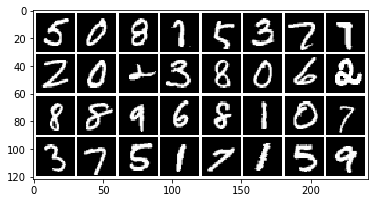

torch.Size([32, 1, 28, 28])


In [4]:
### LOAD DATA ###
dataset = 'mnist'
dataloader, imsize = load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['train']))
plot_grid(sample)
print(sample.shape)
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft**2, -1))

In [5]:
### Test VAE ###

def test_model(model, device, testloader):
    # put model to eval mode
    model.eval()
    model.to(device)
    
    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    test_recon = []
    
    for data in testloader:
        data = data.to(device=device)

        outputs_recon, _, _ = model(data)

        test_images.append(data.cpu().numpy())
        test_recon.append(outputs_recon.detach().cpu().numpy())
    
    return np.concatenate(test_recon), np.concatenate(test_images)

In [6]:
# Define loss

def loss(out_image, in_image, alpha=2.0):
    return torch.mean(torch.abs(out_image - in_image) ** alpha)

def reg(mu, sigma):
    return torch.mean(sigma ** 2 + mu ** 2 - 2 * torch.log(sigma) - 1)

In [7]:
### DEFINE MODEL ###

latent_dim = 128
hidden_dim = 500

vae = models.SignalVAE(shape=imsize, latent_dim=latent_dim, hidden_dim=hidden_dim)

Version 4


In [8]:
# Set training parameters

alpha_loss = 1.0
gamma = 1e-3 # 1e-3

optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [9]:
# Test the network 

sample_recon, sample_mu, sample_sigma = vae(sample)
print(sample_recon.shape)
print("Initial loss: ", loss(out_image=sample_recon, in_image=sample, alpha=alpha_loss).item())
print("Initial reg: ", gamma * reg(mu=sample_mu, sigma=sample_sigma).item())

torch.Size([32, 1, 28, 28])
Initial loss:  0.47308066487312317
Initial reg:  2.556648338213563e-06


In [10]:
def train_model(model, optimizer, device, loader_train, epochs=1):
    """
    Train a model
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - device: The device to perform computation on
    - load_train: The DataLoader object to feed the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Loss history per iteration step
    """
    # move the model parameters to CPU/GPU
    model = model.to(device=device)
    
    history_mse = []
    history = []
    
    for e in range(epochs):

        for t, x in enumerate(loader_train):
            # put model to training mode
            model.train()
            
            # move x to device and reduce to magnitude information in fourier space
            x = x.to(device=device)

            # compute loss as pixel wise distance to original input
            out_recon, out_mu, out_sigma = model(x)
            
            #loss = 
            reg_loss = gamma * reg(mu=out_mu, sigma=out_sigma)
            total_loss = loss(out_image=out_recon, in_image=x, alpha=alpha_loss) + reg_loss
            history.append(total_loss.item())

            # perform backprop and learning step
            optimizer.zero_grad()
            total_loss.backward() 
            optimizer.step()
            
            mse_loss = torch.mean((x - out_recon) ** 2)
            history_mse.append(mse_loss.detach().cpu().item())


            if t % 100 == 0:
                print("epoch: {:2} \t step:{} \t loss: {:3.4} \t reg loss: {:3.4}".format(e+1, t, history[-1], reg_loss))
                
        plt.plot(history[-10000:], label="loss")
        plt.plot(history_mse[-10000:], label="MSE")
        plt.legend()
        plt.show()
                
        test_outputs, test_images = test_model(model, device, dataloader['val'])
        plot_grid(np.vstack([test_images[:16],test_outputs[:16], test_images[16:32], test_outputs[16:32]]), figsize=(8,8))
        
        mse_val = np.mean((test_outputs - test_images)**2)
        print("Mean squared dist:", mse_val)
            
    return history

epoch:  1 	 step:0 	 loss: 0.4724 	 reg loss: 2.466e-06
epoch:  1 	 step:100 	 loss: 0.1268 	 reg loss: 0.0003239
epoch:  1 	 step:200 	 loss: 0.1051 	 reg loss: 0.0005462
epoch:  1 	 step:300 	 loss: 0.1157 	 reg loss: 0.0006231
epoch:  1 	 step:400 	 loss: 0.0969 	 reg loss: 0.0009185
epoch:  1 	 step:500 	 loss: 0.08348 	 reg loss: 0.001152
epoch:  1 	 step:600 	 loss: 0.08373 	 reg loss: 0.001462
epoch:  1 	 step:700 	 loss: 0.08292 	 reg loss: 0.001555
epoch:  1 	 step:800 	 loss: 0.07524 	 reg loss: 0.001522
epoch:  1 	 step:900 	 loss: 0.06993 	 reg loss: 0.001475
epoch:  1 	 step:1000 	 loss: 0.06654 	 reg loss: 0.001831
epoch:  1 	 step:1100 	 loss: 0.07243 	 reg loss: 0.001901
epoch:  1 	 step:1200 	 loss: 0.05985 	 reg loss: 0.001845
epoch:  1 	 step:1300 	 loss: 0.06776 	 reg loss: 0.001986
epoch:  1 	 step:1400 	 loss: 0.06047 	 reg loss: 0.002012
epoch:  1 	 step:1500 	 loss: 0.05793 	 reg loss: 0.00216
epoch:  1 	 step:1600 	 loss: 0.0614 	 reg loss: 0.001898
epoch:  1 	

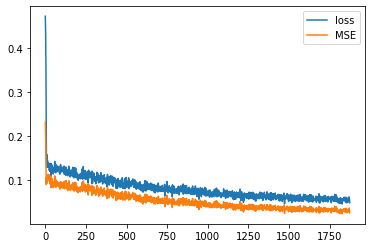

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


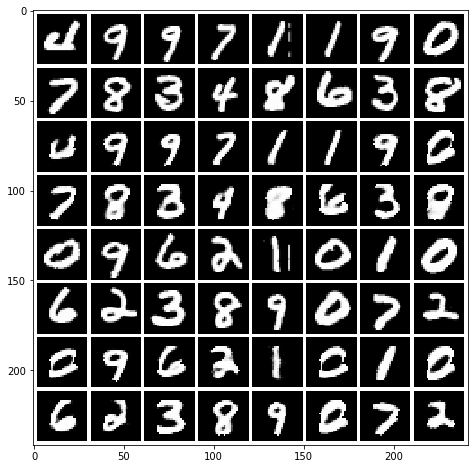

Mean squared dist: 0.03124331
epoch:  2 	 step:0 	 loss: 0.05202 	 reg loss: 0.002203
epoch:  2 	 step:100 	 loss: 0.05473 	 reg loss: 0.002064
epoch:  2 	 step:200 	 loss: 0.05483 	 reg loss: 0.002059
epoch:  2 	 step:300 	 loss: 0.04803 	 reg loss: 0.002137
epoch:  2 	 step:400 	 loss: 0.05257 	 reg loss: 0.002297
epoch:  2 	 step:500 	 loss: 0.05206 	 reg loss: 0.002408
epoch:  2 	 step:600 	 loss: 0.05115 	 reg loss: 0.00215
epoch:  2 	 step:700 	 loss: 0.0535 	 reg loss: 0.002358
epoch:  2 	 step:800 	 loss: 0.0465 	 reg loss: 0.002208
epoch:  2 	 step:900 	 loss: 0.04976 	 reg loss: 0.002124
epoch:  2 	 step:1000 	 loss: 0.05155 	 reg loss: 0.002288
epoch:  2 	 step:1100 	 loss: 0.05559 	 reg loss: 0.00225
epoch:  2 	 step:1200 	 loss: 0.04482 	 reg loss: 0.002274
epoch:  2 	 step:1300 	 loss: 0.04864 	 reg loss: 0.002248
epoch:  2 	 step:1400 	 loss: 0.04032 	 reg loss: 0.002202
epoch:  2 	 step:1500 	 loss: 0.0516 	 reg loss: 0.002423
epoch:  2 	 step:1600 	 loss: 0.04517 	 reg

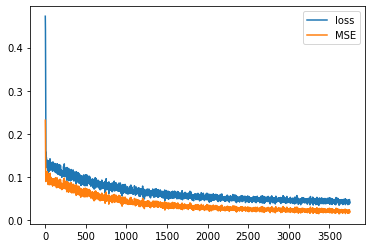

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


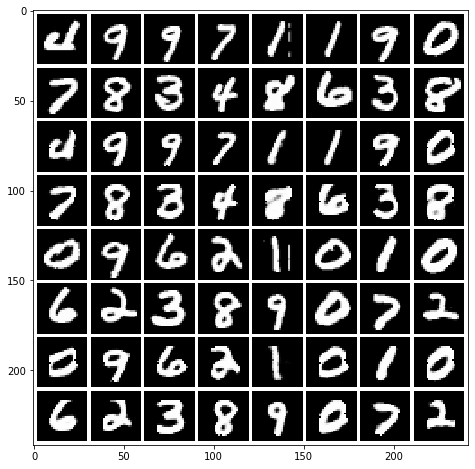

Mean squared dist: 0.022541735
epoch:  3 	 step:0 	 loss: 0.04844 	 reg loss: 0.00223
epoch:  3 	 step:100 	 loss: 0.04735 	 reg loss: 0.002277
epoch:  3 	 step:200 	 loss: 0.04341 	 reg loss: 0.002114
epoch:  3 	 step:300 	 loss: 0.04114 	 reg loss: 0.00207
epoch:  3 	 step:400 	 loss: 0.046 	 reg loss: 0.002313
epoch:  3 	 step:500 	 loss: 0.04321 	 reg loss: 0.00218
epoch:  3 	 step:600 	 loss: 0.04121 	 reg loss: 0.002281
epoch:  3 	 step:700 	 loss: 0.04202 	 reg loss: 0.002273
epoch:  3 	 step:800 	 loss: 0.04038 	 reg loss: 0.002122
epoch:  3 	 step:900 	 loss: 0.03838 	 reg loss: 0.002226
epoch:  3 	 step:1000 	 loss: 0.03999 	 reg loss: 0.002211
epoch:  3 	 step:1100 	 loss: 0.03848 	 reg loss: 0.002211
epoch:  3 	 step:1200 	 loss: 0.04049 	 reg loss: 0.002161
epoch:  3 	 step:1300 	 loss: 0.04543 	 reg loss: 0.00221
epoch:  3 	 step:1400 	 loss: 0.03931 	 reg loss: 0.002097
epoch:  3 	 step:1500 	 loss: 0.0388 	 reg loss: 0.002254
epoch:  3 	 step:1600 	 loss: 0.03808 	 reg 

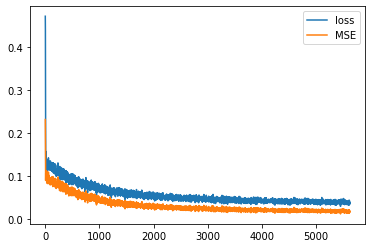

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


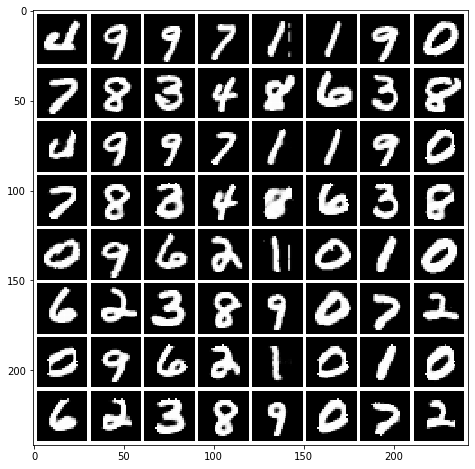

Mean squared dist: 0.019225659
epoch:  4 	 step:0 	 loss: 0.03366 	 reg loss: 0.002176
epoch:  4 	 step:100 	 loss: 0.03961 	 reg loss: 0.002144
epoch:  4 	 step:200 	 loss: 0.04241 	 reg loss: 0.002203
epoch:  4 	 step:300 	 loss: 0.03609 	 reg loss: 0.002209
epoch:  4 	 step:400 	 loss: 0.03873 	 reg loss: 0.00213
epoch:  4 	 step:500 	 loss: 0.03944 	 reg loss: 0.002136
epoch:  4 	 step:600 	 loss: 0.03877 	 reg loss: 0.002153
epoch:  4 	 step:700 	 loss: 0.03444 	 reg loss: 0.002161
epoch:  4 	 step:800 	 loss: 0.03484 	 reg loss: 0.002162
epoch:  4 	 step:900 	 loss: 0.0416 	 reg loss: 0.002192
epoch:  4 	 step:1000 	 loss: 0.03377 	 reg loss: 0.002158
epoch:  4 	 step:1100 	 loss: 0.04042 	 reg loss: 0.002129
epoch:  4 	 step:1200 	 loss: 0.03899 	 reg loss: 0.002163
epoch:  4 	 step:1300 	 loss: 0.03966 	 reg loss: 0.002096
epoch:  4 	 step:1400 	 loss: 0.04 	 reg loss: 0.002177
epoch:  4 	 step:1500 	 loss: 0.03647 	 reg loss: 0.002041
epoch:  4 	 step:1600 	 loss: 0.0381 	 reg

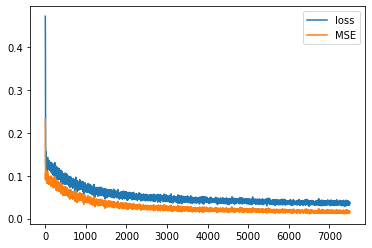

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


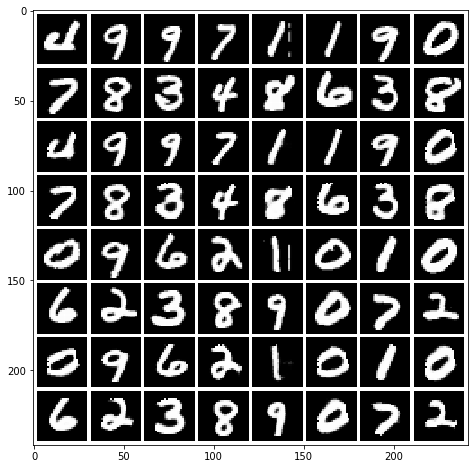

Mean squared dist: 0.016330963
epoch:  5 	 step:0 	 loss: 0.03882 	 reg loss: 0.002117
epoch:  5 	 step:100 	 loss: 0.03559 	 reg loss: 0.002103
epoch:  5 	 step:200 	 loss: 0.03394 	 reg loss: 0.002004
epoch:  5 	 step:300 	 loss: 0.03204 	 reg loss: 0.002061
epoch:  5 	 step:400 	 loss: 0.03899 	 reg loss: 0.002098
epoch:  5 	 step:500 	 loss: 0.03256 	 reg loss: 0.002094
epoch:  5 	 step:600 	 loss: 0.03584 	 reg loss: 0.001987
epoch:  5 	 step:700 	 loss: 0.03225 	 reg loss: 0.002041
epoch:  5 	 step:800 	 loss: 0.03623 	 reg loss: 0.002071
epoch:  5 	 step:900 	 loss: 0.03431 	 reg loss: 0.002113
epoch:  5 	 step:1000 	 loss: 0.0333 	 reg loss: 0.002045
epoch:  5 	 step:1100 	 loss: 0.03578 	 reg loss: 0.002007
epoch:  5 	 step:1200 	 loss: 0.03804 	 reg loss: 0.002175
epoch:  5 	 step:1300 	 loss: 0.03371 	 reg loss: 0.001975
epoch:  5 	 step:1400 	 loss: 0.03569 	 reg loss: 0.002017
epoch:  5 	 step:1500 	 loss: 0.03448 	 reg loss: 0.00207
epoch:  5 	 step:1600 	 loss: 0.03665 	

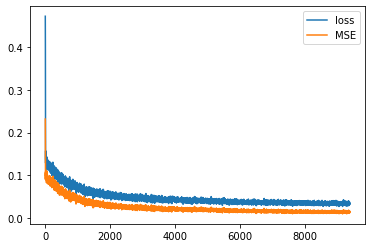

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


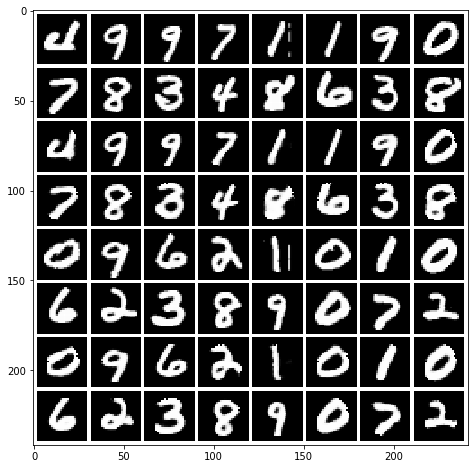

Mean squared dist: 0.015101557
epoch:  6 	 step:0 	 loss: 0.03306 	 reg loss: 0.001993
epoch:  6 	 step:100 	 loss: 0.0322 	 reg loss: 0.002017
epoch:  6 	 step:200 	 loss: 0.03421 	 reg loss: 0.002059
epoch:  6 	 step:300 	 loss: 0.02985 	 reg loss: 0.002009
epoch:  6 	 step:400 	 loss: 0.03906 	 reg loss: 0.002108
epoch:  6 	 step:500 	 loss: 0.03179 	 reg loss: 0.001966
epoch:  6 	 step:600 	 loss: 0.03578 	 reg loss: 0.00205
epoch:  6 	 step:700 	 loss: 0.03075 	 reg loss: 0.001962
epoch:  6 	 step:800 	 loss: 0.02995 	 reg loss: 0.001974
epoch:  6 	 step:900 	 loss: 0.0325 	 reg loss: 0.001949
epoch:  6 	 step:1000 	 loss: 0.03071 	 reg loss: 0.001963
epoch:  6 	 step:1100 	 loss: 0.03639 	 reg loss: 0.002081
epoch:  6 	 step:1200 	 loss: 0.0328 	 reg loss: 0.002001
epoch:  6 	 step:1300 	 loss: 0.0318 	 reg loss: 0.001936
epoch:  6 	 step:1400 	 loss: 0.03174 	 reg loss: 0.001987
epoch:  6 	 step:1500 	 loss: 0.03455 	 reg loss: 0.001998
epoch:  6 	 step:1600 	 loss: 0.03741 	 re

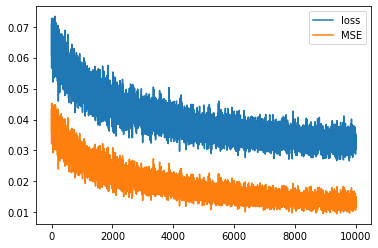

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


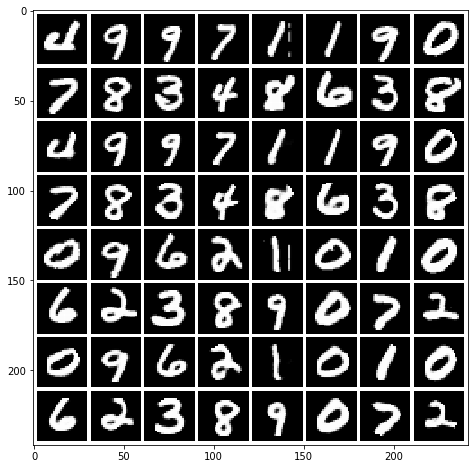

Mean squared dist: 0.014247901
epoch:  7 	 step:0 	 loss: 0.02954 	 reg loss: 0.001978
epoch:  7 	 step:100 	 loss: 0.03351 	 reg loss: 0.002009
epoch:  7 	 step:200 	 loss: 0.03241 	 reg loss: 0.001942
epoch:  7 	 step:300 	 loss: 0.0328 	 reg loss: 0.001903
epoch:  7 	 step:400 	 loss: 0.03075 	 reg loss: 0.001888
epoch:  7 	 step:500 	 loss: 0.03778 	 reg loss: 0.002022
epoch:  7 	 step:600 	 loss: 0.03232 	 reg loss: 0.001983
epoch:  7 	 step:700 	 loss: 0.03472 	 reg loss: 0.00198
epoch:  7 	 step:800 	 loss: 0.03125 	 reg loss: 0.001867
epoch:  7 	 step:900 	 loss: 0.03162 	 reg loss: 0.001889
epoch:  7 	 step:1000 	 loss: 0.03137 	 reg loss: 0.001958
epoch:  7 	 step:1100 	 loss: 0.03238 	 reg loss: 0.001951
epoch:  7 	 step:1200 	 loss: 0.03726 	 reg loss: 0.002025
epoch:  7 	 step:1300 	 loss: 0.032 	 reg loss: 0.001956
epoch:  7 	 step:1400 	 loss: 0.03492 	 reg loss: 0.002013
epoch:  7 	 step:1500 	 loss: 0.03572 	 reg loss: 0.002017
epoch:  7 	 step:1600 	 loss: 0.02869 	 r

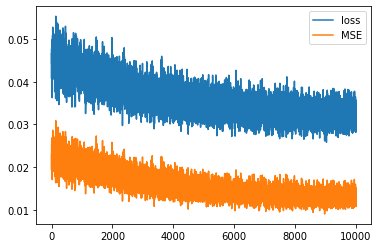

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


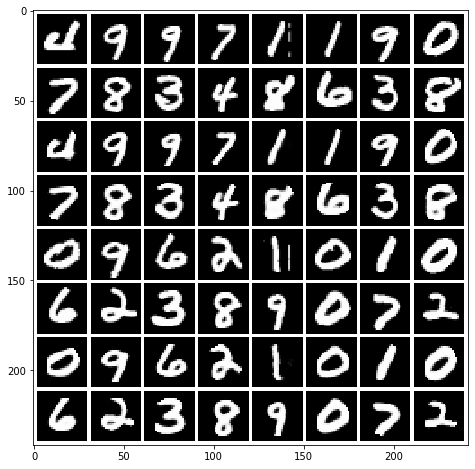

Mean squared dist: 0.013748947
epoch:  8 	 step:0 	 loss: 0.03135 	 reg loss: 0.001973
epoch:  8 	 step:100 	 loss: 0.03191 	 reg loss: 0.001981
epoch:  8 	 step:200 	 loss: 0.02656 	 reg loss: 0.00187
epoch:  8 	 step:300 	 loss: 0.03232 	 reg loss: 0.001934
epoch:  8 	 step:400 	 loss: 0.03323 	 reg loss: 0.001972
epoch:  8 	 step:500 	 loss: 0.03289 	 reg loss: 0.001935
epoch:  8 	 step:600 	 loss: 0.03236 	 reg loss: 0.001922
epoch:  8 	 step:700 	 loss: 0.03053 	 reg loss: 0.001933
epoch:  8 	 step:800 	 loss: 0.03382 	 reg loss: 0.001836
epoch:  8 	 step:900 	 loss: 0.03135 	 reg loss: 0.001899
epoch:  8 	 step:1000 	 loss: 0.02833 	 reg loss: 0.001877
epoch:  8 	 step:1100 	 loss: 0.03082 	 reg loss: 0.001892
epoch:  8 	 step:1200 	 loss: 0.02812 	 reg loss: 0.001885
epoch:  8 	 step:1300 	 loss: 0.03257 	 reg loss: 0.001948
epoch:  8 	 step:1400 	 loss: 0.03082 	 reg loss: 0.001935
epoch:  8 	 step:1500 	 loss: 0.03201 	 reg loss: 0.002006
epoch:  8 	 step:1600 	 loss: 0.03035 

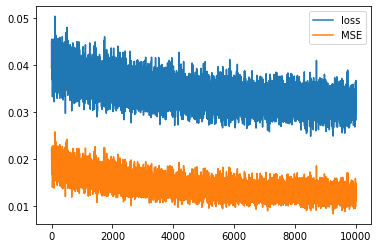

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


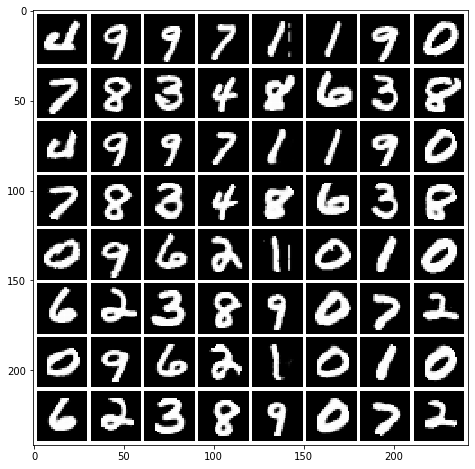

Mean squared dist: 0.013385261
epoch:  9 	 step:0 	 loss: 0.02847 	 reg loss: 0.00184
epoch:  9 	 step:100 	 loss: 0.03353 	 reg loss: 0.001976
epoch:  9 	 step:200 	 loss: 0.03122 	 reg loss: 0.001896
epoch:  9 	 step:300 	 loss: 0.03032 	 reg loss: 0.001979
epoch:  9 	 step:400 	 loss: 0.03173 	 reg loss: 0.001944
epoch:  9 	 step:500 	 loss: 0.0321 	 reg loss: 0.001899
epoch:  9 	 step:600 	 loss: 0.03316 	 reg loss: 0.001972
epoch:  9 	 step:700 	 loss: 0.02824 	 reg loss: 0.00188
epoch:  9 	 step:800 	 loss: 0.03064 	 reg loss: 0.001938
epoch:  9 	 step:900 	 loss: 0.03157 	 reg loss: 0.001916
epoch:  9 	 step:1000 	 loss: 0.02792 	 reg loss: 0.001905
epoch:  9 	 step:1100 	 loss: 0.0254 	 reg loss: 0.001734
epoch:  9 	 step:1200 	 loss: 0.02952 	 reg loss: 0.001956
epoch:  9 	 step:1300 	 loss: 0.03014 	 reg loss: 0.001843
epoch:  9 	 step:1400 	 loss: 0.03373 	 reg loss: 0.001998
epoch:  9 	 step:1500 	 loss: 0.02559 	 reg loss: 0.001818
epoch:  9 	 step:1600 	 loss: 0.02831 	 r

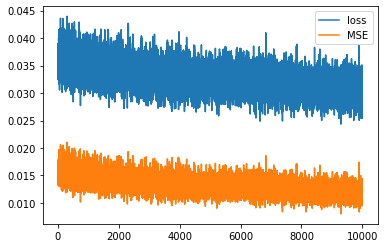

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


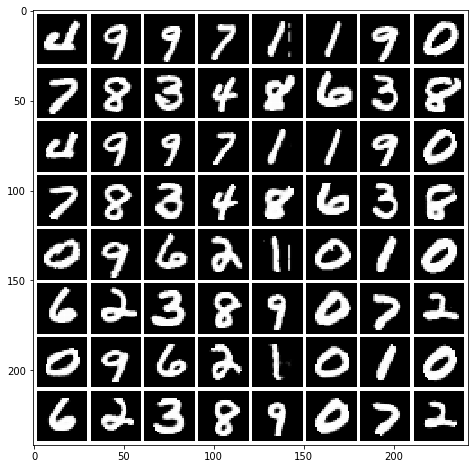

Mean squared dist: 0.012574544
epoch: 10 	 step:0 	 loss: 0.02993 	 reg loss: 0.001916
epoch: 10 	 step:100 	 loss: 0.03237 	 reg loss: 0.001951
epoch: 10 	 step:200 	 loss: 0.02715 	 reg loss: 0.001884
epoch: 10 	 step:300 	 loss: 0.03109 	 reg loss: 0.001925
epoch: 10 	 step:400 	 loss: 0.02837 	 reg loss: 0.001863
epoch: 10 	 step:500 	 loss: 0.03038 	 reg loss: 0.001897
epoch: 10 	 step:600 	 loss: 0.02822 	 reg loss: 0.001901
epoch: 10 	 step:700 	 loss: 0.03326 	 reg loss: 0.001909
epoch: 10 	 step:800 	 loss: 0.03295 	 reg loss: 0.001973
epoch: 10 	 step:900 	 loss: 0.02916 	 reg loss: 0.001859
epoch: 10 	 step:1000 	 loss: 0.03022 	 reg loss: 0.001962
epoch: 10 	 step:1100 	 loss: 0.02965 	 reg loss: 0.001944
epoch: 10 	 step:1200 	 loss: 0.03056 	 reg loss: 0.001894
epoch: 10 	 step:1300 	 loss: 0.03454 	 reg loss: 0.001894
epoch: 10 	 step:1400 	 loss: 0.0335 	 reg loss: 0.00197
epoch: 10 	 step:1500 	 loss: 0.03256 	 reg loss: 0.001947
epoch: 10 	 step:1600 	 loss: 0.03112 	

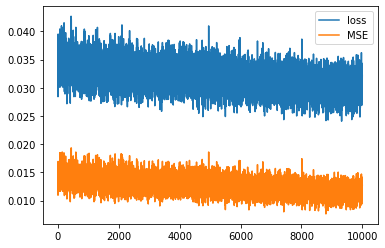

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


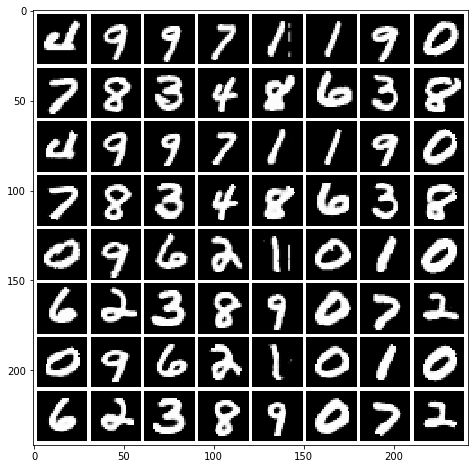

Mean squared dist: 0.012182947
epoch: 11 	 step:0 	 loss: 0.02934 	 reg loss: 0.001846
epoch: 11 	 step:100 	 loss: 0.03169 	 reg loss: 0.001883
epoch: 11 	 step:200 	 loss: 0.0298 	 reg loss: 0.001894
epoch: 11 	 step:300 	 loss: 0.02601 	 reg loss: 0.001846
epoch: 11 	 step:400 	 loss: 0.02818 	 reg loss: 0.001839
epoch: 11 	 step:500 	 loss: 0.02705 	 reg loss: 0.001828
epoch: 11 	 step:600 	 loss: 0.03467 	 reg loss: 0.001927
epoch: 11 	 step:700 	 loss: 0.02965 	 reg loss: 0.001784
epoch: 11 	 step:800 	 loss: 0.02797 	 reg loss: 0.001744
epoch: 11 	 step:900 	 loss: 0.02993 	 reg loss: 0.001811
epoch: 11 	 step:1000 	 loss: 0.03004 	 reg loss: 0.001831
epoch: 11 	 step:1100 	 loss: 0.03097 	 reg loss: 0.001861
epoch: 11 	 step:1200 	 loss: 0.02999 	 reg loss: 0.001917
epoch: 11 	 step:1300 	 loss: 0.02931 	 reg loss: 0.001879
epoch: 11 	 step:1400 	 loss: 0.02869 	 reg loss: 0.001867
epoch: 11 	 step:1500 	 loss: 0.03001 	 reg loss: 0.00191
epoch: 11 	 step:1600 	 loss: 0.02742 	

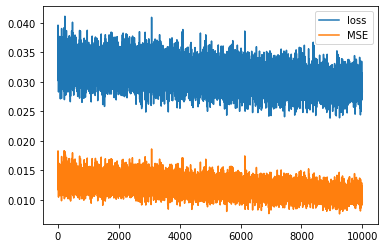

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


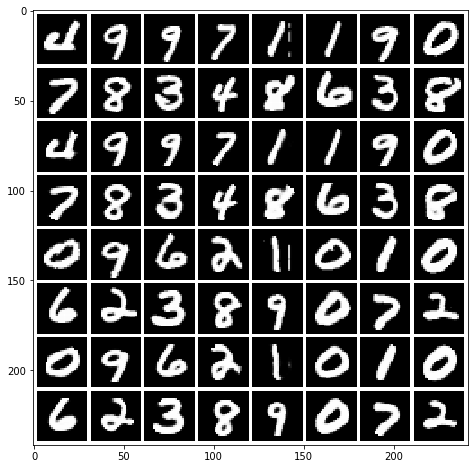

Mean squared dist: 0.0115406355
epoch: 12 	 step:0 	 loss: 0.03065 	 reg loss: 0.001899
epoch: 12 	 step:100 	 loss: 0.02906 	 reg loss: 0.001839
epoch: 12 	 step:200 	 loss: 0.03325 	 reg loss: 0.001872
epoch: 12 	 step:300 	 loss: 0.03055 	 reg loss: 0.001759
epoch: 12 	 step:400 	 loss: 0.02901 	 reg loss: 0.001837
epoch: 12 	 step:500 	 loss: 0.03225 	 reg loss: 0.001853
epoch: 12 	 step:600 	 loss: 0.03006 	 reg loss: 0.00186
epoch: 12 	 step:700 	 loss: 0.03039 	 reg loss: 0.001815
epoch: 12 	 step:800 	 loss: 0.02676 	 reg loss: 0.00181
epoch: 12 	 step:900 	 loss: 0.02676 	 reg loss: 0.001783
epoch: 12 	 step:1000 	 loss: 0.0275 	 reg loss: 0.001834
epoch: 12 	 step:1100 	 loss: 0.02905 	 reg loss: 0.001835
epoch: 12 	 step:1200 	 loss: 0.02944 	 reg loss: 0.001798
epoch: 12 	 step:1300 	 loss: 0.02871 	 reg loss: 0.001815
epoch: 12 	 step:1400 	 loss: 0.0285 	 reg loss: 0.001802
epoch: 12 	 step:1500 	 loss: 0.02778 	 reg loss: 0.001888
epoch: 12 	 step:1600 	 loss: 0.02847 	 

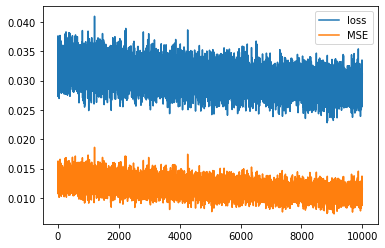

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


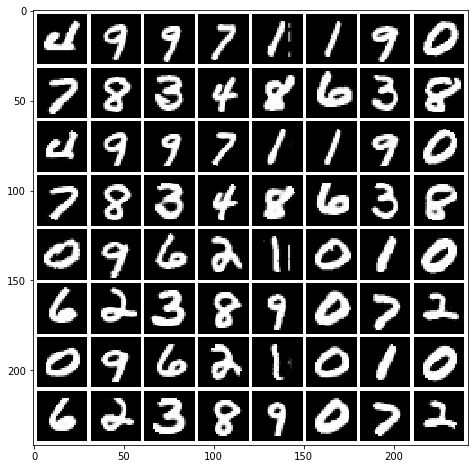

Mean squared dist: 0.011131241
epoch: 13 	 step:0 	 loss: 0.02631 	 reg loss: 0.001803
epoch: 13 	 step:100 	 loss: 0.0269 	 reg loss: 0.001846
epoch: 13 	 step:200 	 loss: 0.02704 	 reg loss: 0.001851
epoch: 13 	 step:300 	 loss: 0.02538 	 reg loss: 0.001789
epoch: 13 	 step:400 	 loss: 0.02868 	 reg loss: 0.001736
epoch: 13 	 step:500 	 loss: 0.03021 	 reg loss: 0.001833
epoch: 13 	 step:600 	 loss: 0.02989 	 reg loss: 0.001824
epoch: 13 	 step:700 	 loss: 0.03045 	 reg loss: 0.001869
epoch: 13 	 step:800 	 loss: 0.02761 	 reg loss: 0.001758
epoch: 13 	 step:900 	 loss: 0.02813 	 reg loss: 0.001812
epoch: 13 	 step:1000 	 loss: 0.02937 	 reg loss: 0.001874
epoch: 13 	 step:1100 	 loss: 0.02632 	 reg loss: 0.001698
epoch: 13 	 step:1200 	 loss: 0.027 	 reg loss: 0.001785
epoch: 13 	 step:1300 	 loss: 0.02541 	 reg loss: 0.001796
epoch: 13 	 step:1400 	 loss: 0.03062 	 reg loss: 0.001854
epoch: 13 	 step:1500 	 loss: 0.031 	 reg loss: 0.0019
epoch: 13 	 step:1600 	 loss: 0.0281 	 reg l

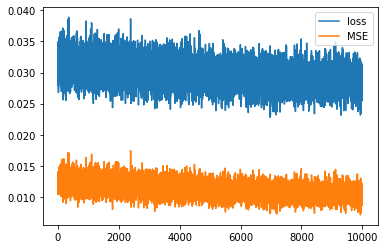

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


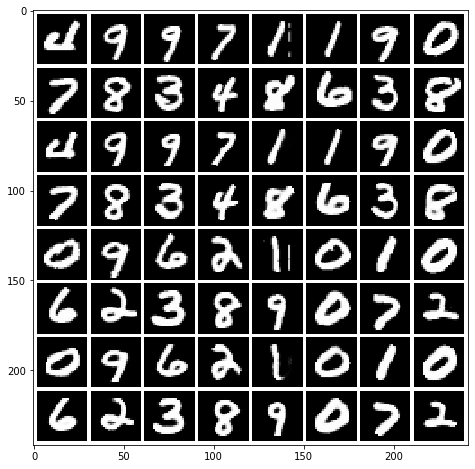

Mean squared dist: 0.010867325
epoch: 14 	 step:0 	 loss: 0.02688 	 reg loss: 0.001787
epoch: 14 	 step:100 	 loss: 0.03045 	 reg loss: 0.001836
epoch: 14 	 step:200 	 loss: 0.02908 	 reg loss: 0.001807
epoch: 14 	 step:300 	 loss: 0.02993 	 reg loss: 0.00188
epoch: 14 	 step:400 	 loss: 0.03012 	 reg loss: 0.001823
epoch: 14 	 step:500 	 loss: 0.02976 	 reg loss: 0.001848
epoch: 14 	 step:600 	 loss: 0.02644 	 reg loss: 0.001761
epoch: 14 	 step:700 	 loss: 0.02835 	 reg loss: 0.001797
epoch: 14 	 step:800 	 loss: 0.02688 	 reg loss: 0.00176
epoch: 14 	 step:900 	 loss: 0.02871 	 reg loss: 0.001807
epoch: 14 	 step:1000 	 loss: 0.02874 	 reg loss: 0.001802
epoch: 14 	 step:1100 	 loss: 0.02786 	 reg loss: 0.001773
epoch: 14 	 step:1200 	 loss: 0.0296 	 reg loss: 0.001737
epoch: 14 	 step:1300 	 loss: 0.03082 	 reg loss: 0.001923
epoch: 14 	 step:1400 	 loss: 0.03098 	 reg loss: 0.001803
epoch: 14 	 step:1500 	 loss: 0.02925 	 reg loss: 0.001737
epoch: 14 	 step:1600 	 loss: 0.02788 	 

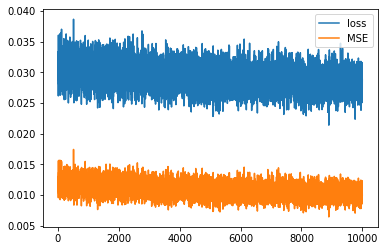

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


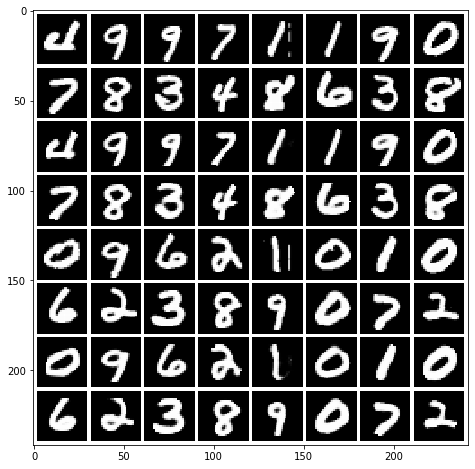

Mean squared dist: 0.010689903
epoch: 15 	 step:0 	 loss: 0.02815 	 reg loss: 0.001847
epoch: 15 	 step:100 	 loss: 0.02768 	 reg loss: 0.001855
epoch: 15 	 step:200 	 loss: 0.03068 	 reg loss: 0.001875
epoch: 15 	 step:300 	 loss: 0.03004 	 reg loss: 0.001822
epoch: 15 	 step:400 	 loss: 0.02522 	 reg loss: 0.001738
epoch: 15 	 step:500 	 loss: 0.02786 	 reg loss: 0.001793
epoch: 15 	 step:600 	 loss: 0.02786 	 reg loss: 0.001795
epoch: 15 	 step:700 	 loss: 0.02477 	 reg loss: 0.001793
epoch: 15 	 step:800 	 loss: 0.03045 	 reg loss: 0.001815
epoch: 15 	 step:900 	 loss: 0.02884 	 reg loss: 0.001831
epoch: 15 	 step:1000 	 loss: 0.02836 	 reg loss: 0.001848
epoch: 15 	 step:1100 	 loss: 0.02936 	 reg loss: 0.001817
epoch: 15 	 step:1200 	 loss: 0.0295 	 reg loss: 0.001861
epoch: 15 	 step:1300 	 loss: 0.02731 	 reg loss: 0.001784
epoch: 15 	 step:1400 	 loss: 0.02988 	 reg loss: 0.001817
epoch: 15 	 step:1500 	 loss: 0.02982 	 reg loss: 0.00187
epoch: 15 	 step:1600 	 loss: 0.02617 	

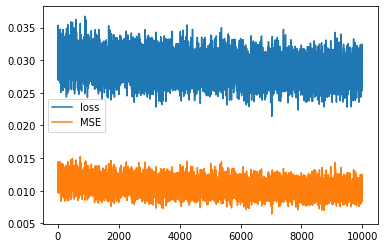

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


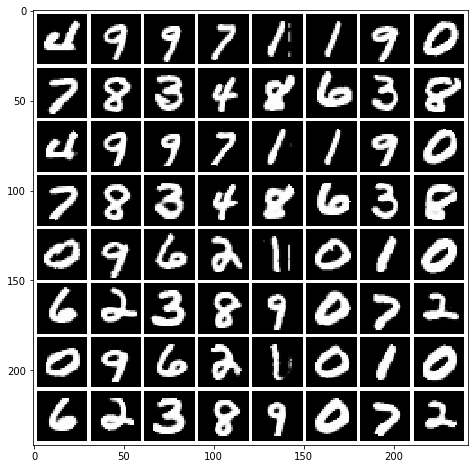

Mean squared dist: 0.010446268
epoch: 16 	 step:0 	 loss: 0.02877 	 reg loss: 0.001878
epoch: 16 	 step:100 	 loss: 0.02699 	 reg loss: 0.001833
epoch: 16 	 step:200 	 loss: 0.02847 	 reg loss: 0.001834
epoch: 16 	 step:300 	 loss: 0.02673 	 reg loss: 0.001842
epoch: 16 	 step:400 	 loss: 0.02602 	 reg loss: 0.001741
epoch: 16 	 step:500 	 loss: 0.02749 	 reg loss: 0.001809
epoch: 16 	 step:600 	 loss: 0.02876 	 reg loss: 0.001856
epoch: 16 	 step:700 	 loss: 0.03031 	 reg loss: 0.001881
epoch: 16 	 step:800 	 loss: 0.02677 	 reg loss: 0.001788
epoch: 16 	 step:900 	 loss: 0.03011 	 reg loss: 0.001885
epoch: 16 	 step:1000 	 loss: 0.02653 	 reg loss: 0.001847
epoch: 16 	 step:1100 	 loss: 0.02797 	 reg loss: 0.001849
epoch: 16 	 step:1200 	 loss: 0.02806 	 reg loss: 0.001794
epoch: 16 	 step:1300 	 loss: 0.02685 	 reg loss: 0.001846
epoch: 16 	 step:1400 	 loss: 0.02551 	 reg loss: 0.001801
epoch: 16 	 step:1500 	 loss: 0.02841 	 reg loss: 0.001793
epoch: 16 	 step:1600 	 loss: 0.02891

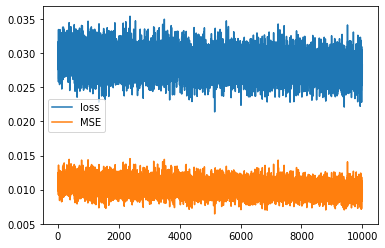

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


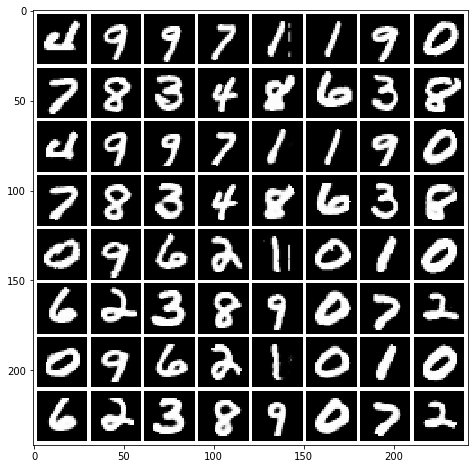

Mean squared dist: 0.010339711
epoch: 17 	 step:0 	 loss: 0.02709 	 reg loss: 0.001779
epoch: 17 	 step:100 	 loss: 0.0255 	 reg loss: 0.001728
epoch: 17 	 step:200 	 loss: 0.03031 	 reg loss: 0.00183
epoch: 17 	 step:300 	 loss: 0.02732 	 reg loss: 0.001803
epoch: 17 	 step:400 	 loss: 0.02848 	 reg loss: 0.001834
epoch: 17 	 step:500 	 loss: 0.02541 	 reg loss: 0.001701
epoch: 17 	 step:600 	 loss: 0.0302 	 reg loss: 0.00189
epoch: 17 	 step:700 	 loss: 0.02715 	 reg loss: 0.00182
epoch: 17 	 step:800 	 loss: 0.02566 	 reg loss: 0.001816
epoch: 17 	 step:900 	 loss: 0.02646 	 reg loss: 0.001848
epoch: 17 	 step:1000 	 loss: 0.02813 	 reg loss: 0.001769
epoch: 17 	 step:1100 	 loss: 0.02759 	 reg loss: 0.001742
epoch: 17 	 step:1200 	 loss: 0.02877 	 reg loss: 0.001798
epoch: 17 	 step:1300 	 loss: 0.02663 	 reg loss: 0.001791
epoch: 17 	 step:1400 	 loss: 0.02565 	 reg loss: 0.001769
epoch: 17 	 step:1500 	 loss: 0.02747 	 reg loss: 0.001805
epoch: 17 	 step:1600 	 loss: 0.02592 	 re

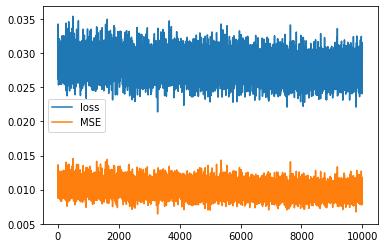

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


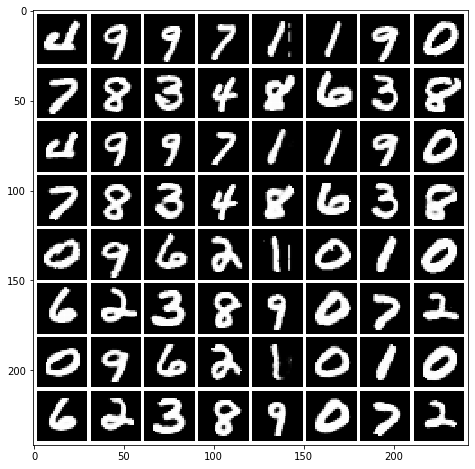

Mean squared dist: 0.010320259
epoch: 18 	 step:0 	 loss: 0.02606 	 reg loss: 0.001776
epoch: 18 	 step:100 	 loss: 0.02795 	 reg loss: 0.001783
epoch: 18 	 step:200 	 loss: 0.0273 	 reg loss: 0.001835
epoch: 18 	 step:300 	 loss: 0.02818 	 reg loss: 0.001776
epoch: 18 	 step:400 	 loss: 0.02409 	 reg loss: 0.001733
epoch: 18 	 step:500 	 loss: 0.02769 	 reg loss: 0.001727
epoch: 18 	 step:600 	 loss: 0.02394 	 reg loss: 0.001729
epoch: 18 	 step:700 	 loss: 0.02408 	 reg loss: 0.001818
epoch: 18 	 step:800 	 loss: 0.02514 	 reg loss: 0.001795
epoch: 18 	 step:900 	 loss: 0.02762 	 reg loss: 0.001829
epoch: 18 	 step:1000 	 loss: 0.02406 	 reg loss: 0.001841
epoch: 18 	 step:1100 	 loss: 0.02977 	 reg loss: 0.001843
epoch: 18 	 step:1200 	 loss: 0.02626 	 reg loss: 0.001815
epoch: 18 	 step:1300 	 loss: 0.02639 	 reg loss: 0.001741
epoch: 18 	 step:1400 	 loss: 0.02441 	 reg loss: 0.001761
epoch: 18 	 step:1500 	 loss: 0.02638 	 reg loss: 0.00178
epoch: 18 	 step:1600 	 loss: 0.0258 	 

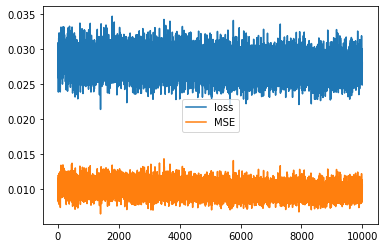

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


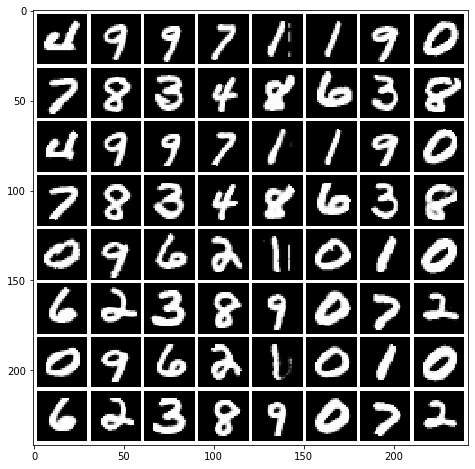

Mean squared dist: 0.010073285
epoch: 19 	 step:0 	 loss: 0.02895 	 reg loss: 0.001791
epoch: 19 	 step:100 	 loss: 0.02928 	 reg loss: 0.001836
epoch: 19 	 step:200 	 loss: 0.02635 	 reg loss: 0.001761
epoch: 19 	 step:300 	 loss: 0.02834 	 reg loss: 0.001825
epoch: 19 	 step:400 	 loss: 0.02801 	 reg loss: 0.001805
epoch: 19 	 step:500 	 loss: 0.0261 	 reg loss: 0.001781
epoch: 19 	 step:600 	 loss: 0.0257 	 reg loss: 0.001759
epoch: 19 	 step:700 	 loss: 0.02868 	 reg loss: 0.001825
epoch: 19 	 step:800 	 loss: 0.02493 	 reg loss: 0.001739
epoch: 19 	 step:900 	 loss: 0.02781 	 reg loss: 0.001795
epoch: 19 	 step:1000 	 loss: 0.02778 	 reg loss: 0.001779
epoch: 19 	 step:1100 	 loss: 0.03071 	 reg loss: 0.001851
epoch: 19 	 step:1200 	 loss: 0.02563 	 reg loss: 0.001823
epoch: 19 	 step:1300 	 loss: 0.02734 	 reg loss: 0.00184
epoch: 19 	 step:1400 	 loss: 0.02743 	 reg loss: 0.0018
epoch: 19 	 step:1500 	 loss: 0.02844 	 reg loss: 0.001847
epoch: 19 	 step:1600 	 loss: 0.02539 	 re

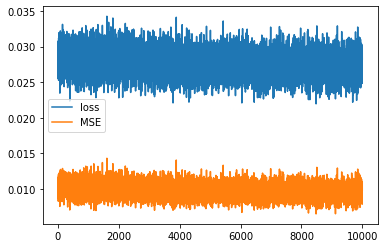

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


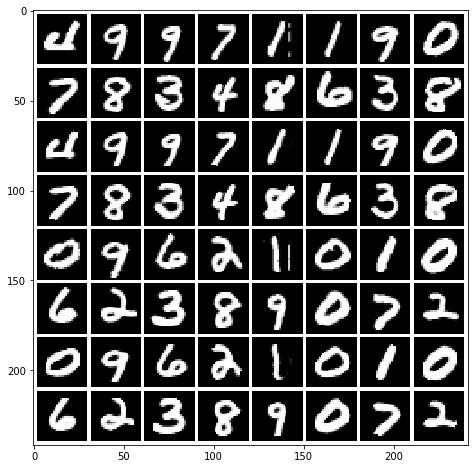

Mean squared dist: 0.009893678
epoch: 20 	 step:0 	 loss: 0.028 	 reg loss: 0.001821
epoch: 20 	 step:100 	 loss: 0.0264 	 reg loss: 0.001825
epoch: 20 	 step:200 	 loss: 0.02592 	 reg loss: 0.001816
epoch: 20 	 step:300 	 loss: 0.02553 	 reg loss: 0.001727
epoch: 20 	 step:400 	 loss: 0.02574 	 reg loss: 0.001805
epoch: 20 	 step:500 	 loss: 0.02865 	 reg loss: 0.001878
epoch: 20 	 step:600 	 loss: 0.02398 	 reg loss: 0.001761
epoch: 20 	 step:700 	 loss: 0.029 	 reg loss: 0.001864
epoch: 20 	 step:800 	 loss: 0.02627 	 reg loss: 0.001807
epoch: 20 	 step:900 	 loss: 0.02738 	 reg loss: 0.001866
epoch: 20 	 step:1000 	 loss: 0.02676 	 reg loss: 0.001757
epoch: 20 	 step:1100 	 loss: 0.02591 	 reg loss: 0.001836
epoch: 20 	 step:1200 	 loss: 0.02618 	 reg loss: 0.00184
epoch: 20 	 step:1300 	 loss: 0.02694 	 reg loss: 0.001866
epoch: 20 	 step:1400 	 loss: 0.02545 	 reg loss: 0.0018
epoch: 20 	 step:1500 	 loss: 0.0259 	 reg loss: 0.001769
epoch: 20 	 step:1600 	 loss: 0.02731 	 reg lo

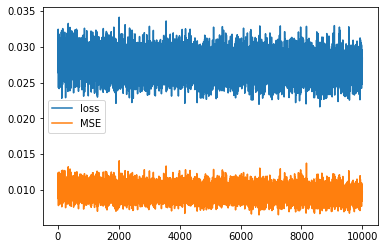

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


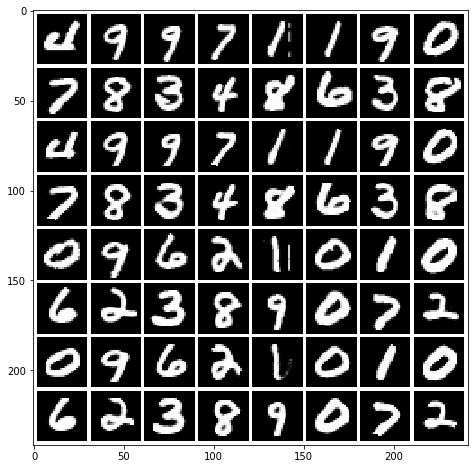

Mean squared dist: 0.009767709
epoch: 21 	 step:0 	 loss: 0.02698 	 reg loss: 0.001805
epoch: 21 	 step:100 	 loss: 0.0241 	 reg loss: 0.001716
epoch: 21 	 step:200 	 loss: 0.02611 	 reg loss: 0.001757
epoch: 21 	 step:300 	 loss: 0.02649 	 reg loss: 0.00181
epoch: 21 	 step:400 	 loss: 0.0268 	 reg loss: 0.001799
epoch: 21 	 step:500 	 loss: 0.02782 	 reg loss: 0.001789
epoch: 21 	 step:600 	 loss: 0.02722 	 reg loss: 0.001799
epoch: 21 	 step:700 	 loss: 0.02628 	 reg loss: 0.001778
epoch: 21 	 step:800 	 loss: 0.02679 	 reg loss: 0.001857
epoch: 21 	 step:900 	 loss: 0.02601 	 reg loss: 0.001828
epoch: 21 	 step:1000 	 loss: 0.02454 	 reg loss: 0.001871
epoch: 21 	 step:1100 	 loss: 0.02437 	 reg loss: 0.001759
epoch: 21 	 step:1200 	 loss: 0.02581 	 reg loss: 0.001772
epoch: 21 	 step:1300 	 loss: 0.02905 	 reg loss: 0.001832
epoch: 21 	 step:1400 	 loss: 0.02751 	 reg loss: 0.001806
epoch: 21 	 step:1500 	 loss: 0.02799 	 reg loss: 0.001781
epoch: 21 	 step:1600 	 loss: 0.02578 	 

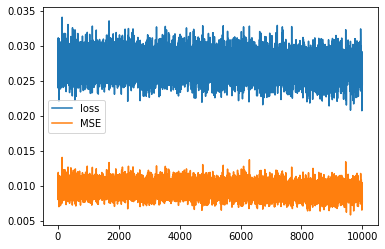

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


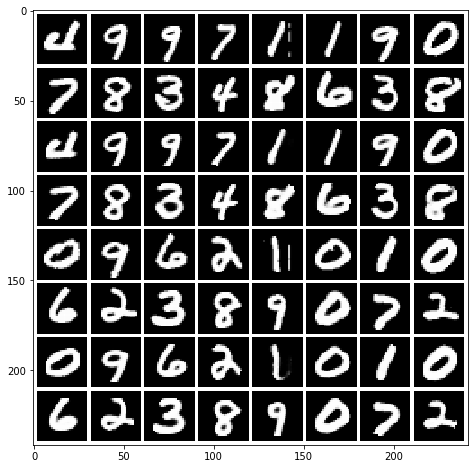

Mean squared dist: 0.009635824
epoch: 22 	 step:0 	 loss: 0.02737 	 reg loss: 0.001853
epoch: 22 	 step:100 	 loss: 0.02554 	 reg loss: 0.001783
epoch: 22 	 step:200 	 loss: 0.02896 	 reg loss: 0.001851
epoch: 22 	 step:300 	 loss: 0.02859 	 reg loss: 0.001814
epoch: 22 	 step:400 	 loss: 0.02492 	 reg loss: 0.001808
epoch: 22 	 step:500 	 loss: 0.02677 	 reg loss: 0.001779
epoch: 22 	 step:600 	 loss: 0.02694 	 reg loss: 0.001765
epoch: 22 	 step:700 	 loss: 0.02825 	 reg loss: 0.00185
epoch: 22 	 step:800 	 loss: 0.02552 	 reg loss: 0.001796
epoch: 22 	 step:900 	 loss: 0.02935 	 reg loss: 0.001868
epoch: 22 	 step:1000 	 loss: 0.02696 	 reg loss: 0.001761
epoch: 22 	 step:1100 	 loss: 0.02737 	 reg loss: 0.001794
epoch: 22 	 step:1200 	 loss: 0.02664 	 reg loss: 0.001812
epoch: 22 	 step:1300 	 loss: 0.02804 	 reg loss: 0.001756
epoch: 22 	 step:1400 	 loss: 0.02525 	 reg loss: 0.00181
epoch: 22 	 step:1500 	 loss: 0.02503 	 reg loss: 0.001788
epoch: 22 	 step:1600 	 loss: 0.02793 	

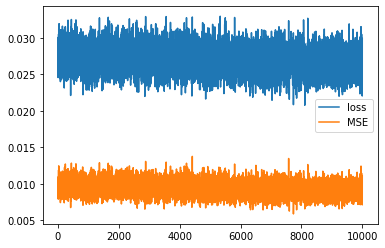

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


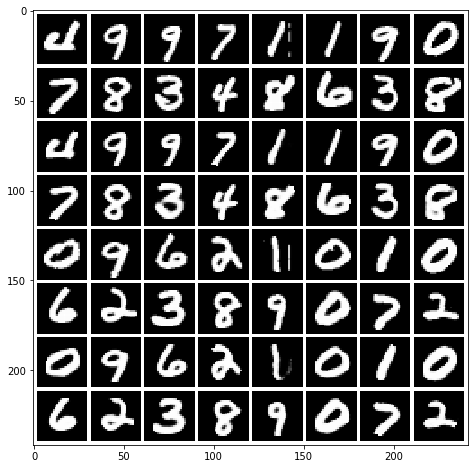

Mean squared dist: 0.00943787
epoch: 23 	 step:0 	 loss: 0.0255 	 reg loss: 0.001735
epoch: 23 	 step:100 	 loss: 0.02567 	 reg loss: 0.001778
epoch: 23 	 step:200 	 loss: 0.02794 	 reg loss: 0.001827
epoch: 23 	 step:300 	 loss: 0.02439 	 reg loss: 0.001754
epoch: 23 	 step:400 	 loss: 0.0256 	 reg loss: 0.00183
epoch: 23 	 step:500 	 loss: 0.02807 	 reg loss: 0.001831
epoch: 23 	 step:600 	 loss: 0.0254 	 reg loss: 0.001844
epoch: 23 	 step:700 	 loss: 0.02545 	 reg loss: 0.001833
epoch: 23 	 step:800 	 loss: 0.02596 	 reg loss: 0.001862
epoch: 23 	 step:900 	 loss: 0.02564 	 reg loss: 0.001796
epoch: 23 	 step:1000 	 loss: 0.02779 	 reg loss: 0.001841
epoch: 23 	 step:1100 	 loss: 0.0235 	 reg loss: 0.001751
epoch: 23 	 step:1200 	 loss: 0.02512 	 reg loss: 0.001812
epoch: 23 	 step:1300 	 loss: 0.02723 	 reg loss: 0.001791
epoch: 23 	 step:1400 	 loss: 0.0308 	 reg loss: 0.001885
epoch: 23 	 step:1500 	 loss: 0.02536 	 reg loss: 0.001827
epoch: 23 	 step:1600 	 loss: 0.02739 	 reg 

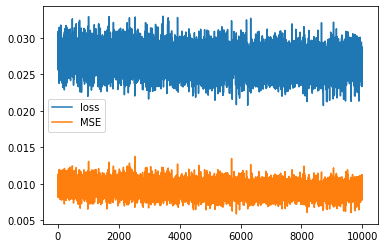

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


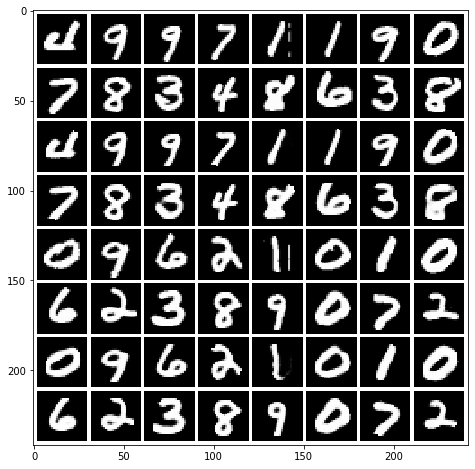

Mean squared dist: 0.0094270855
epoch: 24 	 step:0 	 loss: 0.02753 	 reg loss: 0.001832
epoch: 24 	 step:100 	 loss: 0.02569 	 reg loss: 0.001876
epoch: 24 	 step:200 	 loss: 0.02594 	 reg loss: 0.001799
epoch: 24 	 step:300 	 loss: 0.02718 	 reg loss: 0.00192
epoch: 24 	 step:400 	 loss: 0.02555 	 reg loss: 0.001823
epoch: 24 	 step:500 	 loss: 0.02692 	 reg loss: 0.001863
epoch: 24 	 step:600 	 loss: 0.0277 	 reg loss: 0.00187
epoch: 24 	 step:700 	 loss: 0.02547 	 reg loss: 0.001775
epoch: 24 	 step:800 	 loss: 0.02588 	 reg loss: 0.001785
epoch: 24 	 step:900 	 loss: 0.02805 	 reg loss: 0.001843
epoch: 24 	 step:1000 	 loss: 0.02707 	 reg loss: 0.001824
epoch: 24 	 step:1100 	 loss: 0.02609 	 reg loss: 0.001858
epoch: 24 	 step:1200 	 loss: 0.02423 	 reg loss: 0.001817
epoch: 24 	 step:1300 	 loss: 0.02605 	 reg loss: 0.001765
epoch: 24 	 step:1400 	 loss: 0.02881 	 reg loss: 0.001922
epoch: 24 	 step:1500 	 loss: 0.02647 	 reg loss: 0.001866
epoch: 24 	 step:1600 	 loss: 0.02525 	

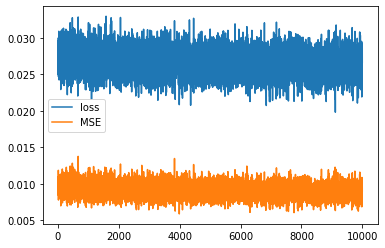

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


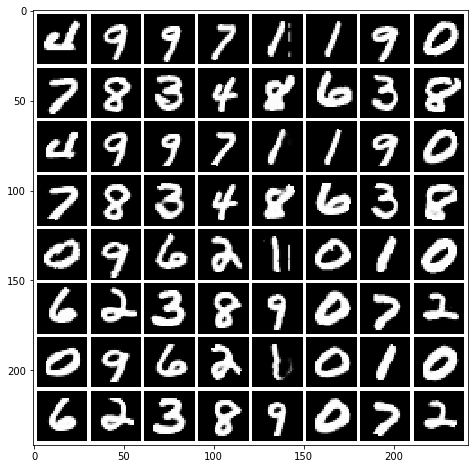

Mean squared dist: 0.009412266
epoch: 25 	 step:0 	 loss: 0.0274 	 reg loss: 0.001761
epoch: 25 	 step:100 	 loss: 0.02851 	 reg loss: 0.001838
epoch: 25 	 step:200 	 loss: 0.02545 	 reg loss: 0.00183
epoch: 25 	 step:300 	 loss: 0.02695 	 reg loss: 0.001779
epoch: 25 	 step:400 	 loss: 0.02393 	 reg loss: 0.00177
epoch: 25 	 step:500 	 loss: 0.0276 	 reg loss: 0.001809
epoch: 25 	 step:600 	 loss: 0.02788 	 reg loss: 0.001804
epoch: 25 	 step:700 	 loss: 0.0271 	 reg loss: 0.001841
epoch: 25 	 step:800 	 loss: 0.02682 	 reg loss: 0.001821
epoch: 25 	 step:900 	 loss: 0.02748 	 reg loss: 0.001834
epoch: 25 	 step:1000 	 loss: 0.0246 	 reg loss: 0.001824
epoch: 25 	 step:1100 	 loss: 0.02607 	 reg loss: 0.001793
epoch: 25 	 step:1200 	 loss: 0.02819 	 reg loss: 0.001904
epoch: 25 	 step:1300 	 loss: 0.02778 	 reg loss: 0.001869
epoch: 25 	 step:1400 	 loss: 0.02603 	 reg loss: 0.001862
epoch: 25 	 step:1500 	 loss: 0.02605 	 reg loss: 0.001779
epoch: 25 	 step:1600 	 loss: 0.0214 	 reg 

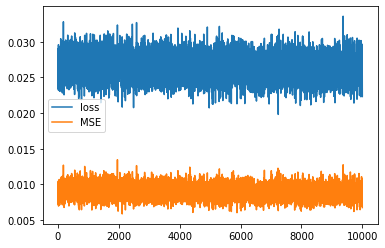

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


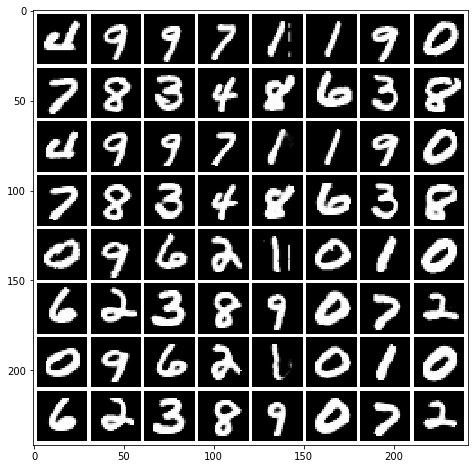

Mean squared dist: 0.009247576
epoch: 26 	 step:0 	 loss: 0.02702 	 reg loss: 0.001811
epoch: 26 	 step:100 	 loss: 0.02816 	 reg loss: 0.0019
epoch: 26 	 step:200 	 loss: 0.02707 	 reg loss: 0.001839
epoch: 26 	 step:300 	 loss: 0.02483 	 reg loss: 0.001744
epoch: 26 	 step:400 	 loss: 0.02564 	 reg loss: 0.001846
epoch: 26 	 step:500 	 loss: 0.0283 	 reg loss: 0.001825
epoch: 26 	 step:600 	 loss: 0.02733 	 reg loss: 0.001855
epoch: 26 	 step:700 	 loss: 0.02435 	 reg loss: 0.001721
epoch: 26 	 step:800 	 loss: 0.02525 	 reg loss: 0.001777
epoch: 26 	 step:900 	 loss: 0.03071 	 reg loss: 0.001874
epoch: 26 	 step:1000 	 loss: 0.02634 	 reg loss: 0.001822
epoch: 26 	 step:1100 	 loss: 0.02505 	 reg loss: 0.001779
epoch: 26 	 step:1200 	 loss: 0.02487 	 reg loss: 0.00184
epoch: 26 	 step:1300 	 loss: 0.02312 	 reg loss: 0.001796
epoch: 26 	 step:1400 	 loss: 0.02589 	 reg loss: 0.001809
epoch: 26 	 step:1500 	 loss: 0.02257 	 reg loss: 0.001707
epoch: 26 	 step:1600 	 loss: 0.02953 	 r

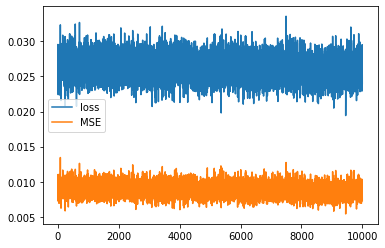

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


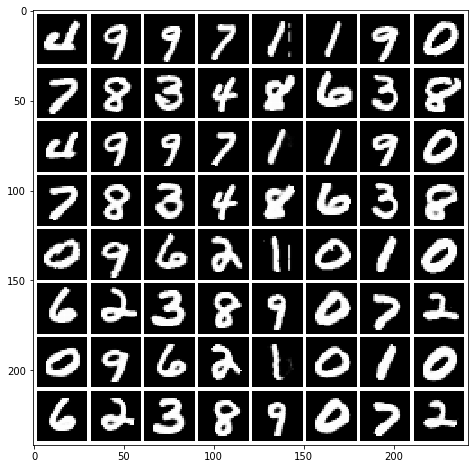

Mean squared dist: 0.00914002
epoch: 27 	 step:0 	 loss: 0.02387 	 reg loss: 0.001746
epoch: 27 	 step:100 	 loss: 0.02509 	 reg loss: 0.001797
epoch: 27 	 step:200 	 loss: 0.02322 	 reg loss: 0.001759
epoch: 27 	 step:300 	 loss: 0.02721 	 reg loss: 0.001778
epoch: 27 	 step:400 	 loss: 0.02576 	 reg loss: 0.001814
epoch: 27 	 step:500 	 loss: 0.02663 	 reg loss: 0.001839
epoch: 27 	 step:600 	 loss: 0.02629 	 reg loss: 0.001825
epoch: 27 	 step:700 	 loss: 0.02486 	 reg loss: 0.001795
epoch: 27 	 step:800 	 loss: 0.02625 	 reg loss: 0.001784
epoch: 27 	 step:900 	 loss: 0.02702 	 reg loss: 0.001813
epoch: 27 	 step:1000 	 loss: 0.02761 	 reg loss: 0.001827
epoch: 27 	 step:1100 	 loss: 0.02055 	 reg loss: 0.001739
epoch: 27 	 step:1200 	 loss: 0.02631 	 reg loss: 0.001789
epoch: 27 	 step:1300 	 loss: 0.02547 	 reg loss: 0.001789
epoch: 27 	 step:1400 	 loss: 0.0258 	 reg loss: 0.001811
epoch: 27 	 step:1500 	 loss: 0.03011 	 reg loss: 0.001793
epoch: 27 	 step:1600 	 loss: 0.02442 	

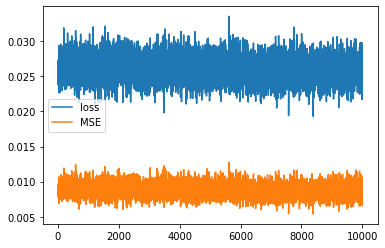

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


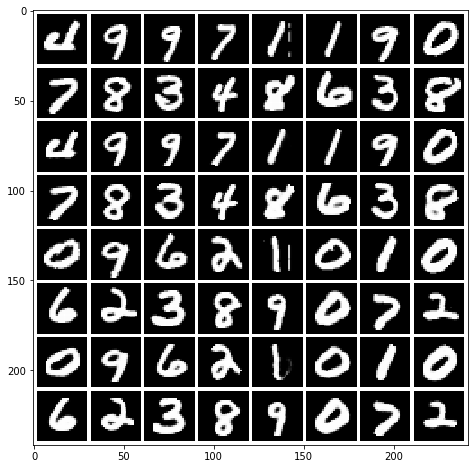

Mean squared dist: 0.009315927
epoch: 28 	 step:0 	 loss: 0.0258 	 reg loss: 0.001794
epoch: 28 	 step:100 	 loss: 0.02635 	 reg loss: 0.001864
epoch: 28 	 step:200 	 loss: 0.02994 	 reg loss: 0.001868
epoch: 28 	 step:300 	 loss: 0.0245 	 reg loss: 0.001787
epoch: 28 	 step:400 	 loss: 0.02576 	 reg loss: 0.001813
epoch: 28 	 step:500 	 loss: 0.024 	 reg loss: 0.001774
epoch: 28 	 step:600 	 loss: 0.02663 	 reg loss: 0.001801
epoch: 28 	 step:700 	 loss: 0.02641 	 reg loss: 0.001848
epoch: 28 	 step:800 	 loss: 0.0245 	 reg loss: 0.001757
epoch: 28 	 step:900 	 loss: 0.02522 	 reg loss: 0.001807
epoch: 28 	 step:1000 	 loss: 0.02515 	 reg loss: 0.001851
epoch: 28 	 step:1100 	 loss: 0.02427 	 reg loss: 0.001821
epoch: 28 	 step:1200 	 loss: 0.0257 	 reg loss: 0.00184
epoch: 28 	 step:1300 	 loss: 0.02654 	 reg loss: 0.00181
epoch: 28 	 step:1400 	 loss: 0.02521 	 reg loss: 0.001803
epoch: 28 	 step:1500 	 loss: 0.02622 	 reg loss: 0.001768
epoch: 28 	 step:1600 	 loss: 0.02537 	 reg l

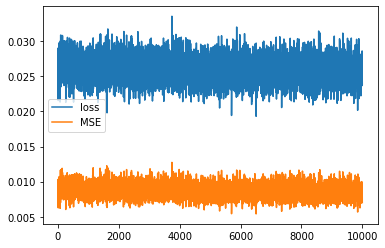

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


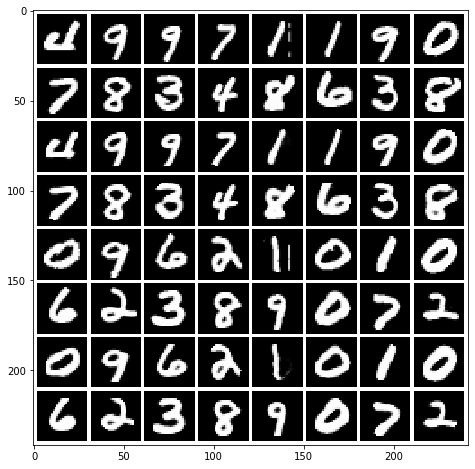

Mean squared dist: 0.009148025
epoch: 29 	 step:0 	 loss: 0.02234 	 reg loss: 0.001774
epoch: 29 	 step:100 	 loss: 0.02235 	 reg loss: 0.001706
epoch: 29 	 step:200 	 loss: 0.02502 	 reg loss: 0.001815
epoch: 29 	 step:300 	 loss: 0.02683 	 reg loss: 0.001861
epoch: 29 	 step:400 	 loss: 0.02303 	 reg loss: 0.00177
epoch: 29 	 step:500 	 loss: 0.02566 	 reg loss: 0.001868
epoch: 29 	 step:600 	 loss: 0.02672 	 reg loss: 0.001815
epoch: 29 	 step:700 	 loss: 0.02676 	 reg loss: 0.001809
epoch: 29 	 step:800 	 loss: 0.02728 	 reg loss: 0.001816
epoch: 29 	 step:900 	 loss: 0.02514 	 reg loss: 0.001805
epoch: 29 	 step:1000 	 loss: 0.02766 	 reg loss: 0.001845
epoch: 29 	 step:1100 	 loss: 0.02743 	 reg loss: 0.001764
epoch: 29 	 step:1200 	 loss: 0.02672 	 reg loss: 0.0018
epoch: 29 	 step:1300 	 loss: 0.02422 	 reg loss: 0.0018
epoch: 29 	 step:1400 	 loss: 0.02625 	 reg loss: 0.001866
epoch: 29 	 step:1500 	 loss: 0.02799 	 reg loss: 0.001822
epoch: 29 	 step:1600 	 loss: 0.02765 	 re

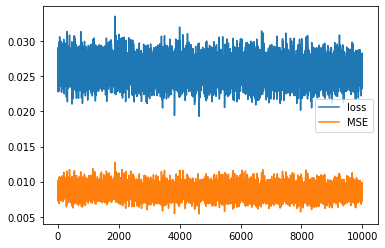

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


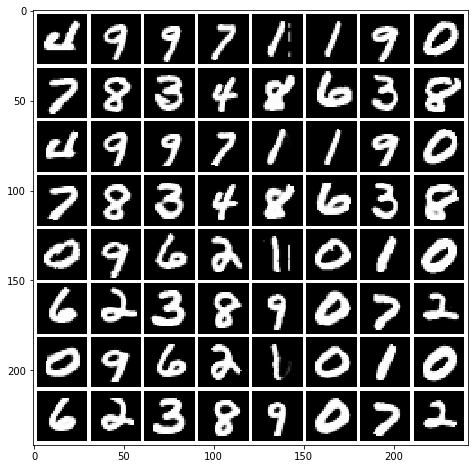

Mean squared dist: 0.009030659
epoch: 30 	 step:0 	 loss: 0.02417 	 reg loss: 0.001759
epoch: 30 	 step:100 	 loss: 0.02629 	 reg loss: 0.001876
epoch: 30 	 step:200 	 loss: 0.02739 	 reg loss: 0.001824
epoch: 30 	 step:300 	 loss: 0.02769 	 reg loss: 0.001859
epoch: 30 	 step:400 	 loss: 0.02442 	 reg loss: 0.001731
epoch: 30 	 step:500 	 loss: 0.02435 	 reg loss: 0.001829
epoch: 30 	 step:600 	 loss: 0.02571 	 reg loss: 0.001834
epoch: 30 	 step:700 	 loss: 0.02574 	 reg loss: 0.001777
epoch: 30 	 step:800 	 loss: 0.02308 	 reg loss: 0.001738
epoch: 30 	 step:900 	 loss: 0.02408 	 reg loss: 0.00178
epoch: 30 	 step:1000 	 loss: 0.02336 	 reg loss: 0.001754
epoch: 30 	 step:1100 	 loss: 0.02693 	 reg loss: 0.001809
epoch: 30 	 step:1200 	 loss: 0.02555 	 reg loss: 0.001761
epoch: 30 	 step:1300 	 loss: 0.02527 	 reg loss: 0.001802
epoch: 30 	 step:1400 	 loss: 0.02729 	 reg loss: 0.001814
epoch: 30 	 step:1500 	 loss: 0.0272 	 reg loss: 0.001746
epoch: 30 	 step:1600 	 loss: 0.0258 	 

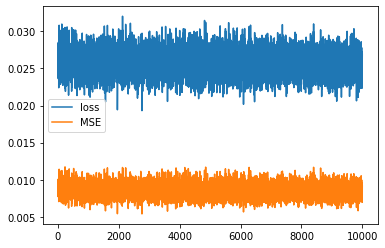

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


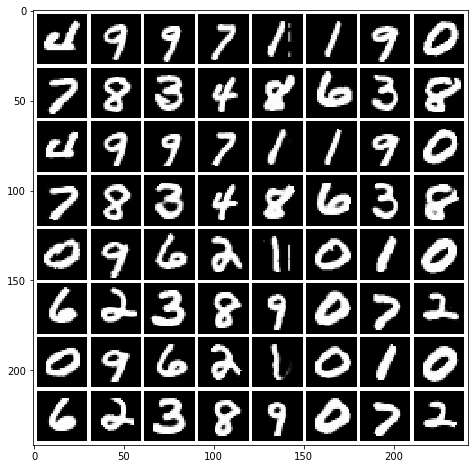

Mean squared dist: 0.00900867
epoch: 31 	 step:0 	 loss: 0.02577 	 reg loss: 0.001833
epoch: 31 	 step:100 	 loss: 0.02474 	 reg loss: 0.001796
epoch: 31 	 step:200 	 loss: 0.02498 	 reg loss: 0.001831
epoch: 31 	 step:300 	 loss: 0.02696 	 reg loss: 0.001899
epoch: 31 	 step:400 	 loss: 0.02518 	 reg loss: 0.001878
epoch: 31 	 step:500 	 loss: 0.02715 	 reg loss: 0.001798
epoch: 31 	 step:600 	 loss: 0.02846 	 reg loss: 0.00185
epoch: 31 	 step:700 	 loss: 0.02775 	 reg loss: 0.001779
epoch: 31 	 step:800 	 loss: 0.02466 	 reg loss: 0.001727
epoch: 31 	 step:900 	 loss: 0.02249 	 reg loss: 0.001767
epoch: 31 	 step:1000 	 loss: 0.02788 	 reg loss: 0.001821
epoch: 31 	 step:1100 	 loss: 0.02544 	 reg loss: 0.00183
epoch: 31 	 step:1200 	 loss: 0.02516 	 reg loss: 0.00184
epoch: 31 	 step:1300 	 loss: 0.02743 	 reg loss: 0.00184
epoch: 31 	 step:1400 	 loss: 0.02534 	 reg loss: 0.001832
epoch: 31 	 step:1500 	 loss: 0.02562 	 reg loss: 0.001843
epoch: 31 	 step:1600 	 loss: 0.02559 	 re

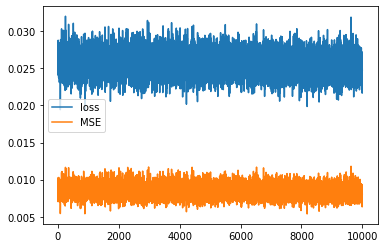

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


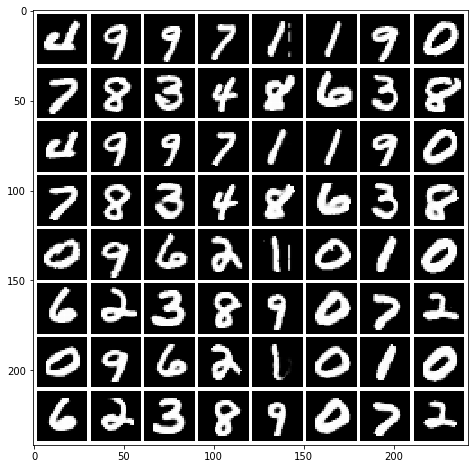

Mean squared dist: 0.008966457
epoch: 32 	 step:0 	 loss: 0.02342 	 reg loss: 0.001762
epoch: 32 	 step:100 	 loss: 0.02503 	 reg loss: 0.001723
epoch: 32 	 step:200 	 loss: 0.02585 	 reg loss: 0.001815
epoch: 32 	 step:300 	 loss: 0.0254 	 reg loss: 0.001814
epoch: 32 	 step:400 	 loss: 0.0259 	 reg loss: 0.001792
epoch: 32 	 step:500 	 loss: 0.02553 	 reg loss: 0.001836
epoch: 32 	 step:600 	 loss: 0.02521 	 reg loss: 0.001772
epoch: 32 	 step:700 	 loss: 0.02896 	 reg loss: 0.001842
epoch: 32 	 step:800 	 loss: 0.02433 	 reg loss: 0.001751
epoch: 32 	 step:900 	 loss: 0.02686 	 reg loss: 0.001851
epoch: 32 	 step:1000 	 loss: 0.02432 	 reg loss: 0.001743
epoch: 32 	 step:1100 	 loss: 0.02345 	 reg loss: 0.001803
epoch: 32 	 step:1200 	 loss: 0.02369 	 reg loss: 0.001731
epoch: 32 	 step:1300 	 loss: 0.0226 	 reg loss: 0.00171
epoch: 32 	 step:1400 	 loss: 0.02893 	 reg loss: 0.001885
epoch: 32 	 step:1500 	 loss: 0.02239 	 reg loss: 0.001751
epoch: 32 	 step:1600 	 loss: 0.02435 	 r

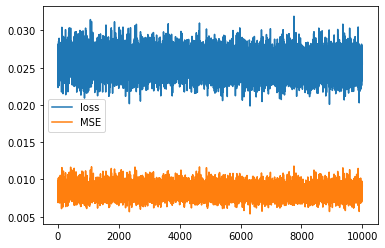

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


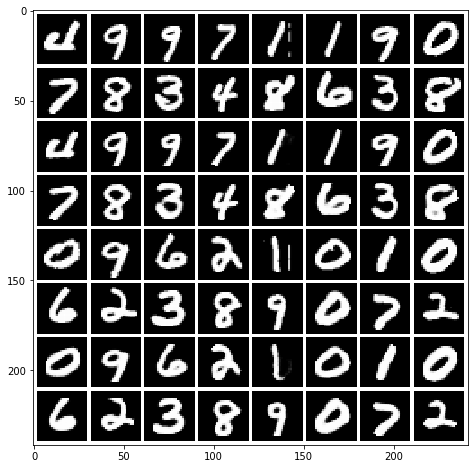

Mean squared dist: 0.008942318
epoch: 33 	 step:0 	 loss: 0.0244 	 reg loss: 0.001751
epoch: 33 	 step:100 	 loss: 0.02365 	 reg loss: 0.001749
epoch: 33 	 step:200 	 loss: 0.02567 	 reg loss: 0.001807
epoch: 33 	 step:300 	 loss: 0.02483 	 reg loss: 0.001815
epoch: 33 	 step:400 	 loss: 0.02144 	 reg loss: 0.001679
epoch: 33 	 step:500 	 loss: 0.02433 	 reg loss: 0.001817
epoch: 33 	 step:600 	 loss: 0.02603 	 reg loss: 0.001749
epoch: 33 	 step:700 	 loss: 0.02417 	 reg loss: 0.001768
epoch: 33 	 step:800 	 loss: 0.0227 	 reg loss: 0.001745
epoch: 33 	 step:900 	 loss: 0.02399 	 reg loss: 0.001749
epoch: 33 	 step:1000 	 loss: 0.02581 	 reg loss: 0.00179
epoch: 33 	 step:1100 	 loss: 0.02826 	 reg loss: 0.001883
epoch: 33 	 step:1200 	 loss: 0.02574 	 reg loss: 0.001835
epoch: 33 	 step:1300 	 loss: 0.02827 	 reg loss: 0.001884
epoch: 33 	 step:1400 	 loss: 0.0256 	 reg loss: 0.001743
epoch: 33 	 step:1500 	 loss: 0.02532 	 reg loss: 0.001806
epoch: 33 	 step:1600 	 loss: 0.02604 	 r

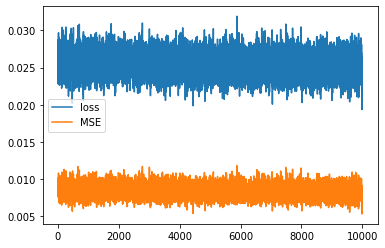

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


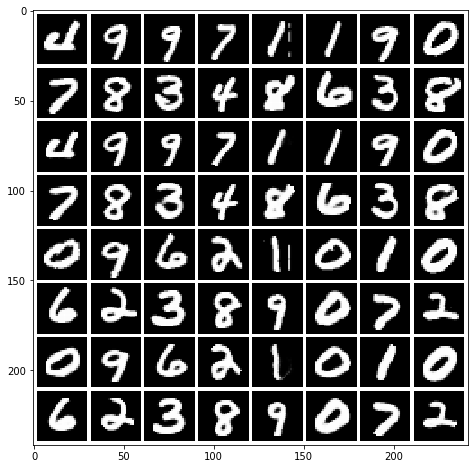

Mean squared dist: 0.008812485
epoch: 34 	 step:0 	 loss: 0.02428 	 reg loss: 0.001851
epoch: 34 	 step:100 	 loss: 0.02554 	 reg loss: 0.001767
epoch: 34 	 step:200 	 loss: 0.02475 	 reg loss: 0.001779
epoch: 34 	 step:300 	 loss: 0.02365 	 reg loss: 0.001826
epoch: 34 	 step:400 	 loss: 0.02675 	 reg loss: 0.001777
epoch: 34 	 step:500 	 loss: 0.02535 	 reg loss: 0.001781
epoch: 34 	 step:600 	 loss: 0.02695 	 reg loss: 0.001787
epoch: 34 	 step:700 	 loss: 0.0257 	 reg loss: 0.001838
epoch: 34 	 step:800 	 loss: 0.02737 	 reg loss: 0.001848
epoch: 34 	 step:900 	 loss: 0.02473 	 reg loss: 0.0018
epoch: 34 	 step:1000 	 loss: 0.02723 	 reg loss: 0.00183
epoch: 34 	 step:1100 	 loss: 0.02707 	 reg loss: 0.001861
epoch: 34 	 step:1200 	 loss: 0.02498 	 reg loss: 0.0018
epoch: 34 	 step:1300 	 loss: 0.02674 	 reg loss: 0.001795
epoch: 34 	 step:1400 	 loss: 0.023 	 reg loss: 0.001771
epoch: 34 	 step:1500 	 loss: 0.02488 	 reg loss: 0.001789
epoch: 34 	 step:1600 	 loss: 0.02214 	 reg l

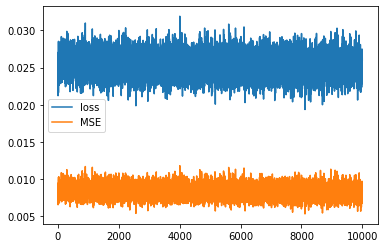

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


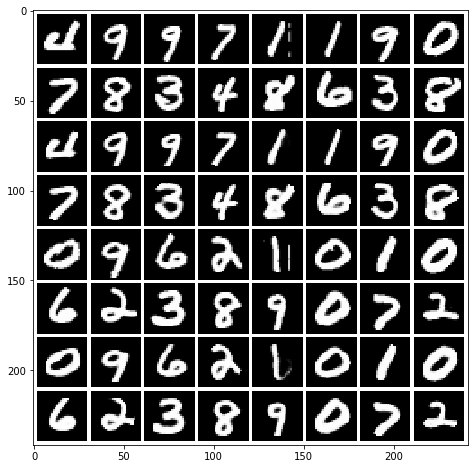

Mean squared dist: 0.008875146
epoch: 35 	 step:0 	 loss: 0.0241 	 reg loss: 0.001789
epoch: 35 	 step:100 	 loss: 0.02567 	 reg loss: 0.001819
epoch: 35 	 step:200 	 loss: 0.02369 	 reg loss: 0.00178
epoch: 35 	 step:300 	 loss: 0.02368 	 reg loss: 0.001799
epoch: 35 	 step:400 	 loss: 0.027 	 reg loss: 0.001878
epoch: 35 	 step:500 	 loss: 0.0256 	 reg loss: 0.001823
epoch: 35 	 step:600 	 loss: 0.02731 	 reg loss: 0.001838
epoch: 35 	 step:700 	 loss: 0.02233 	 reg loss: 0.001777
epoch: 35 	 step:800 	 loss: 0.02421 	 reg loss: 0.001743
epoch: 35 	 step:900 	 loss: 0.02809 	 reg loss: 0.001831
epoch: 35 	 step:1000 	 loss: 0.0268 	 reg loss: 0.001833
epoch: 35 	 step:1100 	 loss: 0.02334 	 reg loss: 0.001731
epoch: 35 	 step:1200 	 loss: 0.02514 	 reg loss: 0.001834
epoch: 35 	 step:1300 	 loss: 0.02613 	 reg loss: 0.001828
epoch: 35 	 step:1400 	 loss: 0.02401 	 reg loss: 0.001742
epoch: 35 	 step:1500 	 loss: 0.02389 	 reg loss: 0.001738
epoch: 35 	 step:1600 	 loss: 0.0263 	 reg 

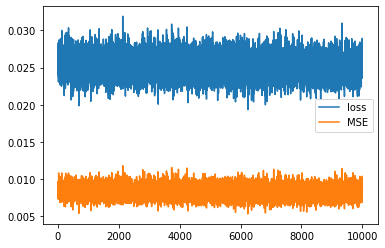

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


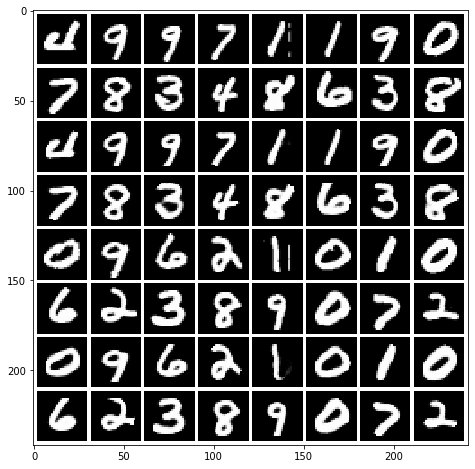

Mean squared dist: 0.008719321
epoch: 36 	 step:0 	 loss: 0.02476 	 reg loss: 0.001791
epoch: 36 	 step:100 	 loss: 0.02697 	 reg loss: 0.001746
epoch: 36 	 step:200 	 loss: 0.02484 	 reg loss: 0.001821
epoch: 36 	 step:300 	 loss: 0.02368 	 reg loss: 0.001742
epoch: 36 	 step:400 	 loss: 0.02421 	 reg loss: 0.001844
epoch: 36 	 step:500 	 loss: 0.02549 	 reg loss: 0.001769
epoch: 36 	 step:600 	 loss: 0.02504 	 reg loss: 0.001759
epoch: 36 	 step:700 	 loss: 0.02582 	 reg loss: 0.001811
epoch: 36 	 step:800 	 loss: 0.0254 	 reg loss: 0.001758
epoch: 36 	 step:900 	 loss: 0.02356 	 reg loss: 0.001748
epoch: 36 	 step:1000 	 loss: 0.02622 	 reg loss: 0.001802
epoch: 36 	 step:1100 	 loss: 0.02434 	 reg loss: 0.001876
epoch: 36 	 step:1200 	 loss: 0.02307 	 reg loss: 0.00176
epoch: 36 	 step:1300 	 loss: 0.02538 	 reg loss: 0.001824
epoch: 36 	 step:1400 	 loss: 0.02706 	 reg loss: 0.001829
epoch: 36 	 step:1500 	 loss: 0.02569 	 reg loss: 0.001804
epoch: 36 	 step:1600 	 loss: 0.02565 	

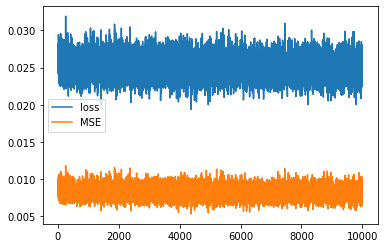

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


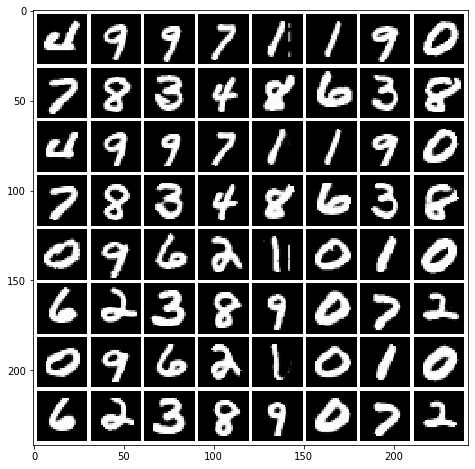

Mean squared dist: 0.008915964
epoch: 37 	 step:0 	 loss: 0.02451 	 reg loss: 0.001828
epoch: 37 	 step:100 	 loss: 0.02541 	 reg loss: 0.001823
epoch: 37 	 step:200 	 loss: 0.02259 	 reg loss: 0.001765
epoch: 37 	 step:300 	 loss: 0.02492 	 reg loss: 0.001865
epoch: 37 	 step:400 	 loss: 0.02201 	 reg loss: 0.001734
epoch: 37 	 step:500 	 loss: 0.0268 	 reg loss: 0.001889
epoch: 37 	 step:600 	 loss: 0.02669 	 reg loss: 0.0018
epoch: 37 	 step:700 	 loss: 0.02725 	 reg loss: 0.001819
epoch: 37 	 step:800 	 loss: 0.02449 	 reg loss: 0.001802
epoch: 37 	 step:900 	 loss: 0.02497 	 reg loss: 0.001788
epoch: 37 	 step:1000 	 loss: 0.02541 	 reg loss: 0.001832
epoch: 37 	 step:1100 	 loss: 0.02639 	 reg loss: 0.001812
epoch: 37 	 step:1200 	 loss: 0.024 	 reg loss: 0.001806
epoch: 37 	 step:1300 	 loss: 0.02583 	 reg loss: 0.00182
epoch: 37 	 step:1400 	 loss: 0.0253 	 reg loss: 0.001775
epoch: 37 	 step:1500 	 loss: 0.02614 	 reg loss: 0.001831
epoch: 37 	 step:1600 	 loss: 0.02495 	 reg 

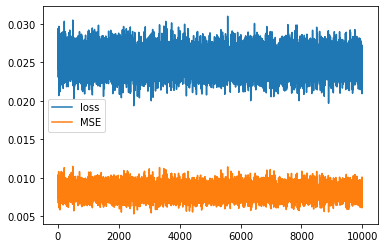

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


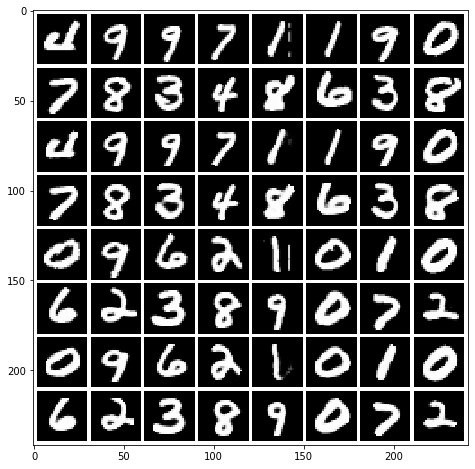

Mean squared dist: 0.008589669
epoch: 38 	 step:0 	 loss: 0.02297 	 reg loss: 0.001822
epoch: 38 	 step:100 	 loss: 0.02498 	 reg loss: 0.00177
epoch: 38 	 step:200 	 loss: 0.02696 	 reg loss: 0.001812
epoch: 38 	 step:300 	 loss: 0.02726 	 reg loss: 0.001784
epoch: 38 	 step:400 	 loss: 0.02227 	 reg loss: 0.001777
epoch: 38 	 step:500 	 loss: 0.02604 	 reg loss: 0.001833
epoch: 38 	 step:600 	 loss: 0.02536 	 reg loss: 0.001857
epoch: 38 	 step:700 	 loss: 0.02575 	 reg loss: 0.001818
epoch: 38 	 step:800 	 loss: 0.02386 	 reg loss: 0.001757
epoch: 38 	 step:900 	 loss: 0.02545 	 reg loss: 0.001754
epoch: 38 	 step:1000 	 loss: 0.02332 	 reg loss: 0.001796
epoch: 38 	 step:1100 	 loss: 0.02704 	 reg loss: 0.001838
epoch: 38 	 step:1200 	 loss: 0.02417 	 reg loss: 0.001829
epoch: 38 	 step:1300 	 loss: 0.02501 	 reg loss: 0.001795
epoch: 38 	 step:1400 	 loss: 0.0218 	 reg loss: 0.001751
epoch: 38 	 step:1500 	 loss: 0.02633 	 reg loss: 0.001813
epoch: 38 	 step:1600 	 loss: 0.02288 	

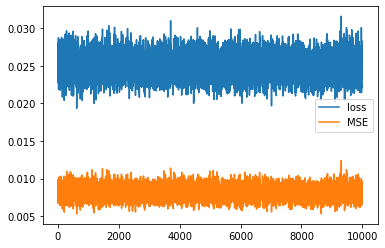

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


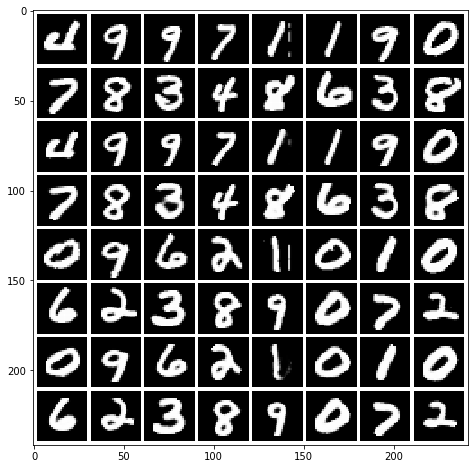

Mean squared dist: 0.008664953
epoch: 39 	 step:0 	 loss: 0.02354 	 reg loss: 0.001784
epoch: 39 	 step:100 	 loss: 0.02514 	 reg loss: 0.001794
epoch: 39 	 step:200 	 loss: 0.02257 	 reg loss: 0.001788
epoch: 39 	 step:300 	 loss: 0.02226 	 reg loss: 0.001794
epoch: 39 	 step:400 	 loss: 0.02148 	 reg loss: 0.00176
epoch: 39 	 step:500 	 loss: 0.02354 	 reg loss: 0.001724
epoch: 39 	 step:600 	 loss: 0.02357 	 reg loss: 0.00177
epoch: 39 	 step:700 	 loss: 0.02434 	 reg loss: 0.001786
epoch: 39 	 step:800 	 loss: 0.02676 	 reg loss: 0.001784
epoch: 39 	 step:900 	 loss: 0.02357 	 reg loss: 0.001833
epoch: 39 	 step:1000 	 loss: 0.02637 	 reg loss: 0.00183
epoch: 39 	 step:1100 	 loss: 0.02682 	 reg loss: 0.001853
epoch: 39 	 step:1200 	 loss: 0.02208 	 reg loss: 0.001777
epoch: 39 	 step:1300 	 loss: 0.02415 	 reg loss: 0.001816
epoch: 39 	 step:1400 	 loss: 0.02702 	 reg loss: 0.001821
epoch: 39 	 step:1500 	 loss: 0.02231 	 reg loss: 0.001743
epoch: 39 	 step:1600 	 loss: 0.02444 	 

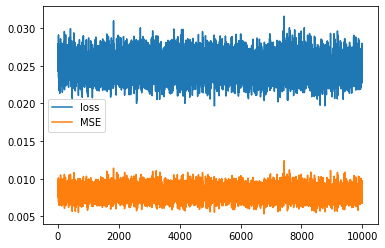

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


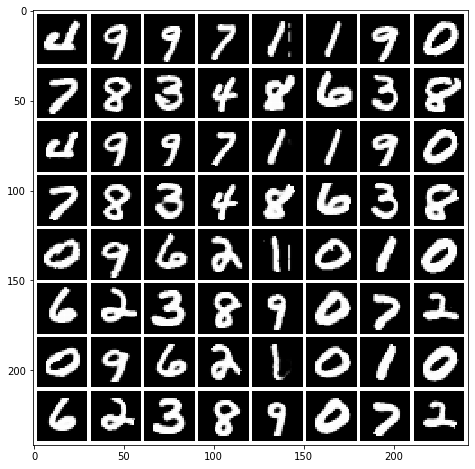

Mean squared dist: 0.008579986
epoch: 40 	 step:0 	 loss: 0.02384 	 reg loss: 0.001766
epoch: 40 	 step:100 	 loss: 0.02607 	 reg loss: 0.001764
epoch: 40 	 step:200 	 loss: 0.02463 	 reg loss: 0.001851
epoch: 40 	 step:300 	 loss: 0.02583 	 reg loss: 0.001795
epoch: 40 	 step:400 	 loss: 0.02753 	 reg loss: 0.00184
epoch: 40 	 step:500 	 loss: 0.02271 	 reg loss: 0.001773
epoch: 40 	 step:600 	 loss: 0.02496 	 reg loss: 0.00184
epoch: 40 	 step:700 	 loss: 0.02821 	 reg loss: 0.00185
epoch: 40 	 step:800 	 loss: 0.02615 	 reg loss: 0.001833
epoch: 40 	 step:900 	 loss: 0.02529 	 reg loss: 0.001719
epoch: 40 	 step:1000 	 loss: 0.02692 	 reg loss: 0.001782
epoch: 40 	 step:1100 	 loss: 0.02258 	 reg loss: 0.001746
epoch: 40 	 step:1200 	 loss: 0.02596 	 reg loss: 0.0018
epoch: 40 	 step:1300 	 loss: 0.02518 	 reg loss: 0.001812
epoch: 40 	 step:1400 	 loss: 0.02533 	 reg loss: 0.001748
epoch: 40 	 step:1500 	 loss: 0.02667 	 reg loss: 0.001789
epoch: 40 	 step:1600 	 loss: 0.02414 	 re

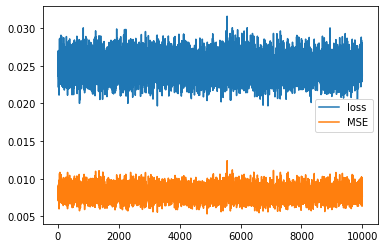

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


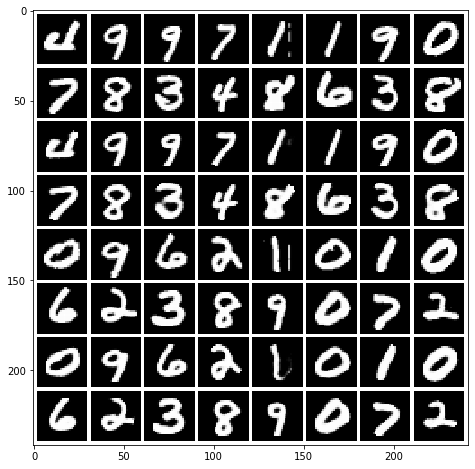

Mean squared dist: 0.008636649
epoch: 41 	 step:0 	 loss: 0.02289 	 reg loss: 0.001804
epoch: 41 	 step:100 	 loss: 0.02483 	 reg loss: 0.001759
epoch: 41 	 step:200 	 loss: 0.023 	 reg loss: 0.001764
epoch: 41 	 step:300 	 loss: 0.02321 	 reg loss: 0.001802
epoch: 41 	 step:400 	 loss: 0.02422 	 reg loss: 0.001774
epoch: 41 	 step:500 	 loss: 0.02569 	 reg loss: 0.001783
epoch: 41 	 step:600 	 loss: 0.0241 	 reg loss: 0.001716
epoch: 41 	 step:700 	 loss: 0.02546 	 reg loss: 0.001832
epoch: 41 	 step:800 	 loss: 0.02215 	 reg loss: 0.001762
epoch: 41 	 step:900 	 loss: 0.02636 	 reg loss: 0.001887
epoch: 41 	 step:1000 	 loss: 0.02583 	 reg loss: 0.001874
epoch: 41 	 step:1100 	 loss: 0.02591 	 reg loss: 0.001829
epoch: 41 	 step:1200 	 loss: 0.02524 	 reg loss: 0.001873
epoch: 41 	 step:1300 	 loss: 0.0262 	 reg loss: 0.00191
epoch: 41 	 step:1400 	 loss: 0.02376 	 reg loss: 0.001824
epoch: 41 	 step:1500 	 loss: 0.02552 	 reg loss: 0.001742
epoch: 41 	 step:1600 	 loss: 0.02469 	 re

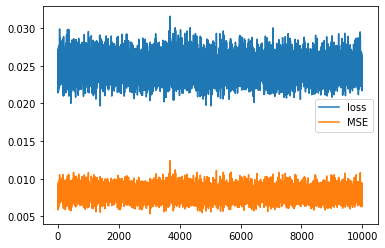

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


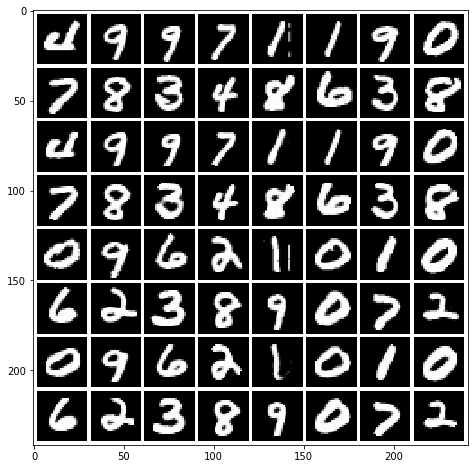

Mean squared dist: 0.008651164
epoch: 42 	 step:0 	 loss: 0.02224 	 reg loss: 0.001716
epoch: 42 	 step:100 	 loss: 0.02558 	 reg loss: 0.001821
epoch: 42 	 step:200 	 loss: 0.02369 	 reg loss: 0.001848
epoch: 42 	 step:300 	 loss: 0.02319 	 reg loss: 0.001765
epoch: 42 	 step:400 	 loss: 0.02621 	 reg loss: 0.001855
epoch: 42 	 step:500 	 loss: 0.02385 	 reg loss: 0.001792
epoch: 42 	 step:600 	 loss: 0.02419 	 reg loss: 0.001863
epoch: 42 	 step:700 	 loss: 0.02798 	 reg loss: 0.001891
epoch: 42 	 step:800 	 loss: 0.02374 	 reg loss: 0.001802
epoch: 42 	 step:900 	 loss: 0.02609 	 reg loss: 0.00177
epoch: 42 	 step:1000 	 loss: 0.02465 	 reg loss: 0.00182
epoch: 42 	 step:1100 	 loss: 0.0267 	 reg loss: 0.001817
epoch: 42 	 step:1200 	 loss: 0.0267 	 reg loss: 0.001832
epoch: 42 	 step:1300 	 loss: 0.02539 	 reg loss: 0.0018
epoch: 42 	 step:1400 	 loss: 0.02383 	 reg loss: 0.00178
epoch: 42 	 step:1500 	 loss: 0.02484 	 reg loss: 0.001814
epoch: 42 	 step:1600 	 loss: 0.02602 	 reg 

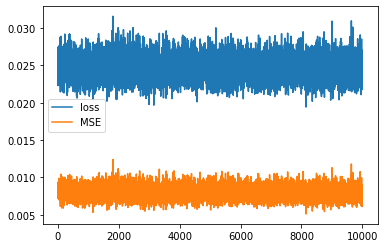

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


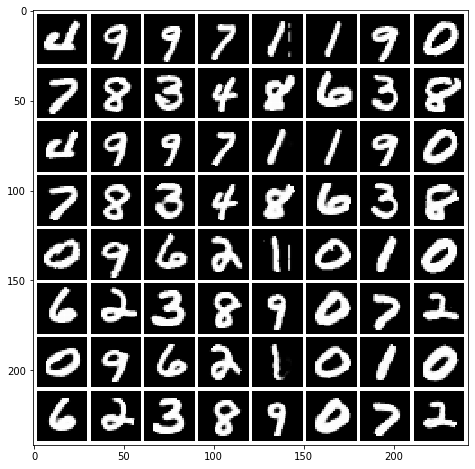

Mean squared dist: 0.008611036
epoch: 43 	 step:0 	 loss: 0.02624 	 reg loss: 0.001825
epoch: 43 	 step:100 	 loss: 0.02301 	 reg loss: 0.001799
epoch: 43 	 step:200 	 loss: 0.02653 	 reg loss: 0.001808
epoch: 43 	 step:300 	 loss: 0.02589 	 reg loss: 0.001819
epoch: 43 	 step:400 	 loss: 0.02509 	 reg loss: 0.001853
epoch: 43 	 step:500 	 loss: 0.02144 	 reg loss: 0.001747
epoch: 43 	 step:600 	 loss: 0.02392 	 reg loss: 0.001772
epoch: 43 	 step:700 	 loss: 0.02354 	 reg loss: 0.001735
epoch: 43 	 step:800 	 loss: 0.02628 	 reg loss: 0.001853
epoch: 43 	 step:900 	 loss: 0.02341 	 reg loss: 0.001789
epoch: 43 	 step:1000 	 loss: 0.02399 	 reg loss: 0.001818
epoch: 43 	 step:1100 	 loss: 0.02197 	 reg loss: 0.001786
epoch: 43 	 step:1200 	 loss: 0.02228 	 reg loss: 0.001733
epoch: 43 	 step:1300 	 loss: 0.02284 	 reg loss: 0.001849
epoch: 43 	 step:1400 	 loss: 0.02457 	 reg loss: 0.001788
epoch: 43 	 step:1500 	 loss: 0.02319 	 reg loss: 0.001771
epoch: 43 	 step:1600 	 loss: 0.0239 

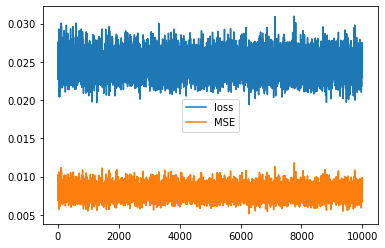

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


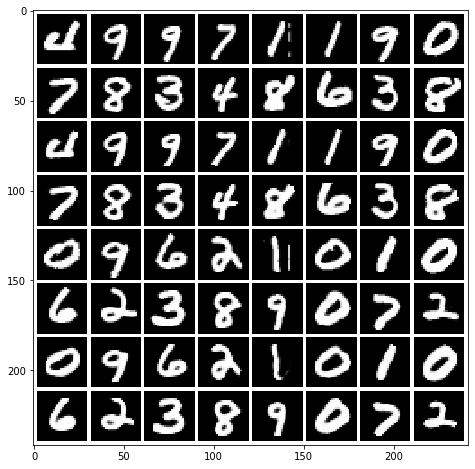

Mean squared dist: 0.008467071
epoch: 44 	 step:0 	 loss: 0.02451 	 reg loss: 0.00177
epoch: 44 	 step:100 	 loss: 0.02258 	 reg loss: 0.001714
epoch: 44 	 step:200 	 loss: 0.02267 	 reg loss: 0.001748
epoch: 44 	 step:300 	 loss: 0.02502 	 reg loss: 0.001849
epoch: 44 	 step:400 	 loss: 0.02437 	 reg loss: 0.001786
epoch: 44 	 step:500 	 loss: 0.02438 	 reg loss: 0.001841
epoch: 44 	 step:600 	 loss: 0.02478 	 reg loss: 0.001811
epoch: 44 	 step:700 	 loss: 0.0252 	 reg loss: 0.001833
epoch: 44 	 step:800 	 loss: 0.02451 	 reg loss: 0.001815
epoch: 44 	 step:900 	 loss: 0.02443 	 reg loss: 0.001842
epoch: 44 	 step:1000 	 loss: 0.02355 	 reg loss: 0.001791
epoch: 44 	 step:1100 	 loss: 0.02449 	 reg loss: 0.001777
epoch: 44 	 step:1200 	 loss: 0.024 	 reg loss: 0.001812
epoch: 44 	 step:1300 	 loss: 0.02586 	 reg loss: 0.001812
epoch: 44 	 step:1400 	 loss: 0.0263 	 reg loss: 0.001765
epoch: 44 	 step:1500 	 loss: 0.02682 	 reg loss: 0.001789
epoch: 44 	 step:1600 	 loss: 0.02397 	 re

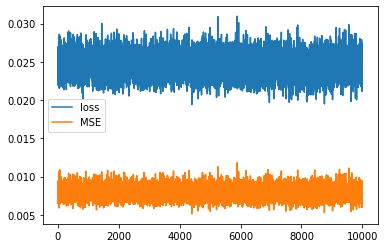

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


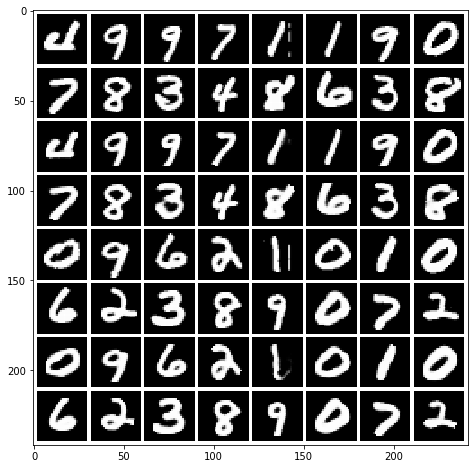

Mean squared dist: 0.008484402
epoch: 45 	 step:0 	 loss: 0.02281 	 reg loss: 0.001759
epoch: 45 	 step:100 	 loss: 0.02575 	 reg loss: 0.001879
epoch: 45 	 step:200 	 loss: 0.02552 	 reg loss: 0.001861
epoch: 45 	 step:300 	 loss: 0.02356 	 reg loss: 0.001805
epoch: 45 	 step:400 	 loss: 0.02268 	 reg loss: 0.001762
epoch: 45 	 step:500 	 loss: 0.02519 	 reg loss: 0.001808
epoch: 45 	 step:600 	 loss: 0.02305 	 reg loss: 0.001768
epoch: 45 	 step:700 	 loss: 0.02345 	 reg loss: 0.00185
epoch: 45 	 step:800 	 loss: 0.0234 	 reg loss: 0.001777
epoch: 45 	 step:900 	 loss: 0.02465 	 reg loss: 0.001809
epoch: 45 	 step:1000 	 loss: 0.02415 	 reg loss: 0.001843
epoch: 45 	 step:1100 	 loss: 0.02396 	 reg loss: 0.001829
epoch: 45 	 step:1200 	 loss: 0.02349 	 reg loss: 0.00174
epoch: 45 	 step:1300 	 loss: 0.02584 	 reg loss: 0.00175
epoch: 45 	 step:1400 	 loss: 0.02589 	 reg loss: 0.001867
epoch: 45 	 step:1500 	 loss: 0.02351 	 reg loss: 0.001793
epoch: 45 	 step:1600 	 loss: 0.02507 	 r

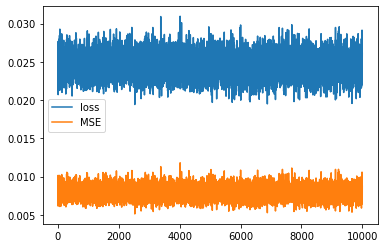

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


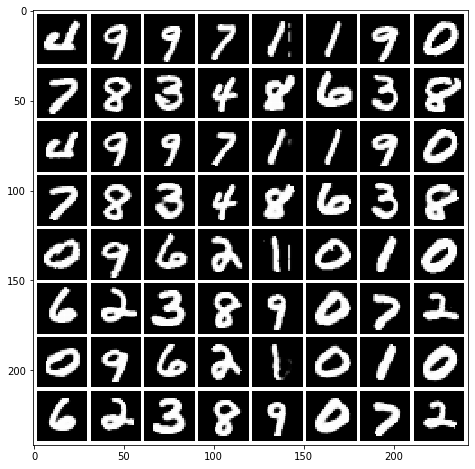

Mean squared dist: 0.008477766
epoch: 46 	 step:0 	 loss: 0.02431 	 reg loss: 0.001826
epoch: 46 	 step:100 	 loss: 0.02339 	 reg loss: 0.001838
epoch: 46 	 step:200 	 loss: 0.02559 	 reg loss: 0.001844
epoch: 46 	 step:300 	 loss: 0.02429 	 reg loss: 0.001755
epoch: 46 	 step:400 	 loss: 0.02429 	 reg loss: 0.001815
epoch: 46 	 step:500 	 loss: 0.02548 	 reg loss: 0.001791
epoch: 46 	 step:600 	 loss: 0.02417 	 reg loss: 0.001805
epoch: 46 	 step:700 	 loss: 0.02492 	 reg loss: 0.001812
epoch: 46 	 step:800 	 loss: 0.02019 	 reg loss: 0.001724
epoch: 46 	 step:900 	 loss: 0.02542 	 reg loss: 0.001875
epoch: 46 	 step:1000 	 loss: 0.0246 	 reg loss: 0.001835
epoch: 46 	 step:1100 	 loss: 0.02392 	 reg loss: 0.001753
epoch: 46 	 step:1200 	 loss: 0.02523 	 reg loss: 0.001766
epoch: 46 	 step:1300 	 loss: 0.02568 	 reg loss: 0.001832
epoch: 46 	 step:1400 	 loss: 0.02273 	 reg loss: 0.001751
epoch: 46 	 step:1500 	 loss: 0.02427 	 reg loss: 0.001749
epoch: 46 	 step:1600 	 loss: 0.02462 

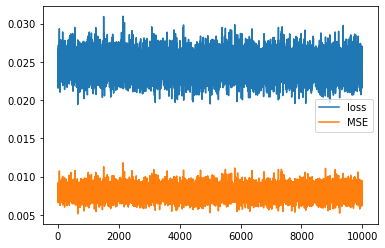

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


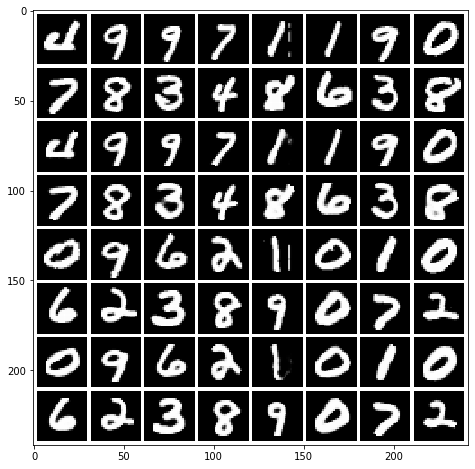

Mean squared dist: 0.008418111
epoch: 47 	 step:0 	 loss: 0.02496 	 reg loss: 0.001806
epoch: 47 	 step:100 	 loss: 0.02643 	 reg loss: 0.001846
epoch: 47 	 step:200 	 loss: 0.0259 	 reg loss: 0.00187
epoch: 47 	 step:300 	 loss: 0.02509 	 reg loss: 0.001828
epoch: 47 	 step:400 	 loss: 0.02592 	 reg loss: 0.001789
epoch: 47 	 step:500 	 loss: 0.02491 	 reg loss: 0.001829
epoch: 47 	 step:600 	 loss: 0.02743 	 reg loss: 0.001846
epoch: 47 	 step:700 	 loss: 0.02664 	 reg loss: 0.00183
epoch: 47 	 step:800 	 loss: 0.02389 	 reg loss: 0.001775
epoch: 47 	 step:900 	 loss: 0.02246 	 reg loss: 0.001763
epoch: 47 	 step:1000 	 loss: 0.02166 	 reg loss: 0.001714
epoch: 47 	 step:1100 	 loss: 0.02505 	 reg loss: 0.001799
epoch: 47 	 step:1200 	 loss: 0.0246 	 reg loss: 0.001811
epoch: 47 	 step:1300 	 loss: 0.0252 	 reg loss: 0.0018
epoch: 47 	 step:1400 	 loss: 0.0222 	 reg loss: 0.001804
epoch: 47 	 step:1500 	 loss: 0.025 	 reg loss: 0.00179
epoch: 47 	 step:1600 	 loss: 0.02608 	 reg loss

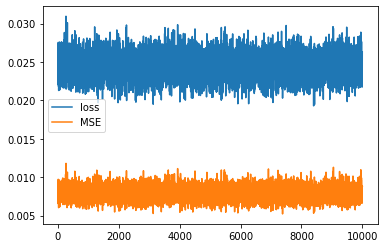

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


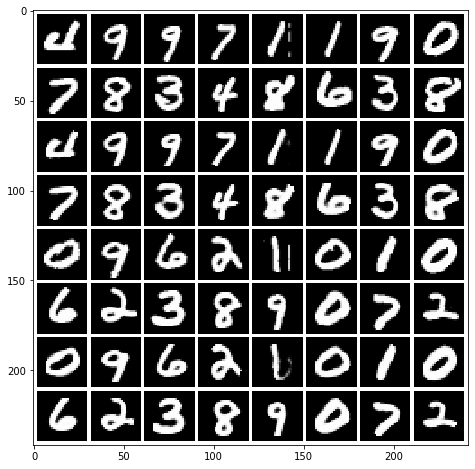

Mean squared dist: 0.008331276
epoch: 48 	 step:0 	 loss: 0.0242 	 reg loss: 0.001738
epoch: 48 	 step:100 	 loss: 0.02231 	 reg loss: 0.001756
epoch: 48 	 step:200 	 loss: 0.02428 	 reg loss: 0.001818
epoch: 48 	 step:300 	 loss: 0.02329 	 reg loss: 0.001792
epoch: 48 	 step:400 	 loss: 0.02495 	 reg loss: 0.001816
epoch: 48 	 step:500 	 loss: 0.02438 	 reg loss: 0.001815
epoch: 48 	 step:600 	 loss: 0.02581 	 reg loss: 0.001759
epoch: 48 	 step:700 	 loss: 0.02619 	 reg loss: 0.00181
epoch: 48 	 step:800 	 loss: 0.02775 	 reg loss: 0.001749
epoch: 48 	 step:900 	 loss: 0.02708 	 reg loss: 0.001868
epoch: 48 	 step:1000 	 loss: 0.02634 	 reg loss: 0.001815
epoch: 48 	 step:1100 	 loss: 0.02643 	 reg loss: 0.001832
epoch: 48 	 step:1200 	 loss: 0.02455 	 reg loss: 0.001732
epoch: 48 	 step:1300 	 loss: 0.02694 	 reg loss: 0.001771
epoch: 48 	 step:1400 	 loss: 0.02625 	 reg loss: 0.001795
epoch: 48 	 step:1500 	 loss: 0.02575 	 reg loss: 0.001793
epoch: 48 	 step:1600 	 loss: 0.02322 	

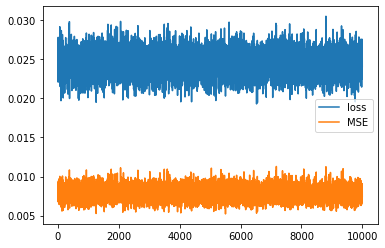

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


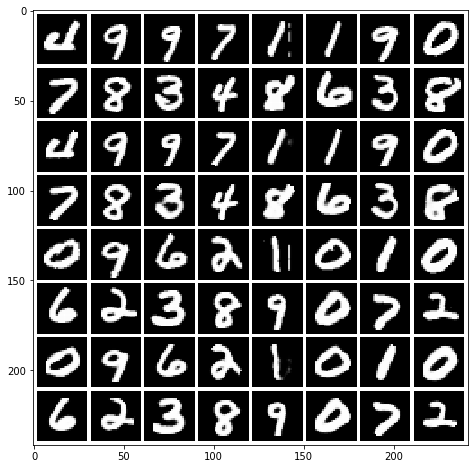

Mean squared dist: 0.008416132
epoch: 49 	 step:0 	 loss: 0.02406 	 reg loss: 0.001788
epoch: 49 	 step:100 	 loss: 0.02245 	 reg loss: 0.001768
epoch: 49 	 step:200 	 loss: 0.0253 	 reg loss: 0.001763
epoch: 49 	 step:300 	 loss: 0.02242 	 reg loss: 0.00181
epoch: 49 	 step:400 	 loss: 0.02472 	 reg loss: 0.001834
epoch: 49 	 step:500 	 loss: 0.02667 	 reg loss: 0.001843
epoch: 49 	 step:600 	 loss: 0.02461 	 reg loss: 0.001799
epoch: 49 	 step:700 	 loss: 0.02394 	 reg loss: 0.001844
epoch: 49 	 step:800 	 loss: 0.02573 	 reg loss: 0.00176
epoch: 49 	 step:900 	 loss: 0.02655 	 reg loss: 0.001782
epoch: 49 	 step:1000 	 loss: 0.02383 	 reg loss: 0.00181
epoch: 49 	 step:1100 	 loss: 0.02464 	 reg loss: 0.001783
epoch: 49 	 step:1200 	 loss: 0.02395 	 reg loss: 0.001809
epoch: 49 	 step:1300 	 loss: 0.02259 	 reg loss: 0.001798
epoch: 49 	 step:1400 	 loss: 0.02503 	 reg loss: 0.001782
epoch: 49 	 step:1500 	 loss: 0.02253 	 reg loss: 0.001733
epoch: 49 	 step:1600 	 loss: 0.02256 	 r

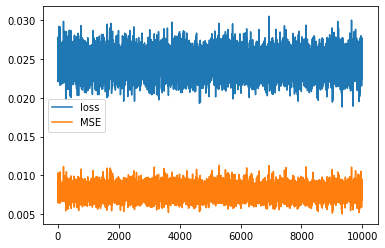

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


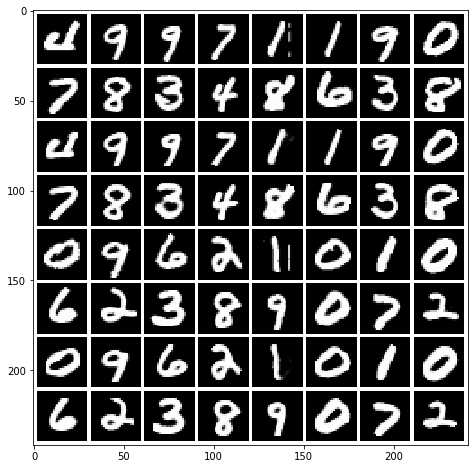

Mean squared dist: 0.008384251
epoch: 50 	 step:0 	 loss: 0.02478 	 reg loss: 0.001807
epoch: 50 	 step:100 	 loss: 0.02289 	 reg loss: 0.001771
epoch: 50 	 step:200 	 loss: 0.02436 	 reg loss: 0.001836
epoch: 50 	 step:300 	 loss: 0.02424 	 reg loss: 0.001805
epoch: 50 	 step:400 	 loss: 0.02581 	 reg loss: 0.001858
epoch: 50 	 step:500 	 loss: 0.02656 	 reg loss: 0.001759
epoch: 50 	 step:600 	 loss: 0.02419 	 reg loss: 0.001791
epoch: 50 	 step:700 	 loss: 0.0233 	 reg loss: 0.001766
epoch: 50 	 step:800 	 loss: 0.02299 	 reg loss: 0.001846
epoch: 50 	 step:900 	 loss: 0.02327 	 reg loss: 0.001771
epoch: 50 	 step:1000 	 loss: 0.02766 	 reg loss: 0.001855
epoch: 50 	 step:1100 	 loss: 0.0254 	 reg loss: 0.001861
epoch: 50 	 step:1200 	 loss: 0.02385 	 reg loss: 0.001753
epoch: 50 	 step:1300 	 loss: 0.02148 	 reg loss: 0.001722
epoch: 50 	 step:1400 	 loss: 0.02352 	 reg loss: 0.001795
epoch: 50 	 step:1500 	 loss: 0.02368 	 reg loss: 0.001798
epoch: 50 	 step:1600 	 loss: 0.02549 	

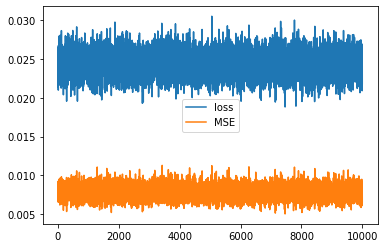

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


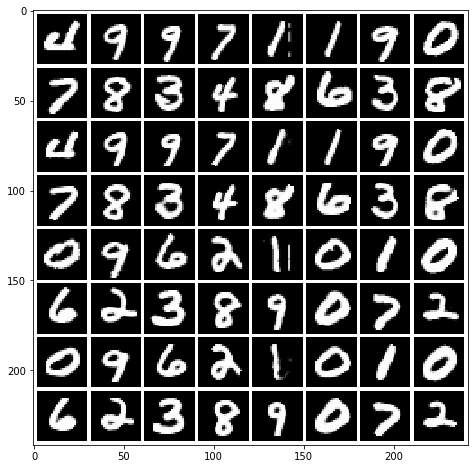

Mean squared dist: 0.008325514
epoch: 51 	 step:0 	 loss: 0.02516 	 reg loss: 0.001871
epoch: 51 	 step:100 	 loss: 0.02231 	 reg loss: 0.001773
epoch: 51 	 step:200 	 loss: 0.02196 	 reg loss: 0.001794
epoch: 51 	 step:300 	 loss: 0.02317 	 reg loss: 0.001836
epoch: 51 	 step:400 	 loss: 0.0199 	 reg loss: 0.001719
epoch: 51 	 step:500 	 loss: 0.02312 	 reg loss: 0.001784
epoch: 51 	 step:600 	 loss: 0.02456 	 reg loss: 0.001809
epoch: 51 	 step:700 	 loss: 0.02363 	 reg loss: 0.001804
epoch: 51 	 step:800 	 loss: 0.02268 	 reg loss: 0.001757
epoch: 51 	 step:900 	 loss: 0.02376 	 reg loss: 0.001758
epoch: 51 	 step:1000 	 loss: 0.02326 	 reg loss: 0.001804
epoch: 51 	 step:1100 	 loss: 0.02446 	 reg loss: 0.001778
epoch: 51 	 step:1200 	 loss: 0.02393 	 reg loss: 0.001759
epoch: 51 	 step:1300 	 loss: 0.02487 	 reg loss: 0.001823
epoch: 51 	 step:1400 	 loss: 0.02566 	 reg loss: 0.001803
epoch: 51 	 step:1500 	 loss: 0.02645 	 reg loss: 0.001849
epoch: 51 	 step:1600 	 loss: 0.02564 

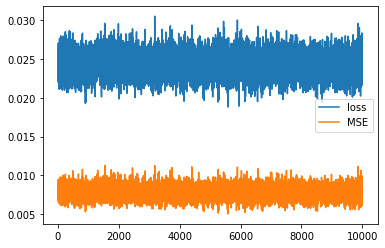

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


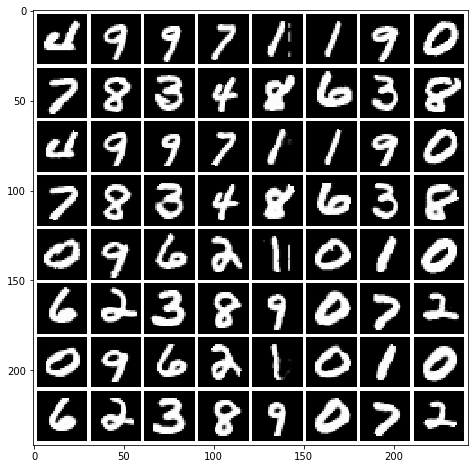

Mean squared dist: 0.008510002
epoch: 52 	 step:0 	 loss: 0.0246 	 reg loss: 0.001834
epoch: 52 	 step:100 	 loss: 0.0237 	 reg loss: 0.001768
epoch: 52 	 step:200 	 loss: 0.02298 	 reg loss: 0.001753
epoch: 52 	 step:300 	 loss: 0.02364 	 reg loss: 0.001789
epoch: 52 	 step:400 	 loss: 0.02357 	 reg loss: 0.001765
epoch: 52 	 step:500 	 loss: 0.02157 	 reg loss: 0.00178
epoch: 52 	 step:600 	 loss: 0.02518 	 reg loss: 0.001826
epoch: 52 	 step:700 	 loss: 0.0225 	 reg loss: 0.001814
epoch: 52 	 step:800 	 loss: 0.02439 	 reg loss: 0.00187
epoch: 52 	 step:900 	 loss: 0.02168 	 reg loss: 0.001812
epoch: 52 	 step:1000 	 loss: 0.0244 	 reg loss: 0.001828
epoch: 52 	 step:1100 	 loss: 0.02531 	 reg loss: 0.001803
epoch: 52 	 step:1200 	 loss: 0.02243 	 reg loss: 0.001775
epoch: 52 	 step:1300 	 loss: 0.02262 	 reg loss: 0.001743
epoch: 52 	 step:1400 	 loss: 0.02393 	 reg loss: 0.001793
epoch: 52 	 step:1500 	 loss: 0.02123 	 reg loss: 0.001789
epoch: 52 	 step:1600 	 loss: 0.02122 	 reg

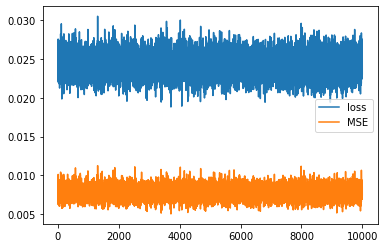

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


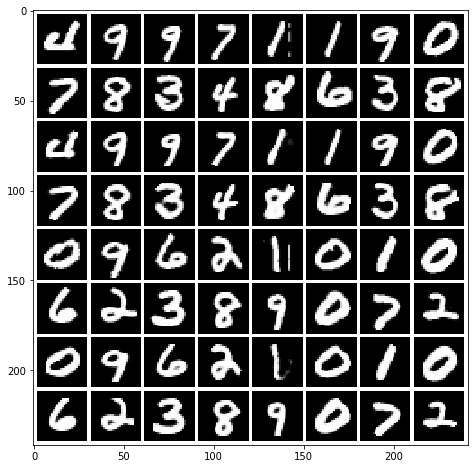

Mean squared dist: 0.00841593
epoch: 53 	 step:0 	 loss: 0.02275 	 reg loss: 0.001817
epoch: 53 	 step:100 	 loss: 0.02268 	 reg loss: 0.001823
epoch: 53 	 step:200 	 loss: 0.02359 	 reg loss: 0.001811
epoch: 53 	 step:300 	 loss: 0.02288 	 reg loss: 0.001776
epoch: 53 	 step:400 	 loss: 0.02609 	 reg loss: 0.00178
epoch: 53 	 step:500 	 loss: 0.02299 	 reg loss: 0.001783
epoch: 53 	 step:600 	 loss: 0.02368 	 reg loss: 0.001804
epoch: 53 	 step:700 	 loss: 0.02485 	 reg loss: 0.001802
epoch: 53 	 step:800 	 loss: 0.02368 	 reg loss: 0.001787
epoch: 53 	 step:900 	 loss: 0.02205 	 reg loss: 0.001745
epoch: 53 	 step:1000 	 loss: 0.0243 	 reg loss: 0.001839
epoch: 53 	 step:1100 	 loss: 0.02623 	 reg loss: 0.00183
epoch: 53 	 step:1200 	 loss: 0.02231 	 reg loss: 0.001755
epoch: 53 	 step:1300 	 loss: 0.02492 	 reg loss: 0.001799
epoch: 53 	 step:1400 	 loss: 0.02435 	 reg loss: 0.001785
epoch: 53 	 step:1500 	 loss: 0.02594 	 reg loss: 0.001832
epoch: 53 	 step:1600 	 loss: 0.02394 	 r

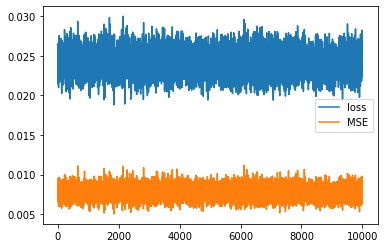

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


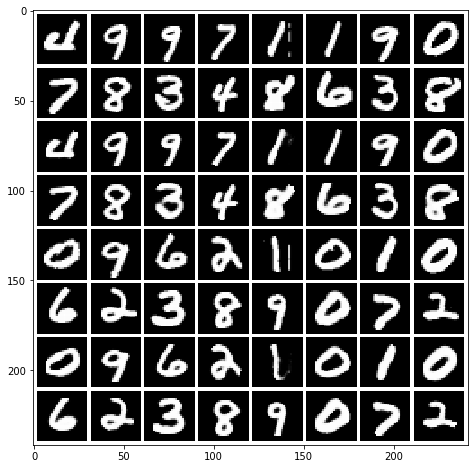

Mean squared dist: 0.008256997
epoch: 54 	 step:0 	 loss: 0.02191 	 reg loss: 0.001821
epoch: 54 	 step:100 	 loss: 0.02448 	 reg loss: 0.001842
epoch: 54 	 step:200 	 loss: 0.02285 	 reg loss: 0.001752
epoch: 54 	 step:300 	 loss: 0.02291 	 reg loss: 0.001768
epoch: 54 	 step:400 	 loss: 0.02389 	 reg loss: 0.001856
epoch: 54 	 step:500 	 loss: 0.02522 	 reg loss: 0.001827
epoch: 54 	 step:600 	 loss: 0.02616 	 reg loss: 0.001876
epoch: 54 	 step:700 	 loss: 0.02212 	 reg loss: 0.001719
epoch: 54 	 step:800 	 loss: 0.02497 	 reg loss: 0.001773
epoch: 54 	 step:900 	 loss: 0.0257 	 reg loss: 0.001791
epoch: 54 	 step:1000 	 loss: 0.02346 	 reg loss: 0.001809
epoch: 54 	 step:1100 	 loss: 0.02464 	 reg loss: 0.001788
epoch: 54 	 step:1200 	 loss: 0.02415 	 reg loss: 0.001866
epoch: 54 	 step:1300 	 loss: 0.02228 	 reg loss: 0.001742
epoch: 54 	 step:1400 	 loss: 0.01993 	 reg loss: 0.001766
epoch: 54 	 step:1500 	 loss: 0.02332 	 reg loss: 0.001745
epoch: 54 	 step:1600 	 loss: 0.02309 

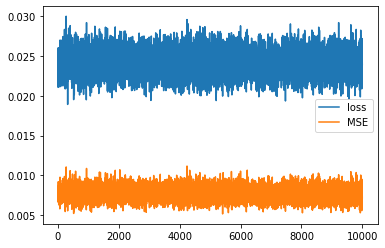

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


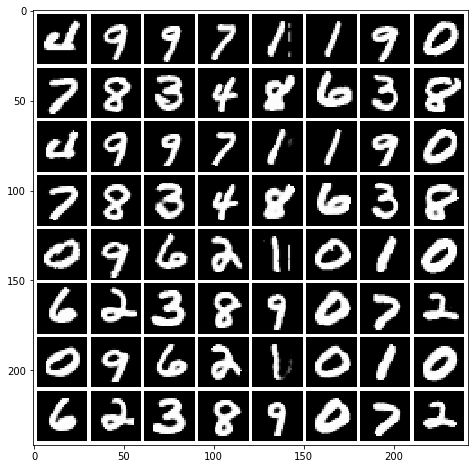

Mean squared dist: 0.008255973
epoch: 55 	 step:0 	 loss: 0.02338 	 reg loss: 0.001783
epoch: 55 	 step:100 	 loss: 0.02311 	 reg loss: 0.001931
epoch: 55 	 step:200 	 loss: 0.02326 	 reg loss: 0.001803
epoch: 55 	 step:300 	 loss: 0.02443 	 reg loss: 0.001834
epoch: 55 	 step:400 	 loss: 0.02313 	 reg loss: 0.001836
epoch: 55 	 step:500 	 loss: 0.02153 	 reg loss: 0.001741
epoch: 55 	 step:600 	 loss: 0.02363 	 reg loss: 0.001823
epoch: 55 	 step:700 	 loss: 0.02332 	 reg loss: 0.001811
epoch: 55 	 step:800 	 loss: 0.02389 	 reg loss: 0.001835
epoch: 55 	 step:900 	 loss: 0.02455 	 reg loss: 0.001825
epoch: 55 	 step:1000 	 loss: 0.02354 	 reg loss: 0.001812
epoch: 55 	 step:1100 	 loss: 0.02439 	 reg loss: 0.001825
epoch: 55 	 step:1200 	 loss: 0.02104 	 reg loss: 0.001688
epoch: 55 	 step:1300 	 loss: 0.02477 	 reg loss: 0.001791
epoch: 55 	 step:1400 	 loss: 0.02663 	 reg loss: 0.001858
epoch: 55 	 step:1500 	 loss: 0.02447 	 reg loss: 0.001784
epoch: 55 	 step:1600 	 loss: 0.02464

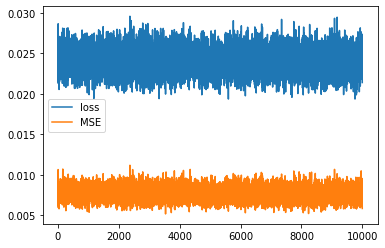

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


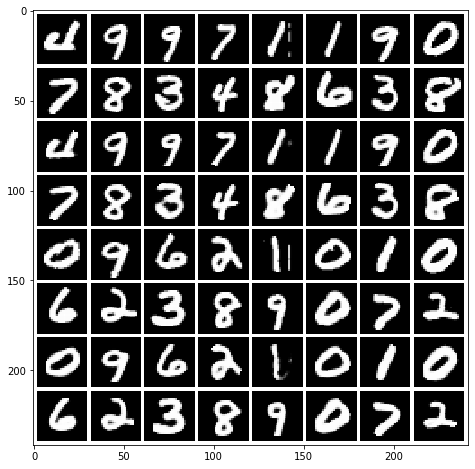

Mean squared dist: 0.008223204
epoch: 56 	 step:0 	 loss: 0.02513 	 reg loss: 0.001806
epoch: 56 	 step:100 	 loss: 0.02415 	 reg loss: 0.001809
epoch: 56 	 step:200 	 loss: 0.0236 	 reg loss: 0.001831
epoch: 56 	 step:300 	 loss: 0.02201 	 reg loss: 0.001789
epoch: 56 	 step:400 	 loss: 0.02164 	 reg loss: 0.001761
epoch: 56 	 step:500 	 loss: 0.02294 	 reg loss: 0.001747
epoch: 56 	 step:600 	 loss: 0.02251 	 reg loss: 0.001792
epoch: 56 	 step:700 	 loss: 0.02313 	 reg loss: 0.001816
epoch: 56 	 step:800 	 loss: 0.02427 	 reg loss: 0.001826
epoch: 56 	 step:900 	 loss: 0.02474 	 reg loss: 0.001803
epoch: 56 	 step:1000 	 loss: 0.02493 	 reg loss: 0.001817
epoch: 56 	 step:1100 	 loss: 0.02594 	 reg loss: 0.001845
epoch: 56 	 step:1200 	 loss: 0.02431 	 reg loss: 0.001798
epoch: 56 	 step:1300 	 loss: 0.02416 	 reg loss: 0.001831
epoch: 56 	 step:1400 	 loss: 0.02195 	 reg loss: 0.001781
epoch: 56 	 step:1500 	 loss: 0.02333 	 reg loss: 0.001794
epoch: 56 	 step:1600 	 loss: 0.02712 

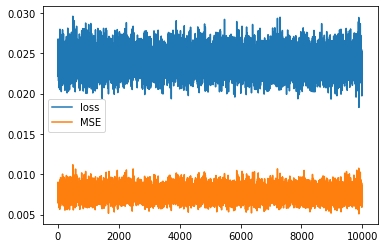

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


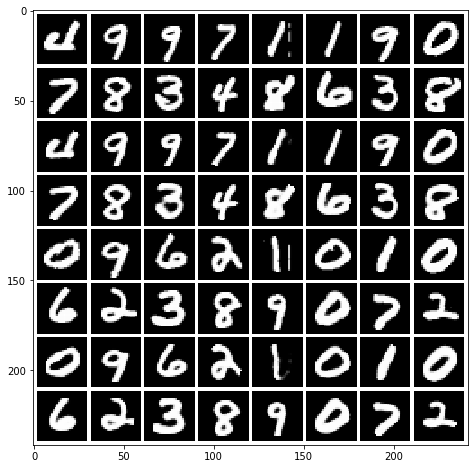

Mean squared dist: 0.008109854
epoch: 57 	 step:0 	 loss: 0.0226 	 reg loss: 0.001753
epoch: 57 	 step:100 	 loss: 0.02163 	 reg loss: 0.001739
epoch: 57 	 step:200 	 loss: 0.02368 	 reg loss: 0.00183
epoch: 57 	 step:300 	 loss: 0.02687 	 reg loss: 0.001801
epoch: 57 	 step:400 	 loss: 0.02426 	 reg loss: 0.001815
epoch: 57 	 step:500 	 loss: 0.02545 	 reg loss: 0.001793
epoch: 57 	 step:600 	 loss: 0.02401 	 reg loss: 0.001777
epoch: 57 	 step:700 	 loss: 0.02353 	 reg loss: 0.001775
epoch: 57 	 step:800 	 loss: 0.02522 	 reg loss: 0.001841
epoch: 57 	 step:900 	 loss: 0.02564 	 reg loss: 0.001816
epoch: 57 	 step:1000 	 loss: 0.02275 	 reg loss: 0.001842
epoch: 57 	 step:1100 	 loss: 0.02827 	 reg loss: 0.001805
epoch: 57 	 step:1200 	 loss: 0.02109 	 reg loss: 0.001759
epoch: 57 	 step:1300 	 loss: 0.0239 	 reg loss: 0.001786
epoch: 57 	 step:1400 	 loss: 0.02356 	 reg loss: 0.001821
epoch: 57 	 step:1500 	 loss: 0.02435 	 reg loss: 0.001839
epoch: 57 	 step:1600 	 loss: 0.02365 	 

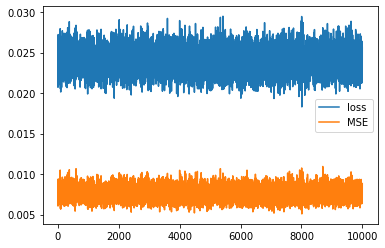

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


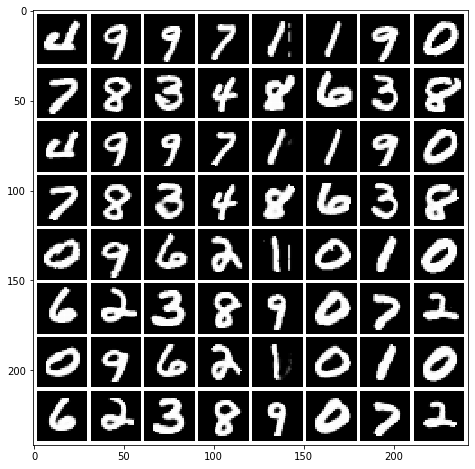

Mean squared dist: 0.008246666
epoch: 58 	 step:0 	 loss: 0.0229 	 reg loss: 0.001837
epoch: 58 	 step:100 	 loss: 0.0255 	 reg loss: 0.001777
epoch: 58 	 step:200 	 loss: 0.02549 	 reg loss: 0.001813
epoch: 58 	 step:300 	 loss: 0.02323 	 reg loss: 0.001759
epoch: 58 	 step:400 	 loss: 0.02184 	 reg loss: 0.001809
epoch: 58 	 step:500 	 loss: 0.02616 	 reg loss: 0.001877
epoch: 58 	 step:600 	 loss: 0.0233 	 reg loss: 0.001798
epoch: 58 	 step:700 	 loss: 0.02439 	 reg loss: 0.001758
epoch: 58 	 step:800 	 loss: 0.0215 	 reg loss: 0.001754
epoch: 58 	 step:900 	 loss: 0.0252 	 reg loss: 0.001777
epoch: 58 	 step:1000 	 loss: 0.02361 	 reg loss: 0.001802
epoch: 58 	 step:1100 	 loss: 0.02365 	 reg loss: 0.001792
epoch: 58 	 step:1200 	 loss: 0.02513 	 reg loss: 0.001809
epoch: 58 	 step:1300 	 loss: 0.02609 	 reg loss: 0.001823
epoch: 58 	 step:1400 	 loss: 0.02286 	 reg loss: 0.001782
epoch: 58 	 step:1500 	 loss: 0.0244 	 reg loss: 0.001816
epoch: 58 	 step:1600 	 loss: 0.02301 	 reg

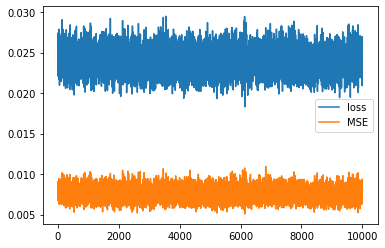

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


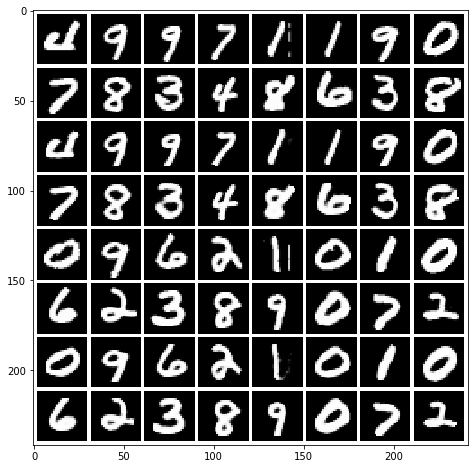

Mean squared dist: 0.008349788
epoch: 59 	 step:0 	 loss: 0.02382 	 reg loss: 0.001777
epoch: 59 	 step:100 	 loss: 0.02247 	 reg loss: 0.001776
epoch: 59 	 step:200 	 loss: 0.02267 	 reg loss: 0.001819
epoch: 59 	 step:300 	 loss: 0.0268 	 reg loss: 0.001908
epoch: 59 	 step:400 	 loss: 0.02405 	 reg loss: 0.00177
epoch: 59 	 step:500 	 loss: 0.02501 	 reg loss: 0.001801
epoch: 59 	 step:600 	 loss: 0.02521 	 reg loss: 0.001804
epoch: 59 	 step:700 	 loss: 0.02601 	 reg loss: 0.0019
epoch: 59 	 step:800 	 loss: 0.02335 	 reg loss: 0.00184
epoch: 59 	 step:900 	 loss: 0.02331 	 reg loss: 0.001822
epoch: 59 	 step:1000 	 loss: 0.02586 	 reg loss: 0.001832
epoch: 59 	 step:1100 	 loss: 0.02341 	 reg loss: 0.001817
epoch: 59 	 step:1200 	 loss: 0.02307 	 reg loss: 0.001795
epoch: 59 	 step:1300 	 loss: 0.02569 	 reg loss: 0.001863
epoch: 59 	 step:1400 	 loss: 0.02404 	 reg loss: 0.001787
epoch: 59 	 step:1500 	 loss: 0.0232 	 reg loss: 0.001753
epoch: 59 	 step:1600 	 loss: 0.02382 	 reg

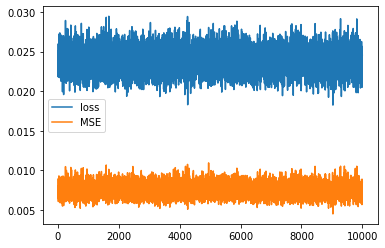

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


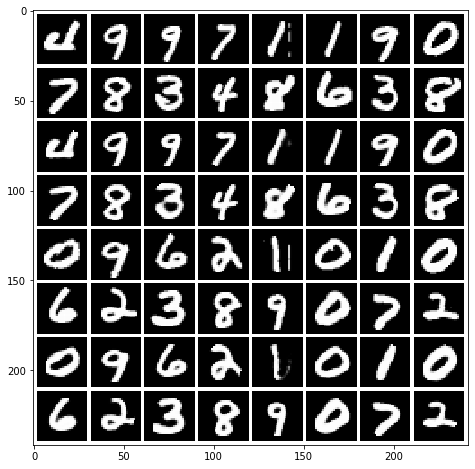

Mean squared dist: 0.008142325
epoch: 60 	 step:0 	 loss: 0.02274 	 reg loss: 0.001827
epoch: 60 	 step:100 	 loss: 0.0225 	 reg loss: 0.001767
epoch: 60 	 step:200 	 loss: 0.02054 	 reg loss: 0.001719
epoch: 60 	 step:300 	 loss: 0.02409 	 reg loss: 0.00185
epoch: 60 	 step:400 	 loss: 0.02439 	 reg loss: 0.00177
epoch: 60 	 step:500 	 loss: 0.02249 	 reg loss: 0.001811
epoch: 60 	 step:600 	 loss: 0.02494 	 reg loss: 0.001744
epoch: 60 	 step:700 	 loss: 0.02442 	 reg loss: 0.00179
epoch: 60 	 step:800 	 loss: 0.0225 	 reg loss: 0.001785
epoch: 60 	 step:900 	 loss: 0.02356 	 reg loss: 0.00185
epoch: 60 	 step:1000 	 loss: 0.0222 	 reg loss: 0.001778
epoch: 60 	 step:1100 	 loss: 0.02215 	 reg loss: 0.001737
epoch: 60 	 step:1200 	 loss: 0.02271 	 reg loss: 0.001833
epoch: 60 	 step:1300 	 loss: 0.02389 	 reg loss: 0.001797
epoch: 60 	 step:1400 	 loss: 0.02309 	 reg loss: 0.001716
epoch: 60 	 step:1500 	 loss: 0.0246 	 reg loss: 0.001777
epoch: 60 	 step:1600 	 loss: 0.02137 	 reg l

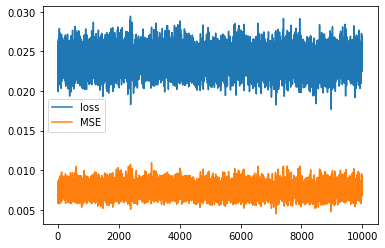

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


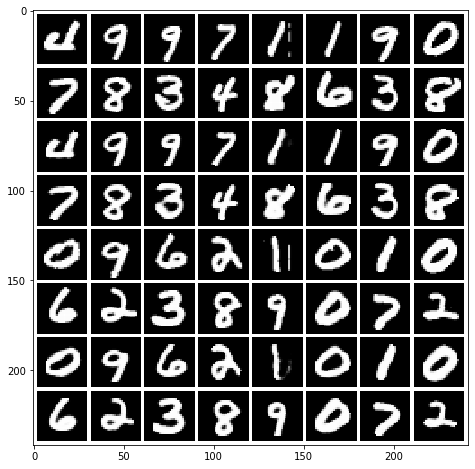

Mean squared dist: 0.008055141
epoch: 61 	 step:0 	 loss: 0.02402 	 reg loss: 0.001764
epoch: 61 	 step:100 	 loss: 0.02359 	 reg loss: 0.00184
epoch: 61 	 step:200 	 loss: 0.02401 	 reg loss: 0.001822
epoch: 61 	 step:300 	 loss: 0.02318 	 reg loss: 0.001843
epoch: 61 	 step:400 	 loss: 0.02476 	 reg loss: 0.001854
epoch: 61 	 step:500 	 loss: 0.02273 	 reg loss: 0.001826
epoch: 61 	 step:600 	 loss: 0.02484 	 reg loss: 0.001861
epoch: 61 	 step:700 	 loss: 0.02515 	 reg loss: 0.001814
epoch: 61 	 step:800 	 loss: 0.02453 	 reg loss: 0.001839
epoch: 61 	 step:900 	 loss: 0.02462 	 reg loss: 0.001795
epoch: 61 	 step:1000 	 loss: 0.02437 	 reg loss: 0.001758
epoch: 61 	 step:1100 	 loss: 0.02217 	 reg loss: 0.001752
epoch: 61 	 step:1200 	 loss: 0.02364 	 reg loss: 0.001834
epoch: 61 	 step:1300 	 loss: 0.02358 	 reg loss: 0.001802
epoch: 61 	 step:1400 	 loss: 0.02168 	 reg loss: 0.001799
epoch: 61 	 step:1500 	 loss: 0.02645 	 reg loss: 0.001859
epoch: 61 	 step:1600 	 loss: 0.02394 

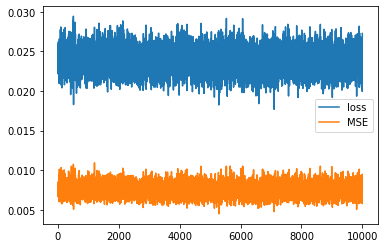

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


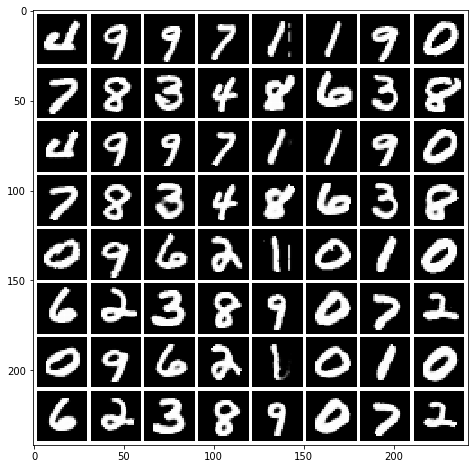

Mean squared dist: 0.008043005
epoch: 62 	 step:0 	 loss: 0.02534 	 reg loss: 0.001827
epoch: 62 	 step:100 	 loss: 0.02224 	 reg loss: 0.001802
epoch: 62 	 step:200 	 loss: 0.02118 	 reg loss: 0.001774
epoch: 62 	 step:300 	 loss: 0.02175 	 reg loss: 0.00174
epoch: 62 	 step:400 	 loss: 0.02344 	 reg loss: 0.001788
epoch: 62 	 step:500 	 loss: 0.02311 	 reg loss: 0.001777
epoch: 62 	 step:600 	 loss: 0.0225 	 reg loss: 0.001747
epoch: 62 	 step:700 	 loss: 0.0232 	 reg loss: 0.001828
epoch: 62 	 step:800 	 loss: 0.02127 	 reg loss: 0.001731
epoch: 62 	 step:900 	 loss: 0.02422 	 reg loss: 0.001874
epoch: 62 	 step:1000 	 loss: 0.02459 	 reg loss: 0.001795
epoch: 62 	 step:1100 	 loss: 0.02196 	 reg loss: 0.001817
epoch: 62 	 step:1200 	 loss: 0.02348 	 reg loss: 0.001776
epoch: 62 	 step:1300 	 loss: 0.02394 	 reg loss: 0.001837
epoch: 62 	 step:1400 	 loss: 0.02271 	 reg loss: 0.001807
epoch: 62 	 step:1500 	 loss: 0.02642 	 reg loss: 0.001773
epoch: 62 	 step:1600 	 loss: 0.02417 	 

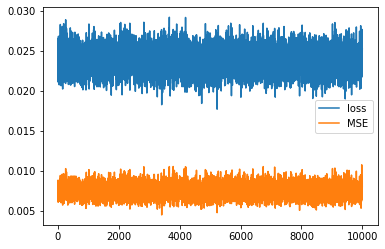

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


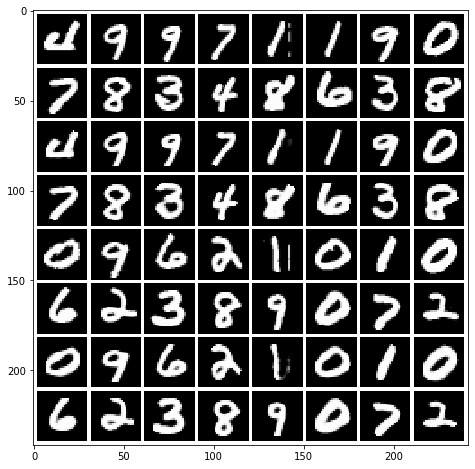

Mean squared dist: 0.008101653
epoch: 63 	 step:0 	 loss: 0.02359 	 reg loss: 0.001721
epoch: 63 	 step:100 	 loss: 0.02389 	 reg loss: 0.001763
epoch: 63 	 step:200 	 loss: 0.02184 	 reg loss: 0.001835
epoch: 63 	 step:300 	 loss: 0.02277 	 reg loss: 0.001788
epoch: 63 	 step:400 	 loss: 0.0233 	 reg loss: 0.001825
epoch: 63 	 step:500 	 loss: 0.02307 	 reg loss: 0.00181
epoch: 63 	 step:600 	 loss: 0.02264 	 reg loss: 0.001777
epoch: 63 	 step:700 	 loss: 0.02372 	 reg loss: 0.001826
epoch: 63 	 step:800 	 loss: 0.023 	 reg loss: 0.001781
epoch: 63 	 step:900 	 loss: 0.02319 	 reg loss: 0.001796
epoch: 63 	 step:1000 	 loss: 0.02399 	 reg loss: 0.001808
epoch: 63 	 step:1100 	 loss: 0.02442 	 reg loss: 0.001854
epoch: 63 	 step:1200 	 loss: 0.02256 	 reg loss: 0.001817
epoch: 63 	 step:1300 	 loss: 0.02332 	 reg loss: 0.00177
epoch: 63 	 step:1400 	 loss: 0.02539 	 reg loss: 0.001807
epoch: 63 	 step:1500 	 loss: 0.02575 	 reg loss: 0.001837
epoch: 63 	 step:1600 	 loss: 0.02151 	 re

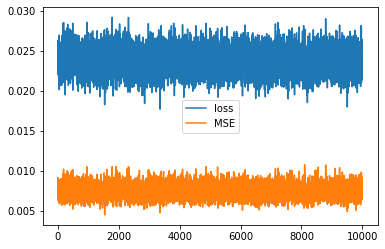

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


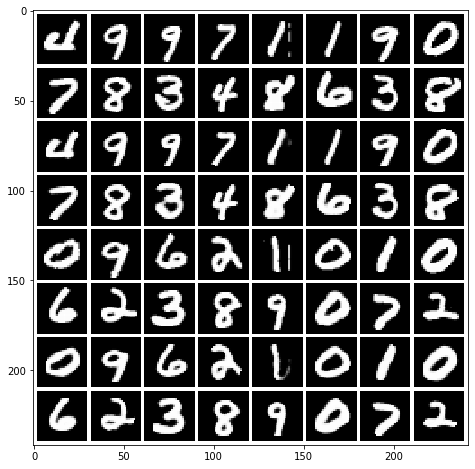

Mean squared dist: 0.008029371
epoch: 64 	 step:0 	 loss: 0.02126 	 reg loss: 0.001736
epoch: 64 	 step:100 	 loss: 0.02348 	 reg loss: 0.001823
epoch: 64 	 step:200 	 loss: 0.02357 	 reg loss: 0.001816
epoch: 64 	 step:300 	 loss: 0.02242 	 reg loss: 0.001757
epoch: 64 	 step:400 	 loss: 0.02402 	 reg loss: 0.001803
epoch: 64 	 step:500 	 loss: 0.0213 	 reg loss: 0.001747
epoch: 64 	 step:600 	 loss: 0.02334 	 reg loss: 0.001827
epoch: 64 	 step:700 	 loss: 0.02455 	 reg loss: 0.001802
epoch: 64 	 step:800 	 loss: 0.02352 	 reg loss: 0.001769
epoch: 64 	 step:900 	 loss: 0.02401 	 reg loss: 0.001823
epoch: 64 	 step:1000 	 loss: 0.02391 	 reg loss: 0.001777
epoch: 64 	 step:1100 	 loss: 0.02288 	 reg loss: 0.001797
epoch: 64 	 step:1200 	 loss: 0.02572 	 reg loss: 0.001853
epoch: 64 	 step:1300 	 loss: 0.02491 	 reg loss: 0.001847
epoch: 64 	 step:1400 	 loss: 0.02165 	 reg loss: 0.001785
epoch: 64 	 step:1500 	 loss: 0.02371 	 reg loss: 0.001829
epoch: 64 	 step:1600 	 loss: 0.02567 

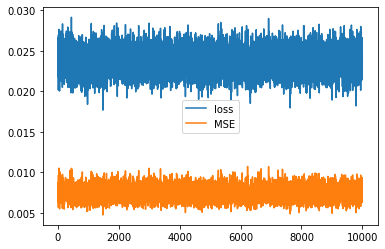

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


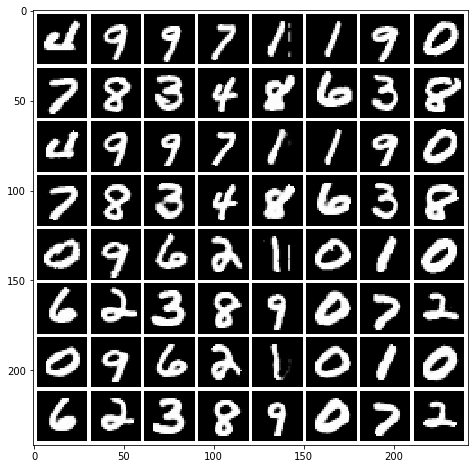

Mean squared dist: 0.0080485
epoch: 65 	 step:0 	 loss: 0.02044 	 reg loss: 0.001791
epoch: 65 	 step:100 	 loss: 0.02255 	 reg loss: 0.001799
epoch: 65 	 step:200 	 loss: 0.02502 	 reg loss: 0.001872
epoch: 65 	 step:300 	 loss: 0.02365 	 reg loss: 0.001802
epoch: 65 	 step:400 	 loss: 0.02498 	 reg loss: 0.001768
epoch: 65 	 step:500 	 loss: 0.02234 	 reg loss: 0.001841
epoch: 65 	 step:600 	 loss: 0.02282 	 reg loss: 0.001781
epoch: 65 	 step:700 	 loss: 0.02395 	 reg loss: 0.001757
epoch: 65 	 step:800 	 loss: 0.02106 	 reg loss: 0.001791
epoch: 65 	 step:900 	 loss: 0.02553 	 reg loss: 0.001805
epoch: 65 	 step:1000 	 loss: 0.02576 	 reg loss: 0.001835
epoch: 65 	 step:1100 	 loss: 0.02516 	 reg loss: 0.001855
epoch: 65 	 step:1200 	 loss: 0.02241 	 reg loss: 0.001831
epoch: 65 	 step:1300 	 loss: 0.02335 	 reg loss: 0.001847
epoch: 65 	 step:1400 	 loss: 0.02212 	 reg loss: 0.001769
epoch: 65 	 step:1500 	 loss: 0.02439 	 reg loss: 0.001834
epoch: 65 	 step:1600 	 loss: 0.02332 	

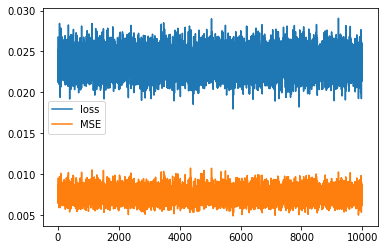

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


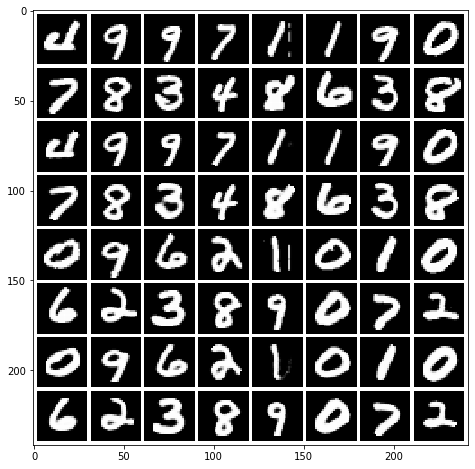

Mean squared dist: 0.007981914
epoch: 66 	 step:0 	 loss: 0.02512 	 reg loss: 0.00183
epoch: 66 	 step:100 	 loss: 0.02562 	 reg loss: 0.001845
epoch: 66 	 step:200 	 loss: 0.023 	 reg loss: 0.001782
epoch: 66 	 step:300 	 loss: 0.02184 	 reg loss: 0.001807
epoch: 66 	 step:400 	 loss: 0.02314 	 reg loss: 0.001822
epoch: 66 	 step:500 	 loss: 0.0242 	 reg loss: 0.001767
epoch: 66 	 step:600 	 loss: 0.0239 	 reg loss: 0.001842
epoch: 66 	 step:700 	 loss: 0.02385 	 reg loss: 0.001875
epoch: 66 	 step:800 	 loss: 0.02299 	 reg loss: 0.001813
epoch: 66 	 step:900 	 loss: 0.0233 	 reg loss: 0.0018
epoch: 66 	 step:1000 	 loss: 0.02434 	 reg loss: 0.001776
epoch: 66 	 step:1100 	 loss: 0.02553 	 reg loss: 0.001861
epoch: 66 	 step:1200 	 loss: 0.02301 	 reg loss: 0.001824
epoch: 66 	 step:1300 	 loss: 0.02496 	 reg loss: 0.001803
epoch: 66 	 step:1400 	 loss: 0.02574 	 reg loss: 0.001845
epoch: 66 	 step:1500 	 loss: 0.02588 	 reg loss: 0.001858
epoch: 66 	 step:1600 	 loss: 0.02281 	 reg l

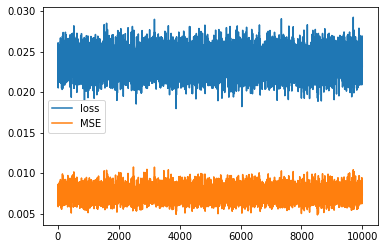

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


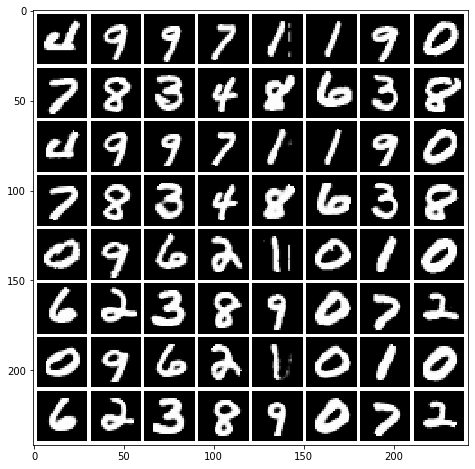

Mean squared dist: 0.007992274
epoch: 67 	 step:0 	 loss: 0.02201 	 reg loss: 0.00173
epoch: 67 	 step:100 	 loss: 0.02244 	 reg loss: 0.001874
epoch: 67 	 step:200 	 loss: 0.02098 	 reg loss: 0.001778
epoch: 67 	 step:300 	 loss: 0.02257 	 reg loss: 0.001826
epoch: 67 	 step:400 	 loss: 0.02221 	 reg loss: 0.001785
epoch: 67 	 step:500 	 loss: 0.02448 	 reg loss: 0.001861
epoch: 67 	 step:600 	 loss: 0.02482 	 reg loss: 0.001817
epoch: 67 	 step:700 	 loss: 0.02572 	 reg loss: 0.001827
epoch: 67 	 step:800 	 loss: 0.02507 	 reg loss: 0.001841
epoch: 67 	 step:900 	 loss: 0.02179 	 reg loss: 0.001745
epoch: 67 	 step:1000 	 loss: 0.02244 	 reg loss: 0.001803
epoch: 67 	 step:1100 	 loss: 0.02606 	 reg loss: 0.001834
epoch: 67 	 step:1200 	 loss: 0.02379 	 reg loss: 0.00182
epoch: 67 	 step:1300 	 loss: 0.02385 	 reg loss: 0.001867
epoch: 67 	 step:1400 	 loss: 0.02254 	 reg loss: 0.001858
epoch: 67 	 step:1500 	 loss: 0.02361 	 reg loss: 0.00181
epoch: 67 	 step:1600 	 loss: 0.02163 	 

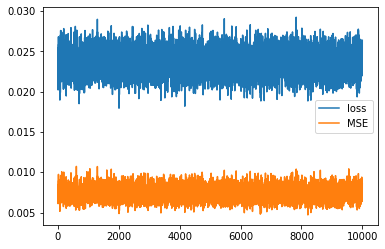

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


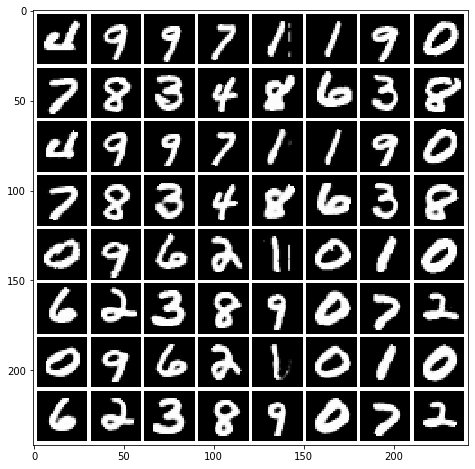

Mean squared dist: 0.007985391
epoch: 68 	 step:0 	 loss: 0.02549 	 reg loss: 0.001845
epoch: 68 	 step:100 	 loss: 0.02327 	 reg loss: 0.001816
epoch: 68 	 step:200 	 loss: 0.02226 	 reg loss: 0.001823
epoch: 68 	 step:300 	 loss: 0.0206 	 reg loss: 0.00181
epoch: 68 	 step:400 	 loss: 0.02283 	 reg loss: 0.001764
epoch: 68 	 step:500 	 loss: 0.02652 	 reg loss: 0.001805
epoch: 68 	 step:600 	 loss: 0.02433 	 reg loss: 0.001826
epoch: 68 	 step:700 	 loss: 0.02608 	 reg loss: 0.001846
epoch: 68 	 step:800 	 loss: 0.02152 	 reg loss: 0.001772
epoch: 68 	 step:900 	 loss: 0.02341 	 reg loss: 0.001821
epoch: 68 	 step:1000 	 loss: 0.02118 	 reg loss: 0.001793
epoch: 68 	 step:1100 	 loss: 0.02308 	 reg loss: 0.001755
epoch: 68 	 step:1200 	 loss: 0.02435 	 reg loss: 0.001824
epoch: 68 	 step:1300 	 loss: 0.02243 	 reg loss: 0.001829
epoch: 68 	 step:1400 	 loss: 0.02425 	 reg loss: 0.001866
epoch: 68 	 step:1500 	 loss: 0.02164 	 reg loss: 0.001819
epoch: 68 	 step:1600 	 loss: 0.02474 	

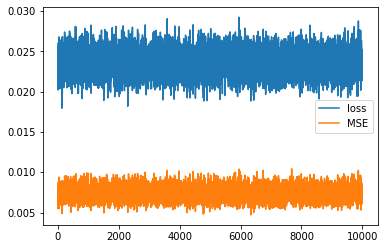

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


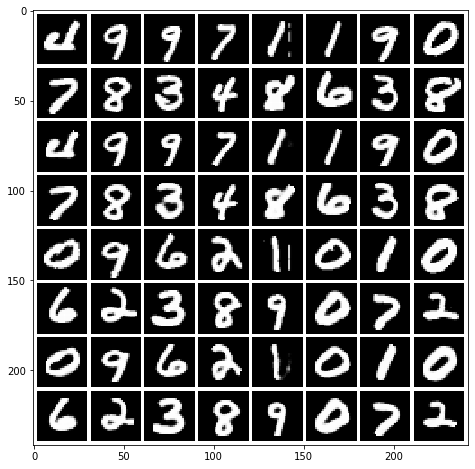

Mean squared dist: 0.008073544
epoch: 69 	 step:0 	 loss: 0.02363 	 reg loss: 0.001828
epoch: 69 	 step:100 	 loss: 0.02112 	 reg loss: 0.001774
epoch: 69 	 step:200 	 loss: 0.0265 	 reg loss: 0.001847
epoch: 69 	 step:300 	 loss: 0.02275 	 reg loss: 0.001778
epoch: 69 	 step:400 	 loss: 0.02336 	 reg loss: 0.001819
epoch: 69 	 step:500 	 loss: 0.02604 	 reg loss: 0.001806
epoch: 69 	 step:600 	 loss: 0.02465 	 reg loss: 0.001829
epoch: 69 	 step:700 	 loss: 0.02216 	 reg loss: 0.00179
epoch: 69 	 step:800 	 loss: 0.02402 	 reg loss: 0.001768
epoch: 69 	 step:900 	 loss: 0.02188 	 reg loss: 0.001752
epoch: 69 	 step:1000 	 loss: 0.02593 	 reg loss: 0.001806
epoch: 69 	 step:1100 	 loss: 0.0228 	 reg loss: 0.001805
epoch: 69 	 step:1200 	 loss: 0.02375 	 reg loss: 0.00182
epoch: 69 	 step:1300 	 loss: 0.02449 	 reg loss: 0.001795
epoch: 69 	 step:1400 	 loss: 0.02294 	 reg loss: 0.001833
epoch: 69 	 step:1500 	 loss: 0.02423 	 reg loss: 0.001799
epoch: 69 	 step:1600 	 loss: 0.02471 	 r

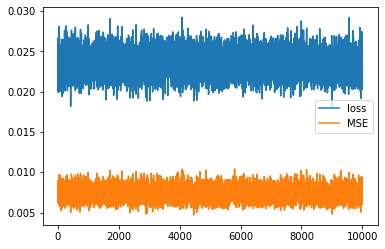

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


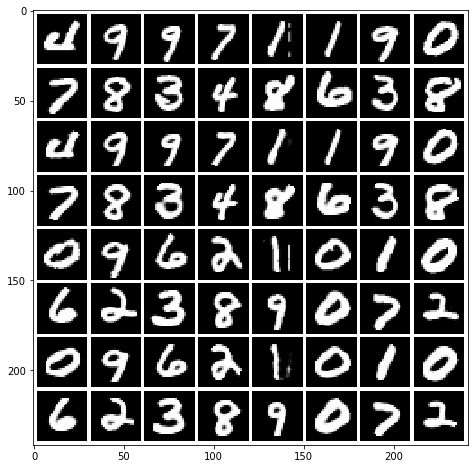

Mean squared dist: 0.008097535
epoch: 70 	 step:0 	 loss: 0.0241 	 reg loss: 0.001758
epoch: 70 	 step:100 	 loss: 0.02488 	 reg loss: 0.001837
epoch: 70 	 step:200 	 loss: 0.02157 	 reg loss: 0.001817
epoch: 70 	 step:300 	 loss: 0.02417 	 reg loss: 0.00182
epoch: 70 	 step:400 	 loss: 0.02151 	 reg loss: 0.001797
epoch: 70 	 step:500 	 loss: 0.02307 	 reg loss: 0.001837
epoch: 70 	 step:600 	 loss: 0.02335 	 reg loss: 0.001804
epoch: 70 	 step:700 	 loss: 0.02307 	 reg loss: 0.001819
epoch: 70 	 step:800 	 loss: 0.02439 	 reg loss: 0.001818
epoch: 70 	 step:900 	 loss: 0.02395 	 reg loss: 0.001829
epoch: 70 	 step:1000 	 loss: 0.02293 	 reg loss: 0.001808
epoch: 70 	 step:1100 	 loss: 0.02433 	 reg loss: 0.001757
epoch: 70 	 step:1200 	 loss: 0.02291 	 reg loss: 0.001812
epoch: 70 	 step:1300 	 loss: 0.02312 	 reg loss: 0.0017
epoch: 70 	 step:1400 	 loss: 0.02486 	 reg loss: 0.001867
epoch: 70 	 step:1500 	 loss: 0.02522 	 reg loss: 0.001817
epoch: 70 	 step:1600 	 loss: 0.02312 	 r

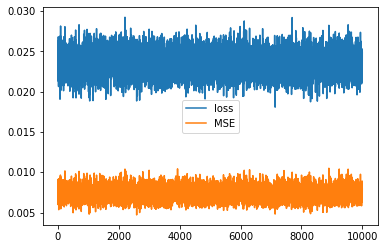

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


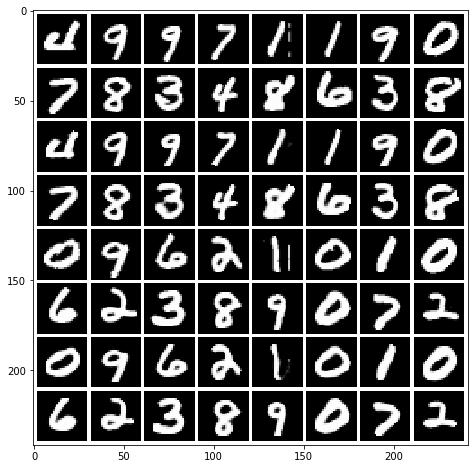

Mean squared dist: 0.008049542
epoch: 71 	 step:0 	 loss: 0.02359 	 reg loss: 0.001838
epoch: 71 	 step:100 	 loss: 0.02661 	 reg loss: 0.001868
epoch: 71 	 step:200 	 loss: 0.02281 	 reg loss: 0.001823
epoch: 71 	 step:300 	 loss: 0.02365 	 reg loss: 0.001795
epoch: 71 	 step:400 	 loss: 0.02288 	 reg loss: 0.001774
epoch: 71 	 step:500 	 loss: 0.02335 	 reg loss: 0.00177
epoch: 71 	 step:600 	 loss: 0.02383 	 reg loss: 0.001823
epoch: 71 	 step:700 	 loss: 0.02275 	 reg loss: 0.001851
epoch: 71 	 step:800 	 loss: 0.02343 	 reg loss: 0.001823
epoch: 71 	 step:900 	 loss: 0.02447 	 reg loss: 0.001795
epoch: 71 	 step:1000 	 loss: 0.02422 	 reg loss: 0.001797
epoch: 71 	 step:1100 	 loss: 0.02609 	 reg loss: 0.001838
epoch: 71 	 step:1200 	 loss: 0.0255 	 reg loss: 0.001822
epoch: 71 	 step:1300 	 loss: 0.0232 	 reg loss: 0.001797
epoch: 71 	 step:1400 	 loss: 0.02282 	 reg loss: 0.001758
epoch: 71 	 step:1500 	 loss: 0.02046 	 reg loss: 0.001753
epoch: 71 	 step:1600 	 loss: 0.0214 	 r

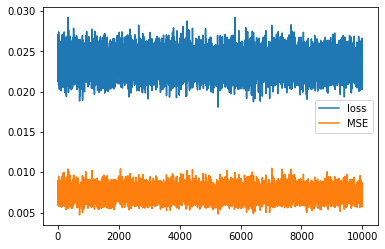

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


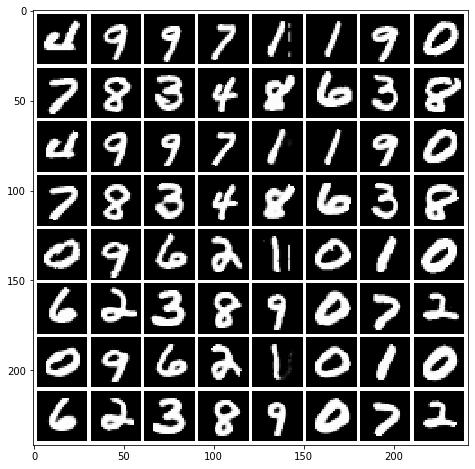

Mean squared dist: 0.007910391
epoch: 72 	 step:0 	 loss: 0.02269 	 reg loss: 0.001751
epoch: 72 	 step:100 	 loss: 0.02387 	 reg loss: 0.00187
epoch: 72 	 step:200 	 loss: 0.02244 	 reg loss: 0.001802
epoch: 72 	 step:300 	 loss: 0.02276 	 reg loss: 0.001801
epoch: 72 	 step:400 	 loss: 0.02384 	 reg loss: 0.00188
epoch: 72 	 step:500 	 loss: 0.02265 	 reg loss: 0.001808
epoch: 72 	 step:600 	 loss: 0.02279 	 reg loss: 0.001781
epoch: 72 	 step:700 	 loss: 0.02369 	 reg loss: 0.001839
epoch: 72 	 step:800 	 loss: 0.02377 	 reg loss: 0.001814
epoch: 72 	 step:900 	 loss: 0.02226 	 reg loss: 0.001782
epoch: 72 	 step:1000 	 loss: 0.02574 	 reg loss: 0.001838
epoch: 72 	 step:1100 	 loss: 0.02387 	 reg loss: 0.001889
epoch: 72 	 step:1200 	 loss: 0.0219 	 reg loss: 0.001778
epoch: 72 	 step:1300 	 loss: 0.02454 	 reg loss: 0.001799
epoch: 72 	 step:1400 	 loss: 0.02196 	 reg loss: 0.001767
epoch: 72 	 step:1500 	 loss: 0.02244 	 reg loss: 0.001801
epoch: 72 	 step:1600 	 loss: 0.02321 	 

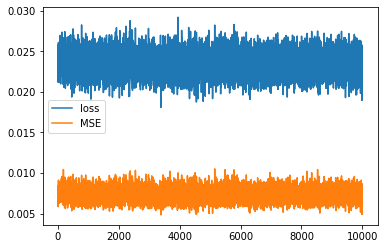

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


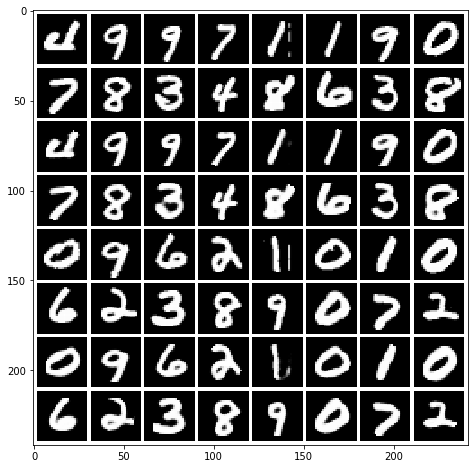

Mean squared dist: 0.007928546
epoch: 73 	 step:0 	 loss: 0.02321 	 reg loss: 0.001804
epoch: 73 	 step:100 	 loss: 0.02213 	 reg loss: 0.001805
epoch: 73 	 step:200 	 loss: 0.02527 	 reg loss: 0.001811
epoch: 73 	 step:300 	 loss: 0.02282 	 reg loss: 0.001847
epoch: 73 	 step:400 	 loss: 0.02614 	 reg loss: 0.001794
epoch: 73 	 step:500 	 loss: 0.02239 	 reg loss: 0.00174
epoch: 73 	 step:600 	 loss: 0.02397 	 reg loss: 0.001809
epoch: 73 	 step:700 	 loss: 0.02414 	 reg loss: 0.001844
epoch: 73 	 step:800 	 loss: 0.02445 	 reg loss: 0.001811
epoch: 73 	 step:900 	 loss: 0.021 	 reg loss: 0.001779
epoch: 73 	 step:1000 	 loss: 0.02457 	 reg loss: 0.001858
epoch: 73 	 step:1100 	 loss: 0.02256 	 reg loss: 0.001781
epoch: 73 	 step:1200 	 loss: 0.02484 	 reg loss: 0.001859
epoch: 73 	 step:1300 	 loss: 0.02192 	 reg loss: 0.001746
epoch: 73 	 step:1400 	 loss: 0.02684 	 reg loss: 0.001816
epoch: 73 	 step:1500 	 loss: 0.02277 	 reg loss: 0.001839
epoch: 73 	 step:1600 	 loss: 0.02565 	 

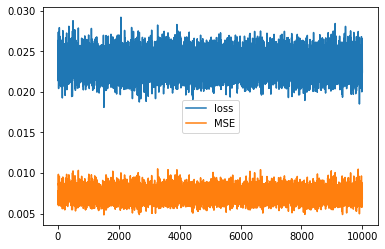

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


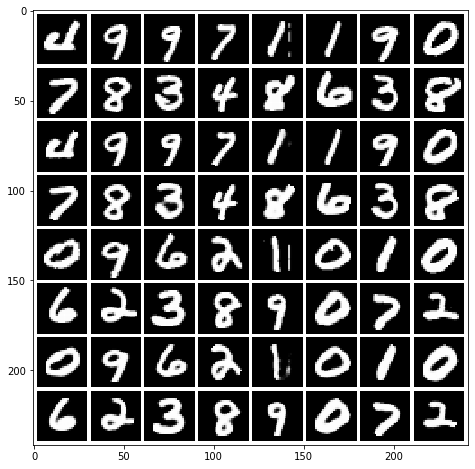

Mean squared dist: 0.007899005
epoch: 74 	 step:0 	 loss: 0.02244 	 reg loss: 0.00177
epoch: 74 	 step:100 	 loss: 0.0236 	 reg loss: 0.001846
epoch: 74 	 step:200 	 loss: 0.02161 	 reg loss: 0.00173
epoch: 74 	 step:300 	 loss: 0.02359 	 reg loss: 0.001817
epoch: 74 	 step:400 	 loss: 0.02414 	 reg loss: 0.001859
epoch: 74 	 step:500 	 loss: 0.02268 	 reg loss: 0.001773
epoch: 74 	 step:600 	 loss: 0.02153 	 reg loss: 0.001763
epoch: 74 	 step:700 	 loss: 0.02493 	 reg loss: 0.001807
epoch: 74 	 step:800 	 loss: 0.02227 	 reg loss: 0.001777
epoch: 74 	 step:900 	 loss: 0.02388 	 reg loss: 0.001823
epoch: 74 	 step:1000 	 loss: 0.02368 	 reg loss: 0.001824
epoch: 74 	 step:1100 	 loss: 0.0257 	 reg loss: 0.001868
epoch: 74 	 step:1200 	 loss: 0.02177 	 reg loss: 0.001756
epoch: 74 	 step:1300 	 loss: 0.02407 	 reg loss: 0.001797
epoch: 74 	 step:1400 	 loss: 0.02313 	 reg loss: 0.001824
epoch: 74 	 step:1500 	 loss: 0.02227 	 reg loss: 0.001805
epoch: 74 	 step:1600 	 loss: 0.02621 	 r

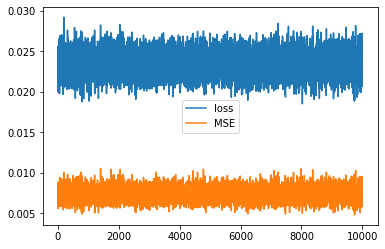

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


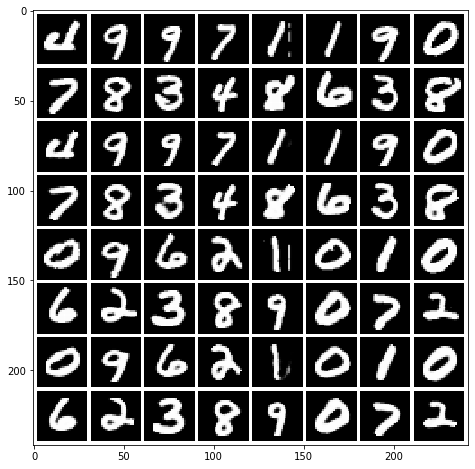

Mean squared dist: 0.007968635
epoch: 75 	 step:0 	 loss: 0.02352 	 reg loss: 0.001725
epoch: 75 	 step:100 	 loss: 0.02184 	 reg loss: 0.001775
epoch: 75 	 step:200 	 loss: 0.02154 	 reg loss: 0.001778
epoch: 75 	 step:300 	 loss: 0.02175 	 reg loss: 0.001785
epoch: 75 	 step:400 	 loss: 0.02447 	 reg loss: 0.001863
epoch: 75 	 step:500 	 loss: 0.0247 	 reg loss: 0.001853
epoch: 75 	 step:600 	 loss: 0.022 	 reg loss: 0.001802
epoch: 75 	 step:700 	 loss: 0.02153 	 reg loss: 0.001772
epoch: 75 	 step:800 	 loss: 0.02184 	 reg loss: 0.001772
epoch: 75 	 step:900 	 loss: 0.02054 	 reg loss: 0.001767
epoch: 75 	 step:1000 	 loss: 0.02406 	 reg loss: 0.001838
epoch: 75 	 step:1100 	 loss: 0.0237 	 reg loss: 0.001852
epoch: 75 	 step:1200 	 loss: 0.02411 	 reg loss: 0.001849
epoch: 75 	 step:1300 	 loss: 0.02528 	 reg loss: 0.001858
epoch: 75 	 step:1400 	 loss: 0.02375 	 reg loss: 0.001814
epoch: 75 	 step:1500 	 loss: 0.02234 	 reg loss: 0.001746
epoch: 75 	 step:1600 	 loss: 0.02374 	 r

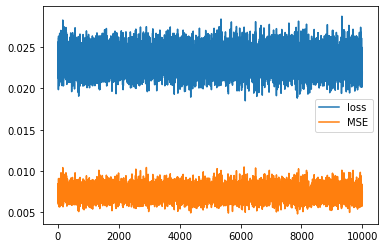

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


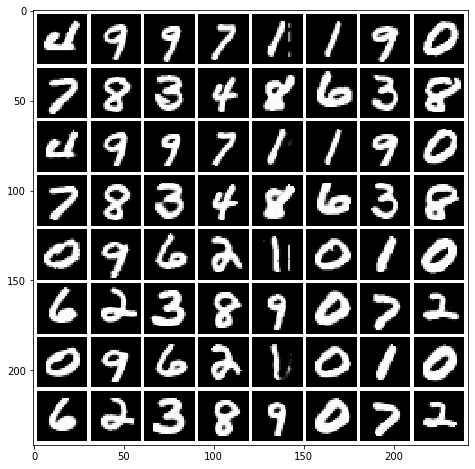

Mean squared dist: 0.007883617
epoch: 76 	 step:0 	 loss: 0.02308 	 reg loss: 0.001823
epoch: 76 	 step:100 	 loss: 0.02359 	 reg loss: 0.001779
epoch: 76 	 step:200 	 loss: 0.02136 	 reg loss: 0.001777
epoch: 76 	 step:300 	 loss: 0.02545 	 reg loss: 0.001864
epoch: 76 	 step:400 	 loss: 0.02549 	 reg loss: 0.001876
epoch: 76 	 step:500 	 loss: 0.02415 	 reg loss: 0.001772
epoch: 76 	 step:600 	 loss: 0.02425 	 reg loss: 0.001824
epoch: 76 	 step:700 	 loss: 0.02003 	 reg loss: 0.001772
epoch: 76 	 step:800 	 loss: 0.02363 	 reg loss: 0.001813
epoch: 76 	 step:900 	 loss: 0.02174 	 reg loss: 0.001775
epoch: 76 	 step:1000 	 loss: 0.02429 	 reg loss: 0.00185
epoch: 76 	 step:1100 	 loss: 0.02231 	 reg loss: 0.001732
epoch: 76 	 step:1200 	 loss: 0.02478 	 reg loss: 0.00188
epoch: 76 	 step:1300 	 loss: 0.02631 	 reg loss: 0.00182
epoch: 76 	 step:1400 	 loss: 0.02334 	 reg loss: 0.001855
epoch: 76 	 step:1500 	 loss: 0.02232 	 reg loss: 0.001816
epoch: 76 	 step:1600 	 loss: 0.02405 	 

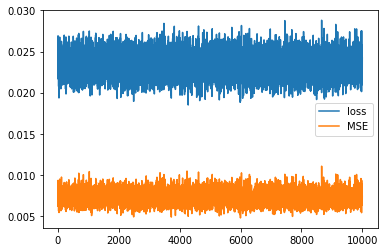

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


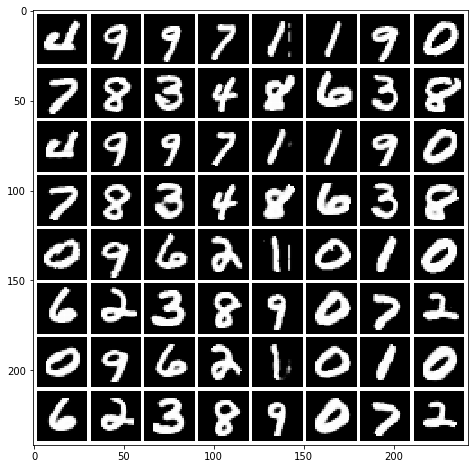

Mean squared dist: 0.007978408
epoch: 77 	 step:0 	 loss: 0.02588 	 reg loss: 0.001821
epoch: 77 	 step:100 	 loss: 0.02364 	 reg loss: 0.001848
epoch: 77 	 step:200 	 loss: 0.02432 	 reg loss: 0.001822
epoch: 77 	 step:300 	 loss: 0.02307 	 reg loss: 0.001859
epoch: 77 	 step:400 	 loss: 0.02285 	 reg loss: 0.001804
epoch: 77 	 step:500 	 loss: 0.0223 	 reg loss: 0.0018
epoch: 77 	 step:600 	 loss: 0.02354 	 reg loss: 0.001764
epoch: 77 	 step:700 	 loss: 0.02391 	 reg loss: 0.001822
epoch: 77 	 step:800 	 loss: 0.02426 	 reg loss: 0.001846
epoch: 77 	 step:900 	 loss: 0.02494 	 reg loss: 0.001865
epoch: 77 	 step:1000 	 loss: 0.02198 	 reg loss: 0.001743
epoch: 77 	 step:1100 	 loss: 0.02248 	 reg loss: 0.001773
epoch: 77 	 step:1200 	 loss: 0.02432 	 reg loss: 0.001833
epoch: 77 	 step:1300 	 loss: 0.02406 	 reg loss: 0.001826
epoch: 77 	 step:1400 	 loss: 0.02071 	 reg loss: 0.001757
epoch: 77 	 step:1500 	 loss: 0.02398 	 reg loss: 0.001823
epoch: 77 	 step:1600 	 loss: 0.0201 	 r

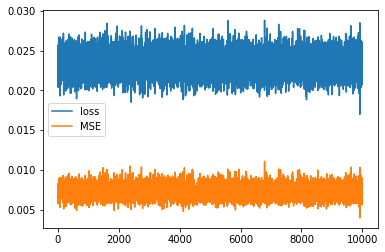

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


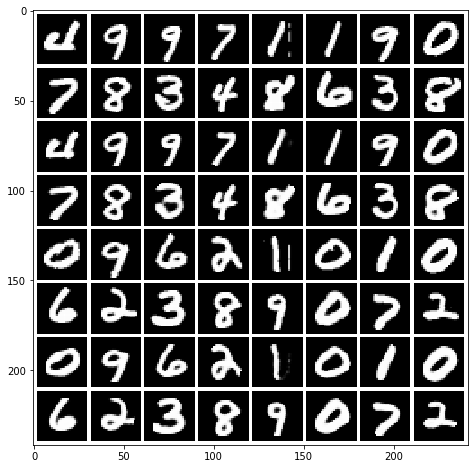

Mean squared dist: 0.007928276
epoch: 78 	 step:0 	 loss: 0.02463 	 reg loss: 0.001901
epoch: 78 	 step:100 	 loss: 0.02408 	 reg loss: 0.001847
epoch: 78 	 step:200 	 loss: 0.02225 	 reg loss: 0.00178
epoch: 78 	 step:300 	 loss: 0.02437 	 reg loss: 0.00182
epoch: 78 	 step:400 	 loss: 0.02267 	 reg loss: 0.001844
epoch: 78 	 step:500 	 loss: 0.02153 	 reg loss: 0.00173
epoch: 78 	 step:600 	 loss: 0.02377 	 reg loss: 0.001785
epoch: 78 	 step:700 	 loss: 0.02303 	 reg loss: 0.001808
epoch: 78 	 step:800 	 loss: 0.02194 	 reg loss: 0.001794
epoch: 78 	 step:900 	 loss: 0.02402 	 reg loss: 0.001833
epoch: 78 	 step:1000 	 loss: 0.02209 	 reg loss: 0.001774
epoch: 78 	 step:1100 	 loss: 0.02552 	 reg loss: 0.001879
epoch: 78 	 step:1200 	 loss: 0.02066 	 reg loss: 0.001732
epoch: 78 	 step:1300 	 loss: 0.02152 	 reg loss: 0.001821
epoch: 78 	 step:1400 	 loss: 0.0229 	 reg loss: 0.001779
epoch: 78 	 step:1500 	 loss: 0.02272 	 reg loss: 0.001804
epoch: 78 	 step:1600 	 loss: 0.02431 	 r

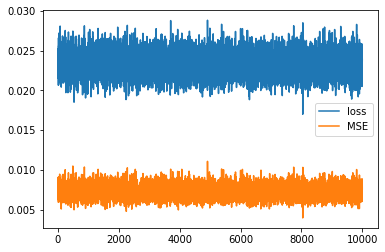

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


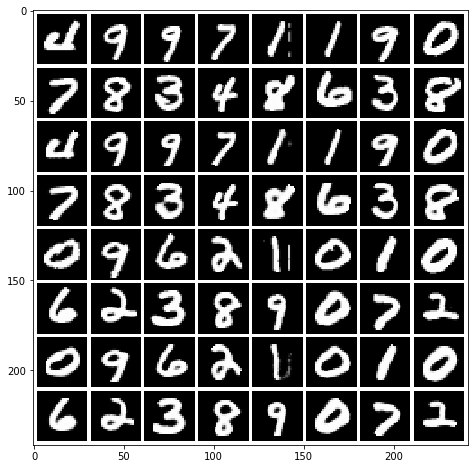

Mean squared dist: 0.007834054
epoch: 79 	 step:0 	 loss: 0.02701 	 reg loss: 0.001879
epoch: 79 	 step:100 	 loss: 0.02186 	 reg loss: 0.001758
epoch: 79 	 step:200 	 loss: 0.02111 	 reg loss: 0.001784
epoch: 79 	 step:300 	 loss: 0.02253 	 reg loss: 0.001802
epoch: 79 	 step:400 	 loss: 0.02386 	 reg loss: 0.001802
epoch: 79 	 step:500 	 loss: 0.02446 	 reg loss: 0.001827
epoch: 79 	 step:600 	 loss: 0.02414 	 reg loss: 0.00185
epoch: 79 	 step:700 	 loss: 0.02414 	 reg loss: 0.001854
epoch: 79 	 step:800 	 loss: 0.02411 	 reg loss: 0.001812
epoch: 79 	 step:900 	 loss: 0.02407 	 reg loss: 0.001887
epoch: 79 	 step:1000 	 loss: 0.02273 	 reg loss: 0.001801
epoch: 79 	 step:1100 	 loss: 0.02415 	 reg loss: 0.001895
epoch: 79 	 step:1200 	 loss: 0.02378 	 reg loss: 0.001844
epoch: 79 	 step:1300 	 loss: 0.02568 	 reg loss: 0.001849
epoch: 79 	 step:1400 	 loss: 0.02169 	 reg loss: 0.001806
epoch: 79 	 step:1500 	 loss: 0.02295 	 reg loss: 0.001803
epoch: 79 	 step:1600 	 loss: 0.02279 

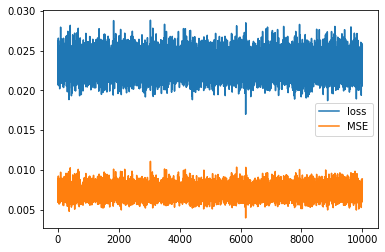

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


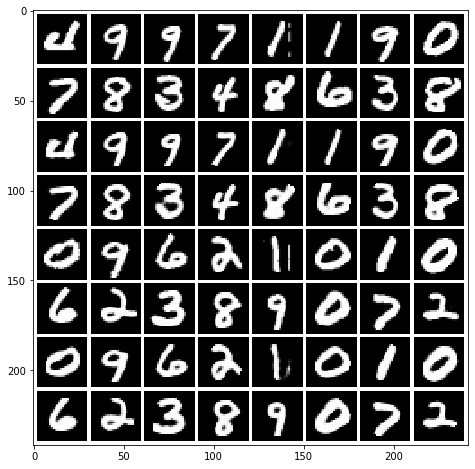

Mean squared dist: 0.007869344
epoch: 80 	 step:0 	 loss: 0.02239 	 reg loss: 0.001798
epoch: 80 	 step:100 	 loss: 0.02345 	 reg loss: 0.001804
epoch: 80 	 step:200 	 loss: 0.02371 	 reg loss: 0.001836
epoch: 80 	 step:300 	 loss: 0.02374 	 reg loss: 0.001782
epoch: 80 	 step:400 	 loss: 0.02164 	 reg loss: 0.001778
epoch: 80 	 step:500 	 loss: 0.02268 	 reg loss: 0.001791
epoch: 80 	 step:600 	 loss: 0.02322 	 reg loss: 0.001812
epoch: 80 	 step:700 	 loss: 0.02309 	 reg loss: 0.001855
epoch: 80 	 step:800 	 loss: 0.02483 	 reg loss: 0.001826
epoch: 80 	 step:900 	 loss: 0.02296 	 reg loss: 0.001793
epoch: 80 	 step:1000 	 loss: 0.02517 	 reg loss: 0.001871
epoch: 80 	 step:1100 	 loss: 0.02251 	 reg loss: 0.001735
epoch: 80 	 step:1200 	 loss: 0.02374 	 reg loss: 0.001847
epoch: 80 	 step:1300 	 loss: 0.02538 	 reg loss: 0.001846
epoch: 80 	 step:1400 	 loss: 0.02267 	 reg loss: 0.001903
epoch: 80 	 step:1500 	 loss: 0.02539 	 reg loss: 0.001811
epoch: 80 	 step:1600 	 loss: 0.02312

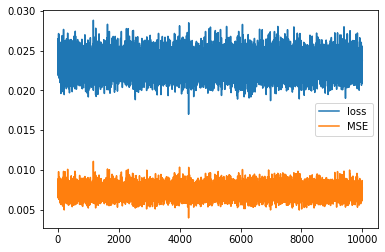

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


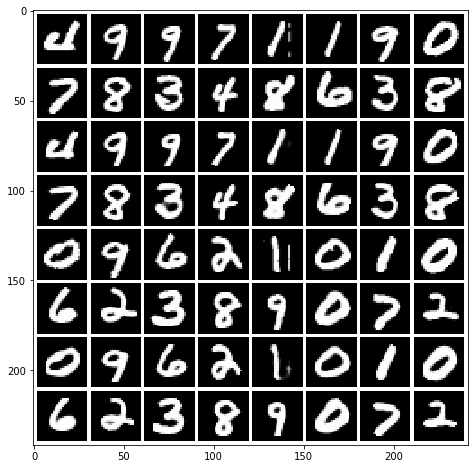

Mean squared dist: 0.0080942465
epoch: 81 	 step:0 	 loss: 0.02317 	 reg loss: 0.00179
epoch: 81 	 step:100 	 loss: 0.0219 	 reg loss: 0.001859
epoch: 81 	 step:200 	 loss: 0.02312 	 reg loss: 0.001845
epoch: 81 	 step:300 	 loss: 0.02176 	 reg loss: 0.00175
epoch: 81 	 step:400 	 loss: 0.02205 	 reg loss: 0.00182
epoch: 81 	 step:500 	 loss: 0.02311 	 reg loss: 0.001801
epoch: 81 	 step:600 	 loss: 0.02385 	 reg loss: 0.001804
epoch: 81 	 step:700 	 loss: 0.02367 	 reg loss: 0.001835
epoch: 81 	 step:800 	 loss: 0.02134 	 reg loss: 0.001736
epoch: 81 	 step:900 	 loss: 0.02011 	 reg loss: 0.001772
epoch: 81 	 step:1000 	 loss: 0.02203 	 reg loss: 0.001738
epoch: 81 	 step:1100 	 loss: 0.02548 	 reg loss: 0.001865
epoch: 81 	 step:1200 	 loss: 0.02224 	 reg loss: 0.00178
epoch: 81 	 step:1300 	 loss: 0.0245 	 reg loss: 0.001797
epoch: 81 	 step:1400 	 loss: 0.02153 	 reg loss: 0.001799
epoch: 81 	 step:1500 	 loss: 0.02184 	 reg loss: 0.001804
epoch: 81 	 step:1600 	 loss: 0.0227 	 reg

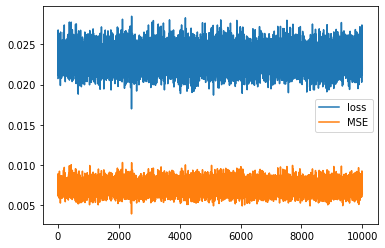

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


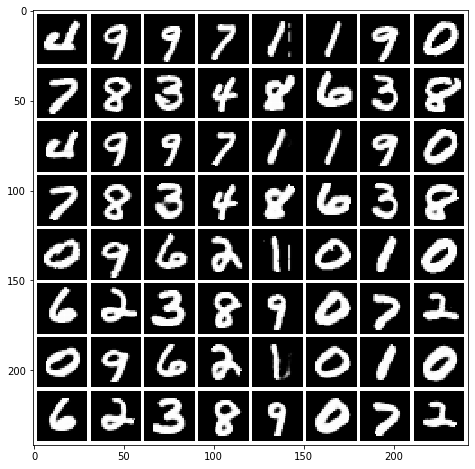

Mean squared dist: 0.007869326
epoch: 82 	 step:0 	 loss: 0.02203 	 reg loss: 0.001801
epoch: 82 	 step:100 	 loss: 0.02326 	 reg loss: 0.001783
epoch: 82 	 step:200 	 loss: 0.02409 	 reg loss: 0.001832
epoch: 82 	 step:300 	 loss: 0.0239 	 reg loss: 0.001827
epoch: 82 	 step:400 	 loss: 0.02382 	 reg loss: 0.001806
epoch: 82 	 step:500 	 loss: 0.02247 	 reg loss: 0.00179
epoch: 82 	 step:600 	 loss: 0.02279 	 reg loss: 0.001857
epoch: 82 	 step:700 	 loss: 0.02313 	 reg loss: 0.00179
epoch: 82 	 step:800 	 loss: 0.0216 	 reg loss: 0.00176
epoch: 82 	 step:900 	 loss: 0.02179 	 reg loss: 0.001851
epoch: 82 	 step:1000 	 loss: 0.02282 	 reg loss: 0.001793
epoch: 82 	 step:1100 	 loss: 0.02418 	 reg loss: 0.001786
epoch: 82 	 step:1200 	 loss: 0.02239 	 reg loss: 0.001779
epoch: 82 	 step:1300 	 loss: 0.02192 	 reg loss: 0.00178
epoch: 82 	 step:1400 	 loss: 0.02562 	 reg loss: 0.001791
epoch: 82 	 step:1500 	 loss: 0.02047 	 reg loss: 0.001775
epoch: 82 	 step:1600 	 loss: 0.02232 	 reg

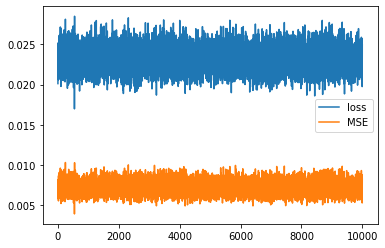

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


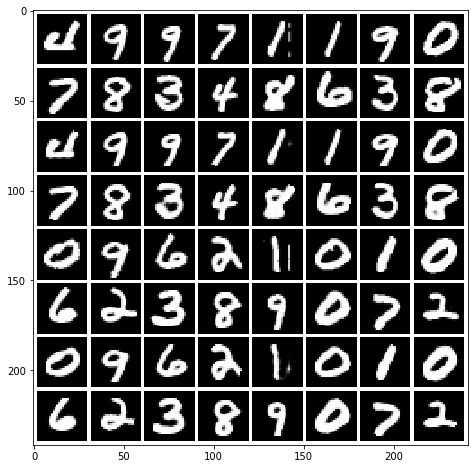

Mean squared dist: 0.0078978175
epoch: 83 	 step:0 	 loss: 0.0267 	 reg loss: 0.001847
epoch: 83 	 step:100 	 loss: 0.02368 	 reg loss: 0.001783
epoch: 83 	 step:200 	 loss: 0.02284 	 reg loss: 0.001823
epoch: 83 	 step:300 	 loss: 0.02561 	 reg loss: 0.001856
epoch: 83 	 step:400 	 loss: 0.0234 	 reg loss: 0.001834
epoch: 83 	 step:500 	 loss: 0.02345 	 reg loss: 0.001819
epoch: 83 	 step:600 	 loss: 0.02247 	 reg loss: 0.001838
epoch: 83 	 step:700 	 loss: 0.02574 	 reg loss: 0.00182
epoch: 83 	 step:800 	 loss: 0.02091 	 reg loss: 0.001747
epoch: 83 	 step:900 	 loss: 0.02016 	 reg loss: 0.001743
epoch: 83 	 step:1000 	 loss: 0.02127 	 reg loss: 0.001762
epoch: 83 	 step:1100 	 loss: 0.02234 	 reg loss: 0.001809
epoch: 83 	 step:1200 	 loss: 0.02255 	 reg loss: 0.001749
epoch: 83 	 step:1300 	 loss: 0.02321 	 reg loss: 0.001782
epoch: 83 	 step:1400 	 loss: 0.02415 	 reg loss: 0.001857
epoch: 83 	 step:1500 	 loss: 0.0243 	 reg loss: 0.001819
epoch: 83 	 step:1600 	 loss: 0.0238 	 r

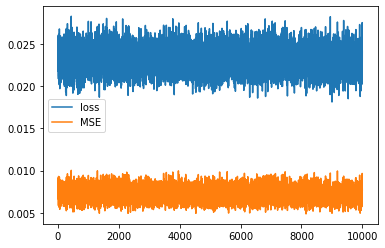

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


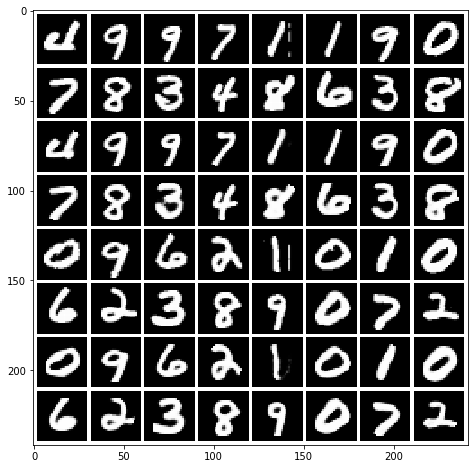

Mean squared dist: 0.0080004195
epoch: 84 	 step:0 	 loss: 0.02407 	 reg loss: 0.001821
epoch: 84 	 step:100 	 loss: 0.02299 	 reg loss: 0.001835
epoch: 84 	 step:200 	 loss: 0.02652 	 reg loss: 0.001894
epoch: 84 	 step:300 	 loss: 0.0242 	 reg loss: 0.001853
epoch: 84 	 step:400 	 loss: 0.02286 	 reg loss: 0.00179
epoch: 84 	 step:500 	 loss: 0.02274 	 reg loss: 0.001829
epoch: 84 	 step:600 	 loss: 0.02482 	 reg loss: 0.001857
epoch: 84 	 step:700 	 loss: 0.0242 	 reg loss: 0.001818
epoch: 84 	 step:800 	 loss: 0.0237 	 reg loss: 0.001856
epoch: 84 	 step:900 	 loss: 0.02166 	 reg loss: 0.001792
epoch: 84 	 step:1000 	 loss: 0.02149 	 reg loss: 0.0018
epoch: 84 	 step:1100 	 loss: 0.02623 	 reg loss: 0.001874
epoch: 84 	 step:1200 	 loss: 0.02535 	 reg loss: 0.001839
epoch: 84 	 step:1300 	 loss: 0.02343 	 reg loss: 0.001797
epoch: 84 	 step:1400 	 loss: 0.02243 	 reg loss: 0.001822
epoch: 84 	 step:1500 	 loss: 0.02333 	 reg loss: 0.001783
epoch: 84 	 step:1600 	 loss: 0.02534 	 re

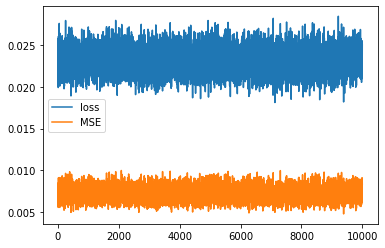

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


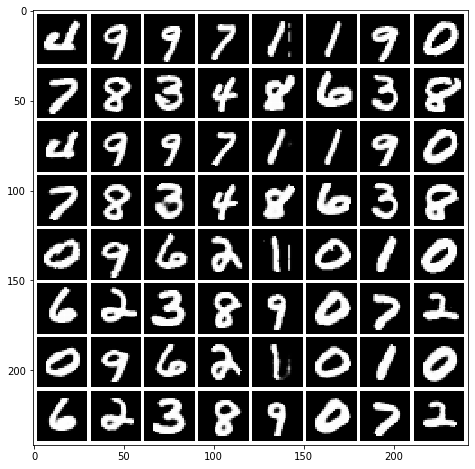

Mean squared dist: 0.007897628
epoch: 85 	 step:0 	 loss: 0.02363 	 reg loss: 0.001839
epoch: 85 	 step:100 	 loss: 0.02582 	 reg loss: 0.001857
epoch: 85 	 step:200 	 loss: 0.02435 	 reg loss: 0.001807
epoch: 85 	 step:300 	 loss: 0.02303 	 reg loss: 0.001822
epoch: 85 	 step:400 	 loss: 0.02249 	 reg loss: 0.001824
epoch: 85 	 step:500 	 loss: 0.02483 	 reg loss: 0.001859
epoch: 85 	 step:600 	 loss: 0.02485 	 reg loss: 0.001845
epoch: 85 	 step:700 	 loss: 0.02582 	 reg loss: 0.001831
epoch: 85 	 step:800 	 loss: 0.02326 	 reg loss: 0.001832
epoch: 85 	 step:900 	 loss: 0.02176 	 reg loss: 0.001777
epoch: 85 	 step:1000 	 loss: 0.02416 	 reg loss: 0.001814
epoch: 85 	 step:1100 	 loss: 0.02192 	 reg loss: 0.001782
epoch: 85 	 step:1200 	 loss: 0.02425 	 reg loss: 0.001841
epoch: 85 	 step:1300 	 loss: 0.02381 	 reg loss: 0.001778
epoch: 85 	 step:1400 	 loss: 0.02314 	 reg loss: 0.001825
epoch: 85 	 step:1500 	 loss: 0.0241 	 reg loss: 0.001879
epoch: 85 	 step:1600 	 loss: 0.02283 

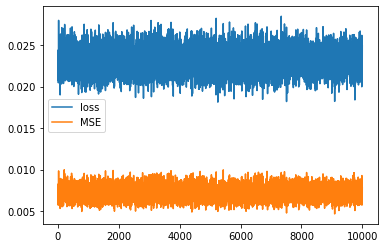

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


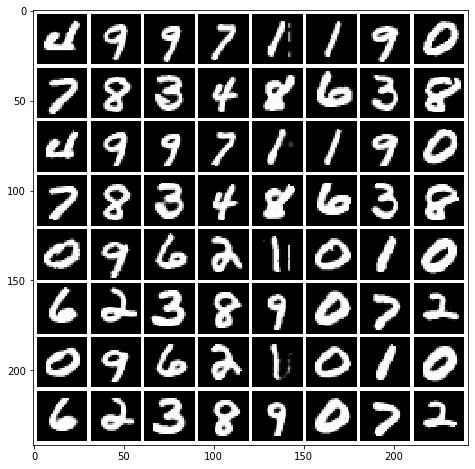

Mean squared dist: 0.007921507
epoch: 86 	 step:0 	 loss: 0.02375 	 reg loss: 0.001827
epoch: 86 	 step:100 	 loss: 0.02285 	 reg loss: 0.001833
epoch: 86 	 step:200 	 loss: 0.02412 	 reg loss: 0.001786
epoch: 86 	 step:300 	 loss: 0.02161 	 reg loss: 0.001803
epoch: 86 	 step:400 	 loss: 0.02336 	 reg loss: 0.001747
epoch: 86 	 step:500 	 loss: 0.02114 	 reg loss: 0.00181
epoch: 86 	 step:600 	 loss: 0.02129 	 reg loss: 0.001801
epoch: 86 	 step:700 	 loss: 0.02047 	 reg loss: 0.001746
epoch: 86 	 step:800 	 loss: 0.02427 	 reg loss: 0.001844
epoch: 86 	 step:900 	 loss: 0.02408 	 reg loss: 0.001781
epoch: 86 	 step:1000 	 loss: 0.02323 	 reg loss: 0.001852
epoch: 86 	 step:1100 	 loss: 0.01971 	 reg loss: 0.001763
epoch: 86 	 step:1200 	 loss: 0.02274 	 reg loss: 0.001834
epoch: 86 	 step:1300 	 loss: 0.021 	 reg loss: 0.001802
epoch: 86 	 step:1400 	 loss: 0.02705 	 reg loss: 0.001859
epoch: 86 	 step:1500 	 loss: 0.02668 	 reg loss: 0.001815
epoch: 86 	 step:1600 	 loss: 0.02415 	 

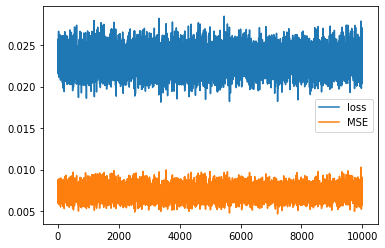

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


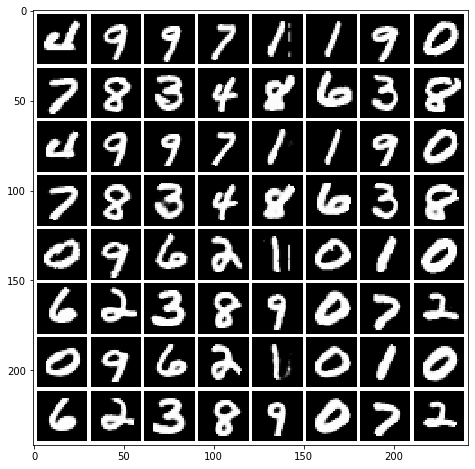

Mean squared dist: 0.007871628
epoch: 87 	 step:0 	 loss: 0.02257 	 reg loss: 0.001826
epoch: 87 	 step:100 	 loss: 0.02424 	 reg loss: 0.001864
epoch: 87 	 step:200 	 loss: 0.02378 	 reg loss: 0.001831
epoch: 87 	 step:300 	 loss: 0.02263 	 reg loss: 0.001775
epoch: 87 	 step:400 	 loss: 0.02345 	 reg loss: 0.001824
epoch: 87 	 step:500 	 loss: 0.02223 	 reg loss: 0.001856
epoch: 87 	 step:600 	 loss: 0.02291 	 reg loss: 0.001866
epoch: 87 	 step:700 	 loss: 0.02468 	 reg loss: 0.001803
epoch: 87 	 step:800 	 loss: 0.02236 	 reg loss: 0.001851
epoch: 87 	 step:900 	 loss: 0.02172 	 reg loss: 0.001753
epoch: 87 	 step:1000 	 loss: 0.01986 	 reg loss: 0.001781
epoch: 87 	 step:1100 	 loss: 0.0242 	 reg loss: 0.001845
epoch: 87 	 step:1200 	 loss: 0.0243 	 reg loss: 0.001793
epoch: 87 	 step:1300 	 loss: 0.0237 	 reg loss: 0.001801
epoch: 87 	 step:1400 	 loss: 0.02269 	 reg loss: 0.001799
epoch: 87 	 step:1500 	 loss: 0.02467 	 reg loss: 0.001832
epoch: 87 	 step:1600 	 loss: 0.02333 	 

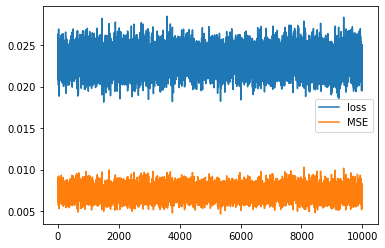

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


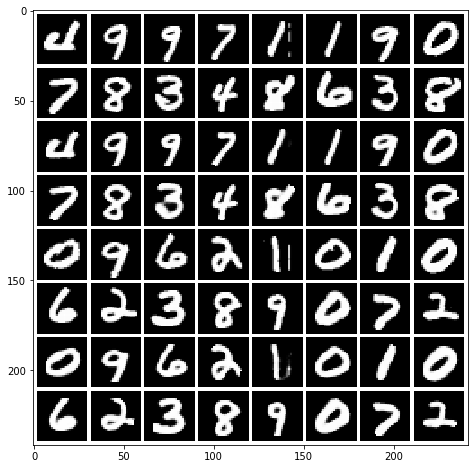

Mean squared dist: 0.007855274
epoch: 88 	 step:0 	 loss: 0.02306 	 reg loss: 0.001729
epoch: 88 	 step:100 	 loss: 0.02211 	 reg loss: 0.00178
epoch: 88 	 step:200 	 loss: 0.02285 	 reg loss: 0.001813
epoch: 88 	 step:300 	 loss: 0.02134 	 reg loss: 0.001775
epoch: 88 	 step:400 	 loss: 0.02395 	 reg loss: 0.001839
epoch: 88 	 step:500 	 loss: 0.0217 	 reg loss: 0.0018
epoch: 88 	 step:600 	 loss: 0.02172 	 reg loss: 0.001775
epoch: 88 	 step:700 	 loss: 0.02218 	 reg loss: 0.001787
epoch: 88 	 step:800 	 loss: 0.02319 	 reg loss: 0.001796
epoch: 88 	 step:900 	 loss: 0.0233 	 reg loss: 0.001796
epoch: 88 	 step:1000 	 loss: 0.02165 	 reg loss: 0.001765
epoch: 88 	 step:1100 	 loss: 0.0262 	 reg loss: 0.001897
epoch: 88 	 step:1200 	 loss: 0.02086 	 reg loss: 0.001856
epoch: 88 	 step:1300 	 loss: 0.02367 	 reg loss: 0.001853
epoch: 88 	 step:1400 	 loss: 0.02308 	 reg loss: 0.001824
epoch: 88 	 step:1500 	 loss: 0.02384 	 reg loss: 0.001803
epoch: 88 	 step:1600 	 loss: 0.02547 	 reg

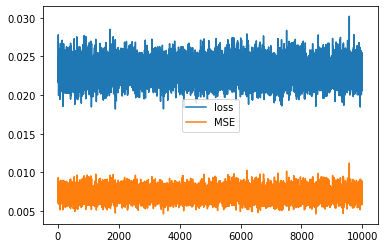

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


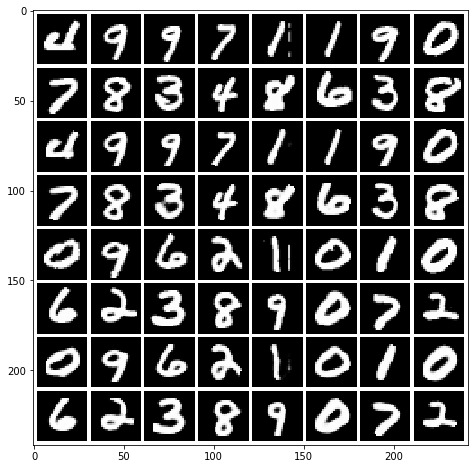

Mean squared dist: 0.007828777
epoch: 89 	 step:0 	 loss: 0.022 	 reg loss: 0.001779
epoch: 89 	 step:100 	 loss: 0.0224 	 reg loss: 0.001811
epoch: 89 	 step:200 	 loss: 0.02183 	 reg loss: 0.00186
epoch: 89 	 step:300 	 loss: 0.02125 	 reg loss: 0.001745
epoch: 89 	 step:400 	 loss: 0.02178 	 reg loss: 0.001835
epoch: 89 	 step:500 	 loss: 0.02261 	 reg loss: 0.001786
epoch: 89 	 step:600 	 loss: 0.02414 	 reg loss: 0.001792
epoch: 89 	 step:700 	 loss: 0.02408 	 reg loss: 0.001844
epoch: 89 	 step:800 	 loss: 0.02366 	 reg loss: 0.001874
epoch: 89 	 step:900 	 loss: 0.02228 	 reg loss: 0.001832
epoch: 89 	 step:1000 	 loss: 0.02478 	 reg loss: 0.001776
epoch: 89 	 step:1100 	 loss: 0.02062 	 reg loss: 0.001771
epoch: 89 	 step:1200 	 loss: 0.02362 	 reg loss: 0.001867
epoch: 89 	 step:1300 	 loss: 0.02194 	 reg loss: 0.001846
epoch: 89 	 step:1400 	 loss: 0.0213 	 reg loss: 0.001824
epoch: 89 	 step:1500 	 loss: 0.02359 	 reg loss: 0.001838
epoch: 89 	 step:1600 	 loss: 0.02239 	 re

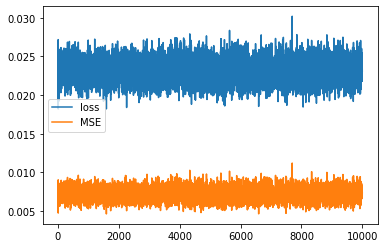

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


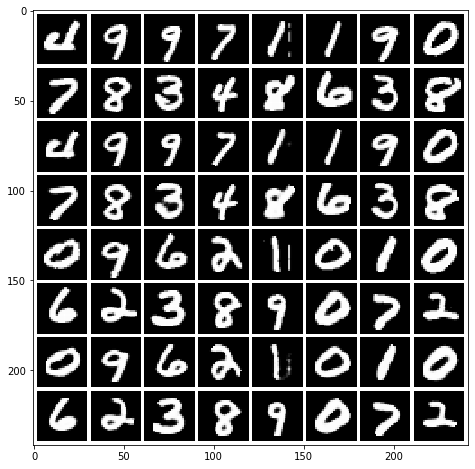

Mean squared dist: 0.007933664
epoch: 90 	 step:0 	 loss: 0.0213 	 reg loss: 0.001792
epoch: 90 	 step:100 	 loss: 0.02025 	 reg loss: 0.001754
epoch: 90 	 step:200 	 loss: 0.02278 	 reg loss: 0.001848
epoch: 90 	 step:300 	 loss: 0.02585 	 reg loss: 0.001854
epoch: 90 	 step:400 	 loss: 0.02459 	 reg loss: 0.001872
epoch: 90 	 step:500 	 loss: 0.02424 	 reg loss: 0.001806
epoch: 90 	 step:600 	 loss: 0.02298 	 reg loss: 0.001868
epoch: 90 	 step:700 	 loss: 0.02587 	 reg loss: 0.001852
epoch: 90 	 step:800 	 loss: 0.02349 	 reg loss: 0.001775
epoch: 90 	 step:900 	 loss: 0.0223 	 reg loss: 0.001793
epoch: 90 	 step:1000 	 loss: 0.02562 	 reg loss: 0.00182
epoch: 90 	 step:1100 	 loss: 0.02346 	 reg loss: 0.001782
epoch: 90 	 step:1200 	 loss: 0.02353 	 reg loss: 0.00186
epoch: 90 	 step:1300 	 loss: 0.02494 	 reg loss: 0.001852
epoch: 90 	 step:1400 	 loss: 0.02448 	 reg loss: 0.001811
epoch: 90 	 step:1500 	 loss: 0.02368 	 reg loss: 0.001789
epoch: 90 	 step:1600 	 loss: 0.02542 	 r

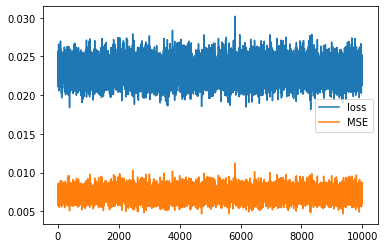

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


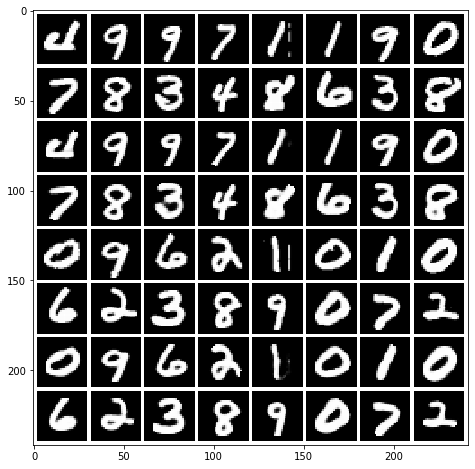

Mean squared dist: 0.007815867
epoch: 91 	 step:0 	 loss: 0.02333 	 reg loss: 0.001867
epoch: 91 	 step:100 	 loss: 0.023 	 reg loss: 0.001851
epoch: 91 	 step:200 	 loss: 0.02143 	 reg loss: 0.001781
epoch: 91 	 step:300 	 loss: 0.02187 	 reg loss: 0.001753
epoch: 91 	 step:400 	 loss: 0.02372 	 reg loss: 0.001827
epoch: 91 	 step:500 	 loss: 0.02208 	 reg loss: 0.001758
epoch: 91 	 step:600 	 loss: 0.02267 	 reg loss: 0.00183
epoch: 91 	 step:700 	 loss: 0.02249 	 reg loss: 0.001743
epoch: 91 	 step:800 	 loss: 0.02351 	 reg loss: 0.001828
epoch: 91 	 step:900 	 loss: 0.02231 	 reg loss: 0.001805
epoch: 91 	 step:1000 	 loss: 0.02183 	 reg loss: 0.001797
epoch: 91 	 step:1100 	 loss: 0.02486 	 reg loss: 0.001839
epoch: 91 	 step:1200 	 loss: 0.02365 	 reg loss: 0.001798
epoch: 91 	 step:1300 	 loss: 0.0222 	 reg loss: 0.001786
epoch: 91 	 step:1400 	 loss: 0.02371 	 reg loss: 0.001802
epoch: 91 	 step:1500 	 loss: 0.02073 	 reg loss: 0.001778
epoch: 91 	 step:1600 	 loss: 0.024 	 reg

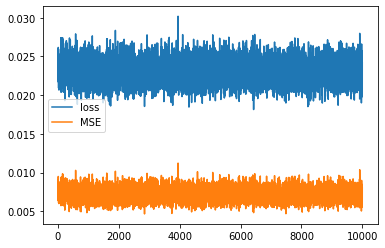

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


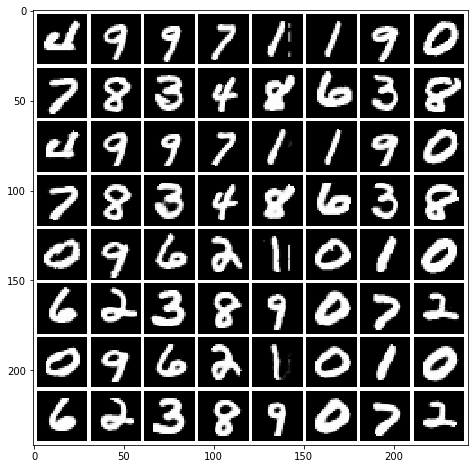

Mean squared dist: 0.007955722
epoch: 92 	 step:0 	 loss: 0.02538 	 reg loss: 0.001841
epoch: 92 	 step:100 	 loss: 0.02134 	 reg loss: 0.001802
epoch: 92 	 step:200 	 loss: 0.02257 	 reg loss: 0.001905
epoch: 92 	 step:300 	 loss: 0.02314 	 reg loss: 0.001843
epoch: 92 	 step:400 	 loss: 0.02234 	 reg loss: 0.001804
epoch: 92 	 step:500 	 loss: 0.02426 	 reg loss: 0.001935
epoch: 92 	 step:600 	 loss: 0.02194 	 reg loss: 0.001756
epoch: 92 	 step:700 	 loss: 0.02125 	 reg loss: 0.001795
epoch: 92 	 step:800 	 loss: 0.02374 	 reg loss: 0.001835
epoch: 92 	 step:900 	 loss: 0.02203 	 reg loss: 0.001765
epoch: 92 	 step:1000 	 loss: 0.02209 	 reg loss: 0.001768
epoch: 92 	 step:1100 	 loss: 0.02374 	 reg loss: 0.001879
epoch: 92 	 step:1200 	 loss: 0.02343 	 reg loss: 0.001771
epoch: 92 	 step:1300 	 loss: 0.02611 	 reg loss: 0.001853
epoch: 92 	 step:1400 	 loss: 0.02265 	 reg loss: 0.001887
epoch: 92 	 step:1500 	 loss: 0.02118 	 reg loss: 0.001784
epoch: 92 	 step:1600 	 loss: 0.02332

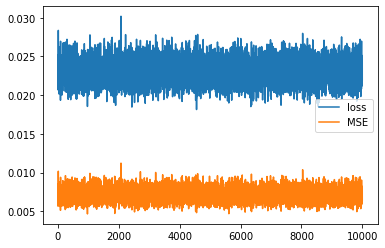

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


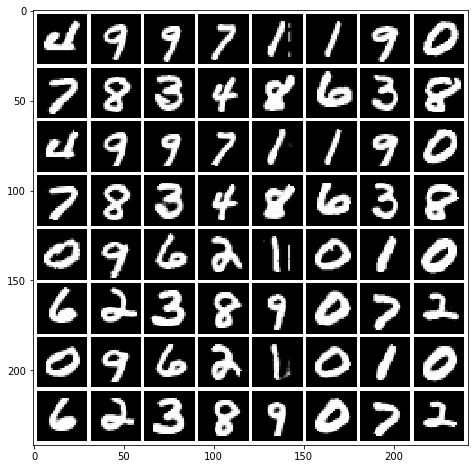

Mean squared dist: 0.007942295
epoch: 93 	 step:0 	 loss: 0.02163 	 reg loss: 0.001786
epoch: 93 	 step:100 	 loss: 0.02445 	 reg loss: 0.00184
epoch: 93 	 step:200 	 loss: 0.02205 	 reg loss: 0.001773
epoch: 93 	 step:300 	 loss: 0.02383 	 reg loss: 0.001857
epoch: 93 	 step:400 	 loss: 0.0228 	 reg loss: 0.00182
epoch: 93 	 step:500 	 loss: 0.0225 	 reg loss: 0.001764
epoch: 93 	 step:600 	 loss: 0.02204 	 reg loss: 0.001814
epoch: 93 	 step:700 	 loss: 0.02302 	 reg loss: 0.001842
epoch: 93 	 step:800 	 loss: 0.02205 	 reg loss: 0.001772
epoch: 93 	 step:900 	 loss: 0.02159 	 reg loss: 0.001806
epoch: 93 	 step:1000 	 loss: 0.0216 	 reg loss: 0.001833
epoch: 93 	 step:1100 	 loss: 0.02531 	 reg loss: 0.001834
epoch: 93 	 step:1200 	 loss: 0.02277 	 reg loss: 0.00178
epoch: 93 	 step:1300 	 loss: 0.02466 	 reg loss: 0.001845
epoch: 93 	 step:1400 	 loss: 0.02217 	 reg loss: 0.001861
epoch: 93 	 step:1500 	 loss: 0.02337 	 reg loss: 0.001816
epoch: 93 	 step:1600 	 loss: 0.02164 	 reg

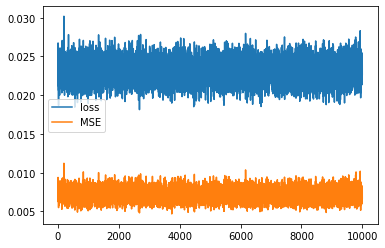

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


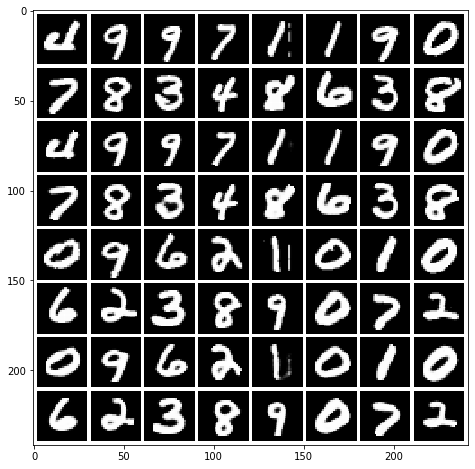

Mean squared dist: 0.007880653
epoch: 94 	 step:0 	 loss: 0.02001 	 reg loss: 0.001797
epoch: 94 	 step:100 	 loss: 0.02228 	 reg loss: 0.001834
epoch: 94 	 step:200 	 loss: 0.02122 	 reg loss: 0.001855
epoch: 94 	 step:300 	 loss: 0.02084 	 reg loss: 0.001752
epoch: 94 	 step:400 	 loss: 0.02364 	 reg loss: 0.001852
epoch: 94 	 step:500 	 loss: 0.02102 	 reg loss: 0.001739
epoch: 94 	 step:600 	 loss: 0.02418 	 reg loss: 0.001843
epoch: 94 	 step:700 	 loss: 0.02308 	 reg loss: 0.001841
epoch: 94 	 step:800 	 loss: 0.0245 	 reg loss: 0.001873
epoch: 94 	 step:900 	 loss: 0.02441 	 reg loss: 0.001855
epoch: 94 	 step:1000 	 loss: 0.0219 	 reg loss: 0.001804
epoch: 94 	 step:1100 	 loss: 0.02453 	 reg loss: 0.001838
epoch: 94 	 step:1200 	 loss: 0.02289 	 reg loss: 0.001804
epoch: 94 	 step:1300 	 loss: 0.02196 	 reg loss: 0.001793
epoch: 94 	 step:1400 	 loss: 0.02262 	 reg loss: 0.001794
epoch: 94 	 step:1500 	 loss: 0.02327 	 reg loss: 0.001794
epoch: 94 	 step:1600 	 loss: 0.02089 	

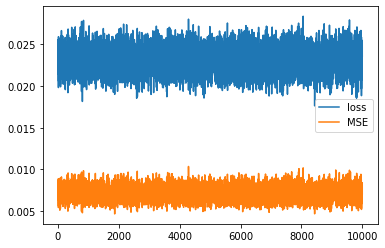

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


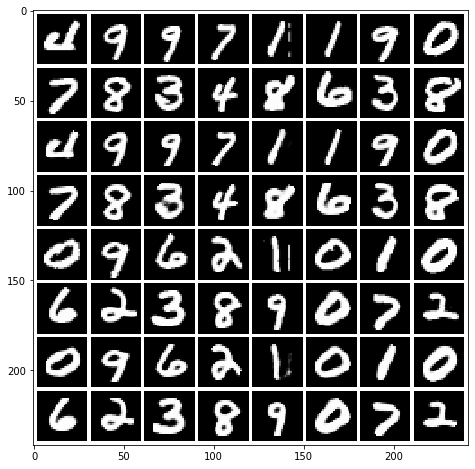

Mean squared dist: 0.00781684
epoch: 95 	 step:0 	 loss: 0.02307 	 reg loss: 0.0018
epoch: 95 	 step:100 	 loss: 0.02327 	 reg loss: 0.001843
epoch: 95 	 step:200 	 loss: 0.02425 	 reg loss: 0.001855
epoch: 95 	 step:300 	 loss: 0.01994 	 reg loss: 0.001798
epoch: 95 	 step:400 	 loss: 0.02462 	 reg loss: 0.001863
epoch: 95 	 step:500 	 loss: 0.02241 	 reg loss: 0.001797
epoch: 95 	 step:600 	 loss: 0.02439 	 reg loss: 0.001821
epoch: 95 	 step:700 	 loss: 0.02357 	 reg loss: 0.001838
epoch: 95 	 step:800 	 loss: 0.02245 	 reg loss: 0.001797
epoch: 95 	 step:900 	 loss: 0.02225 	 reg loss: 0.001807
epoch: 95 	 step:1000 	 loss: 0.02354 	 reg loss: 0.001832
epoch: 95 	 step:1100 	 loss: 0.0212 	 reg loss: 0.001777
epoch: 95 	 step:1200 	 loss: 0.02405 	 reg loss: 0.00185
epoch: 95 	 step:1300 	 loss: 0.02149 	 reg loss: 0.001763
epoch: 95 	 step:1400 	 loss: 0.0238 	 reg loss: 0.001887
epoch: 95 	 step:1500 	 loss: 0.02153 	 reg loss: 0.001813
epoch: 95 	 step:1600 	 loss: 0.02324 	 reg

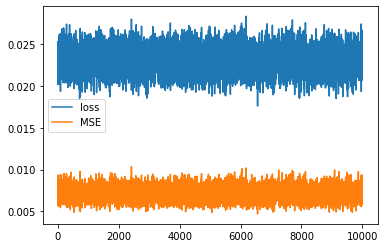

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


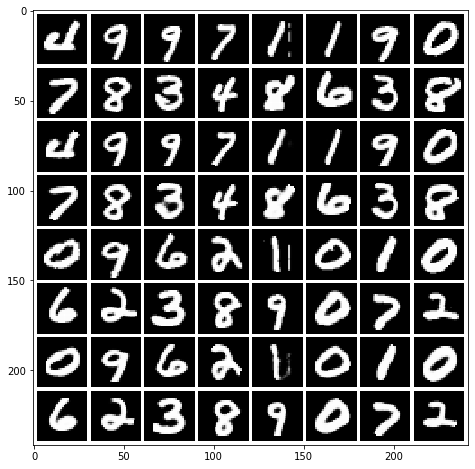

Mean squared dist: 0.007860003
epoch: 96 	 step:0 	 loss: 0.02495 	 reg loss: 0.001847
epoch: 96 	 step:100 	 loss: 0.02448 	 reg loss: 0.001835
epoch: 96 	 step:200 	 loss: 0.02403 	 reg loss: 0.001841
epoch: 96 	 step:300 	 loss: 0.02129 	 reg loss: 0.001814
epoch: 96 	 step:400 	 loss: 0.02289 	 reg loss: 0.001822
epoch: 96 	 step:500 	 loss: 0.02378 	 reg loss: 0.001823
epoch: 96 	 step:600 	 loss: 0.02414 	 reg loss: 0.00177
epoch: 96 	 step:700 	 loss: 0.02221 	 reg loss: 0.00176
epoch: 96 	 step:800 	 loss: 0.02267 	 reg loss: 0.001784
epoch: 96 	 step:900 	 loss: 0.02187 	 reg loss: 0.001777
epoch: 96 	 step:1000 	 loss: 0.02457 	 reg loss: 0.001845
epoch: 96 	 step:1100 	 loss: 0.02319 	 reg loss: 0.001847
epoch: 96 	 step:1200 	 loss: 0.02281 	 reg loss: 0.001826
epoch: 96 	 step:1300 	 loss: 0.02379 	 reg loss: 0.00186
epoch: 96 	 step:1400 	 loss: 0.02264 	 reg loss: 0.001779
epoch: 96 	 step:1500 	 loss: 0.02314 	 reg loss: 0.001824
epoch: 96 	 step:1600 	 loss: 0.02499 	 

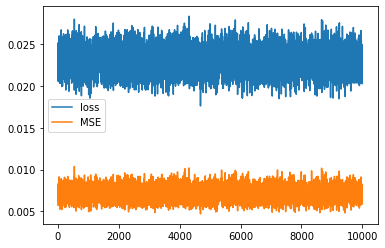

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


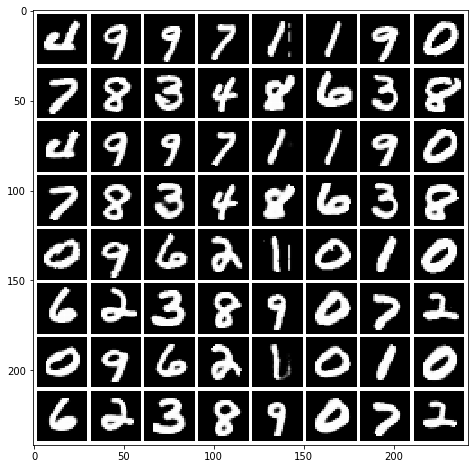

Mean squared dist: 0.0076967464
epoch: 97 	 step:0 	 loss: 0.0243 	 reg loss: 0.001829
epoch: 97 	 step:100 	 loss: 0.02154 	 reg loss: 0.00181
epoch: 97 	 step:200 	 loss: 0.02298 	 reg loss: 0.001827
epoch: 97 	 step:300 	 loss: 0.02249 	 reg loss: 0.001758
epoch: 97 	 step:400 	 loss: 0.02333 	 reg loss: 0.001836
epoch: 97 	 step:500 	 loss: 0.02531 	 reg loss: 0.001837
epoch: 97 	 step:600 	 loss: 0.0216 	 reg loss: 0.001801
epoch: 97 	 step:700 	 loss: 0.02686 	 reg loss: 0.001916
epoch: 97 	 step:800 	 loss: 0.02329 	 reg loss: 0.001824
epoch: 97 	 step:900 	 loss: 0.02249 	 reg loss: 0.001807
epoch: 97 	 step:1000 	 loss: 0.02169 	 reg loss: 0.001748
epoch: 97 	 step:1100 	 loss: 0.02354 	 reg loss: 0.001844
epoch: 97 	 step:1200 	 loss: 0.02478 	 reg loss: 0.001886
epoch: 97 	 step:1300 	 loss: 0.0238 	 reg loss: 0.001791
epoch: 97 	 step:1400 	 loss: 0.02484 	 reg loss: 0.001849
epoch: 97 	 step:1500 	 loss: 0.02221 	 reg loss: 0.001758
epoch: 97 	 step:1600 	 loss: 0.0224 	 r

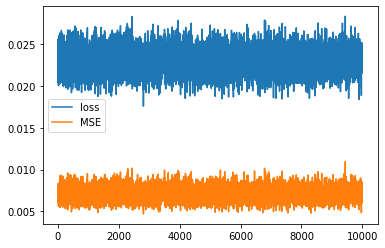

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


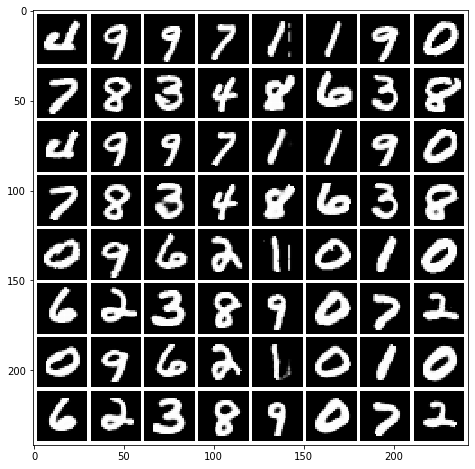

Mean squared dist: 0.007836331
epoch: 98 	 step:0 	 loss: 0.02454 	 reg loss: 0.001893
epoch: 98 	 step:100 	 loss: 0.02265 	 reg loss: 0.001824
epoch: 98 	 step:200 	 loss: 0.02009 	 reg loss: 0.00178
epoch: 98 	 step:300 	 loss: 0.02188 	 reg loss: 0.001829
epoch: 98 	 step:400 	 loss: 0.02254 	 reg loss: 0.001829
epoch: 98 	 step:500 	 loss: 0.02283 	 reg loss: 0.001808
epoch: 98 	 step:600 	 loss: 0.02269 	 reg loss: 0.001871
epoch: 98 	 step:700 	 loss: 0.02129 	 reg loss: 0.00178
epoch: 98 	 step:800 	 loss: 0.02416 	 reg loss: 0.001803
epoch: 98 	 step:900 	 loss: 0.02358 	 reg loss: 0.001788
epoch: 98 	 step:1000 	 loss: 0.02093 	 reg loss: 0.00171
epoch: 98 	 step:1100 	 loss: 0.02091 	 reg loss: 0.001769
epoch: 98 	 step:1200 	 loss: 0.02271 	 reg loss: 0.001768
epoch: 98 	 step:1300 	 loss: 0.02235 	 reg loss: 0.001811
epoch: 98 	 step:1400 	 loss: 0.02396 	 reg loss: 0.001884
epoch: 98 	 step:1500 	 loss: 0.02302 	 reg loss: 0.001846
epoch: 98 	 step:1600 	 loss: 0.02652 	 

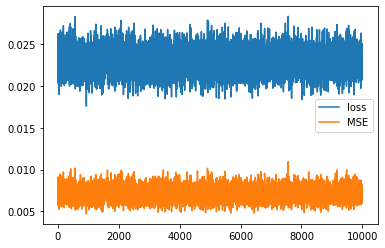

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


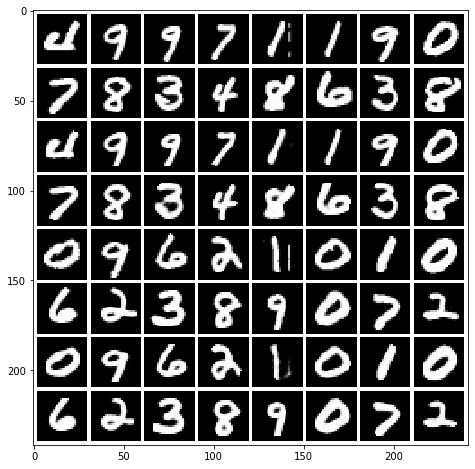

Mean squared dist: 0.007760284
epoch: 99 	 step:0 	 loss: 0.02175 	 reg loss: 0.001852
epoch: 99 	 step:100 	 loss: 0.02219 	 reg loss: 0.001796
epoch: 99 	 step:200 	 loss: 0.02395 	 reg loss: 0.001796
epoch: 99 	 step:300 	 loss: 0.02129 	 reg loss: 0.001815
epoch: 99 	 step:400 	 loss: 0.02533 	 reg loss: 0.001888
epoch: 99 	 step:500 	 loss: 0.0219 	 reg loss: 0.0018
epoch: 99 	 step:600 	 loss: 0.02198 	 reg loss: 0.001832
epoch: 99 	 step:700 	 loss: 0.0229 	 reg loss: 0.001816
epoch: 99 	 step:800 	 loss: 0.02321 	 reg loss: 0.001831
epoch: 99 	 step:900 	 loss: 0.02142 	 reg loss: 0.001832
epoch: 99 	 step:1000 	 loss: 0.02459 	 reg loss: 0.001867
epoch: 99 	 step:1100 	 loss: 0.02237 	 reg loss: 0.00185
epoch: 99 	 step:1200 	 loss: 0.02226 	 reg loss: 0.001796
epoch: 99 	 step:1300 	 loss: 0.02302 	 reg loss: 0.0018
epoch: 99 	 step:1400 	 loss: 0.02034 	 reg loss: 0.001747
epoch: 99 	 step:1500 	 loss: 0.02441 	 reg loss: 0.001806
epoch: 99 	 step:1600 	 loss: 0.02286 	 reg 

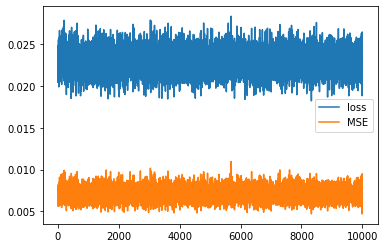

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


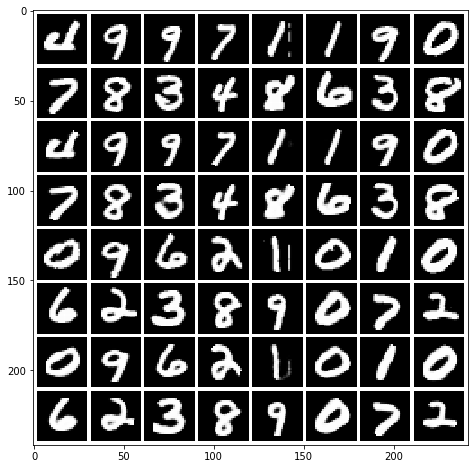

Mean squared dist: 0.0077523934
epoch: 100 	 step:0 	 loss: 0.02349 	 reg loss: 0.001825
epoch: 100 	 step:100 	 loss: 0.02406 	 reg loss: 0.001895
epoch: 100 	 step:200 	 loss: 0.02387 	 reg loss: 0.001868
epoch: 100 	 step:300 	 loss: 0.02307 	 reg loss: 0.001808
epoch: 100 	 step:400 	 loss: 0.0245 	 reg loss: 0.001853
epoch: 100 	 step:500 	 loss: 0.02328 	 reg loss: 0.001822
epoch: 100 	 step:600 	 loss: 0.0236 	 reg loss: 0.001828
epoch: 100 	 step:700 	 loss: 0.02319 	 reg loss: 0.00185
epoch: 100 	 step:800 	 loss: 0.02577 	 reg loss: 0.001863
epoch: 100 	 step:900 	 loss: 0.02192 	 reg loss: 0.001822
epoch: 100 	 step:1000 	 loss: 0.02281 	 reg loss: 0.001819
epoch: 100 	 step:1100 	 loss: 0.02439 	 reg loss: 0.001826
epoch: 100 	 step:1200 	 loss: 0.02501 	 reg loss: 0.001879
epoch: 100 	 step:1300 	 loss: 0.02062 	 reg loss: 0.001786
epoch: 100 	 step:1400 	 loss: 0.02496 	 reg loss: 0.001875
epoch: 100 	 step:1500 	 loss: 0.0204 	 reg loss: 0.00175
epoch: 100 	 step:1600 	 

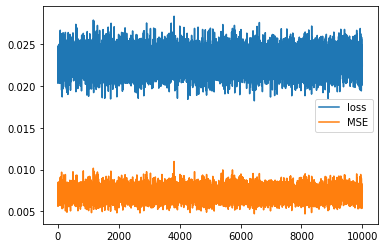

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


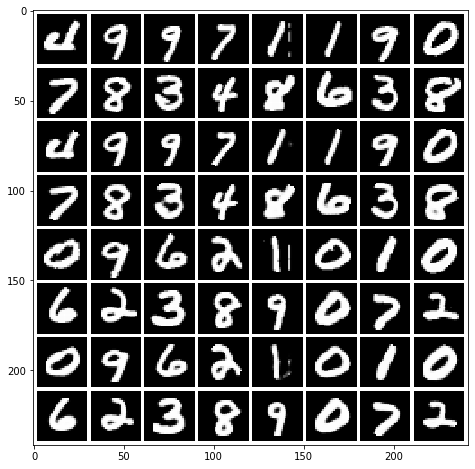

Mean squared dist: 0.0077695954


NameError: name 'history' is not defined

In [11]:
### TRAIN MODEL ###

num_epochs = 100

train_model(vae, optimizer, device, dataloader['train'], epochs=num_epochs);

model_weights = vae.state_dict().copy()
torch.save(model_weights, "../cache/vae/FC-VAE128Mnist_{0}_{0:04d}_{1}.sd".format(num_epochs, time.strftime("%Y%m%d_%H%M%S")))

In [198]:
### LOAD MODEL ###

latent_dim = 128
hidden_dim = 500

vae = models.SignalVAE(shape=imsize, latent_dim=latent_dim, hidden_dim=hidden_dim)
vae.load_state_dict(torch.load("../cache/vae/FC-VAE128Mnist_5.sd"));

Version 4


In [13]:
test_recon, test_images = test_model(vae, device, dataloader['test'])
print(test_images.shape)
print(test_recon.shape)

(8000, 1, 28, 28)
(8000, 1, 28, 28)


In [14]:
# Benchmark reconstruction #

benchmark(pred=test_recon[:1024], true=test_images[:1024], check_all=True)

Signal error:
  MSE: 0.006759726583055681, std: 0.004646183920000065
  MAE: 0.020738436615829414, std: 0.008565307989965241
  SSIM: 0.9455570258161414, std: 0.033358575786000856
  FASI-MSE: 0.0067789913943272495, std: 0.004691521340499318
  FASI-MAE: 0.02076073292937508, std: 0.008582783068451443
  COCO-MSE: 0.006759384989332352, std: 0.004645950222284762

Magnitude error:
  MSE Magnitude: 2.2427600390316855, std: 1.5085527240537704

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


## Evaluation for different VAE  (1024 samples)

| Nr | Size | alpha | gamma | epochs |  MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 784-500-500-20 | 1.0 | 1e-3 | 50 | 0.009365
| 2 | 784-500-500-20 | 2.0 | 1e-3 | 50 | 0.008110
| 3 | 784-500-500-128 | 2.0 | 1e-3 | 50 | 0.004890
| 4 | 784-500-500-784 | 2.0 | 1e-3 | 50 | 0.004292
| 6 | 784-500-500-128 | 1.0 | 1e-3 | 100 | 0.006760 | 0.02074 | 0.9456 | 0.006779 | 0.02076 | 0.006759 | 2.243


In [16]:
### Load model ###

fcnet = models.FCNet(imsize=imsize, h=2048)
fcnet.load_state_dict(torch.load("../cache/FC/FCNet2048MNIST_6.sd",
                      map_location={'cuda:1': device.__str__()}));

Version 0.4


In [18]:
### Hand Paper (adapted) ###

measurements = 300
A = (torch.randn(imsize[1] * imsize[2], measurements) / measurements).to(device)

def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft**2, -1) + 1e-16)
    return mags

def calc_meas(x):
    N = x.shape[0]
    C = x.shape[1]
    compressed = (x.view(N, C, -1) @ A).view(N, C, measurements)
    return torch.abs(compressed)

def vaeopt(sample_magnitudes, vae, device, measurement_fn=calc_mags,
           z_shape=(20, 1, 1), init_x=None, optim_lr=1e-1, max_steps=5000, max_loss=0.0):
    
    vae.to(device)
    vae.eval()
    
    N = sample_magnitudes.shape[0]
    
    if init_x is None:
        z = torch.randn((N, *z_shape), requires_grad=True, device=device)
    else:
        z = vae.encoder(init_x)[0].clone().detach().requires_grad_(True)
        
    optimizer = optim.Adam([z], lr=optim_lr)
    
    losses = []
    last_out = vae.decoder(z)
    
    for i in range(max_steps):
 
        magnitudes = measurement_fn(last_out)
        mse_all = torch.mean((magnitudes - sample_magnitudes) ** 2, dim=tuple(np.arange(len(magnitudes.shape))[1:]))
        loss = torch.sum(mse_all)
        
        if loss < max_loss:
            break
   
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        last_out = vae.decoder(z)

        losses.append(loss.detach().cpu().item())
        
    return last_out.detach(), losses, mse_all

Batch 1/32 finished
Batch 2/32 finished
Batch 3/32 finished
Batch 4/32 finished
Batch 5/32 finished
Batch 6/32 finished
Batch 7/32 finished
Batch 8/32 finished
Batch 9/32 finished
Batch 10/32 finished
Batch 11/32 finished
Batch 12/32 finished
Batch 13/32 finished
Batch 14/32 finished
Batch 15/32 finished
Batch 16/32 finished
Batch 17/32 finished
Batch 18/32 finished
Batch 19/32 finished
Batch 20/32 finished
Batch 21/32 finished
Batch 22/32 finished
Batch 23/32 finished
Batch 24/32 finished
Batch 25/32 finished
Batch 26/32 finished
Batch 27/32 finished
Batch 28/32 finished
Batch 29/32 finished
Batch 30/32 finished
Batch 31/32 finished
Batch 32/32 finished


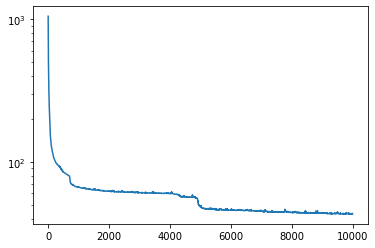

In [28]:
### Test one sample Fourier magnitudes random init + multiple restarts ###

num_batches = 32
batch_size = 32
max_steps = 10000
max_loss = 0.0
optim_lr = 1e-1
restarts = 3

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results = np.zeros((batch_size * num_batches, *imsize))
mse_all = np.full((batch_size * num_batches), np.inf)

for batch_i, batch in enumerate(dataloader['test']):
    test_sample = batch.to(device)
    test_magnitudes = calc_mags(test_sample)   
    out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()
    
    for r in range(restarts):
        cur_out_results, cur_loss, cur_mse_all = vaeopt(sample_magnitudes=test_magnitudes, vae=vae, device=device,
                                                        z_shape=(latent_dim, ), optim_lr=optim_lr, max_steps=max_steps,
                                                        max_loss=max_loss)
        cur_out_results = cur_out_results.cpu().numpy()

        for i in range(batch_size):
            mse = mse_all[batch_size * batch_i + i]
            if cur_mse_all[i] < mse:
                out_results[batch_size * batch_i + i] = cur_out_results[i]
                mse_all[batch_size * batch_i + i] = cur_mse_all[i]
    
    print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
    if batch_i + 1 >= num_batches:
        break

plt.semilogy(cur_loss)
plt.show()

In [29]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("/home/shared/phase-retrieval/test/VAE_MNIST/randomInit_original_6_1024.p", "wb"))
pickle.dump(out_results, open("/home/shared/phase-retrieval/test/VAE_MNIST/randomInit_6_1024.p", "wb"))

In [211]:
### LOAD RESULTS ###
import pickle

out_original = pickle.load(open("/home/shared/phase-retrieval/test/VAE_MNIST/randomInit_original_6.p", "rb"))
out_results = pickle.load(open("/home/shared/phase-retrieval/test/VAE_MNIST/randomInit_6.p", "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output under minimized magnitude distance:


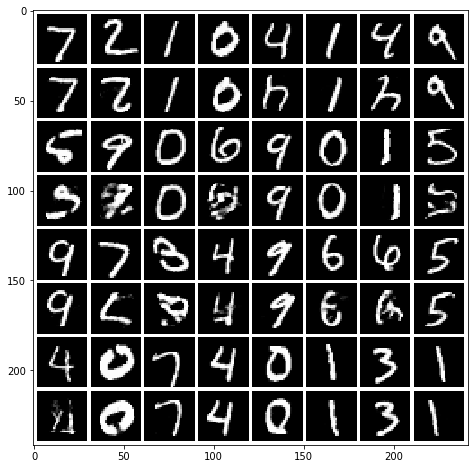

Signal error:
  MSE: 0.08031869191576183, std: 0.04470374042176834
  MAE: 0.11011152994197902, std: 0.05055792069995604
  SSIM: 0.4559733269584926, std: 0.25321423463131915
  FASI-MSE: 0.016790569375008974, std: 0.02703134855777324
  FASI-MAE: 0.03331214140233444, std: 0.038190199345409355
  COCO-MSE: 0.014819544249894356, std: 0.022838126268471464

Magnitude error:
  MSE Magnitude: 0.8510352140892523, std: 1.148013894469933

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


In [30]:
# Benchmark results

print("Output under minimized magnitude distance:")

to_plot = np.stack([out_original[:32].reshape(4, 8, 28, 28), 
                    out_results[:32].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
           
plot_grid(to_plot, figsize=(8, 8),
          file="../out/vae/mnist/{0}{1}.png".format('randomInit_6_1024_', time.strftime("%Y%m%d_%H%M%S")))

benchmark(pred=out_results, true=out_original, check_all=True)

## Test Fourier magnitudes random init (32 samples)

| Nr Type | iterations | restarts | lr | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 10000 | 3 | 1e-1 | 0.06869 | 0.09800 | 0.5129 | 0.02351 | 0.04574 | 0.02064 | 2.115
| 2 | 10000 | 3 | 1e-1 | 0.06672 | 0.09784 | 0.5321 | 0.01848 | 0.04226 | 0.01744 | 2.272
| 3 | 10000 | 3 | 1e-1 | 0.09310 | 0.1233 | 0.3938 | __0.01298__ | 0.02584 | __0.01238__ | 0.5381
| 4 | 10000 | 3 | 1e-1 | 0.08481 | 0.1141 | 0.4462 | 0.02640 | 0.04738 | 0.02187 | 1.366
| 6 | 10000 | 3 | 1e-1 | 0.06826 | 0.09716 | 0.5204 | 0.01188 | 0.02675 | 0.01116 | 0.7915


## Test Fourier magnitudes random init (1024 samples)

| Nr Type | iterations | restarts | lr | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 3 | 10000 | 3 | 1e-1 | 0.08481 | 0.1147 | 0.4385 | __0.01047__ | 0.02330 | __0.009258__ | 0.4541
| 6 | 10000 | 3 | 1e-1 | 0.08032 | 0.1101 | 0.4560 | 0.01679 | 0.03331 | 0.01482 | 0.8510


Batch 1/32 finished
Batch 2/32 finished
Batch 3/32 finished
Batch 4/32 finished
Batch 5/32 finished
Batch 6/32 finished
Batch 7/32 finished
Batch 8/32 finished
Batch 9/32 finished
Batch 10/32 finished
Batch 11/32 finished
Batch 12/32 finished
Batch 13/32 finished
Batch 14/32 finished
Batch 15/32 finished
Batch 16/32 finished
Batch 17/32 finished
Batch 18/32 finished
Batch 19/32 finished
Batch 20/32 finished
Batch 21/32 finished
Batch 22/32 finished
Batch 23/32 finished
Batch 24/32 finished
Batch 25/32 finished
Batch 26/32 finished
Batch 27/32 finished
Batch 28/32 finished
Batch 29/32 finished
Batch 30/32 finished
Batch 31/32 finished
Batch 32/32 finished


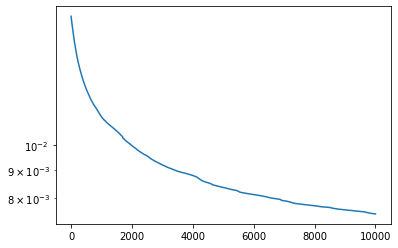

In [31]:
### Test one sample A measurements ###

num_batches = 32
batch_size = 32
max_steps = 10000
max_loss = 0.0
optim_lr= 1e-3
restarts = 3

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results = np.zeros((batch_size * num_batches, *imsize))
mse_all = np.full((batch_size * num_batches), np.inf)


for batch_i, batch in enumerate(dataloader['test']):
    test_sample = batch.to(device)
    test_measurements = calc_meas(test_sample)
    out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()

    for r in range(restarts):
        cur_out_results, cur_loss, cur_mse_all = vaeopt(sample_magnitudes=test_measurements, vae=vae, device=device,
                                                        measurement_fn=calc_meas, z_shape=(latent_dim, ),
                                                        optim_lr=optim_lr, max_steps=max_steps, max_loss=max_loss)
        cur_out_results = cur_out_results.cpu().numpy()
        
        for i in range(batch_size):
            mse = mse_all[batch_size * batch_i + i]
            if cur_mse_all[i] < mse:
                out_results[batch_size * batch_i + i] = cur_out_results[i]
                mse_all[batch_size * batch_i + i] = cur_mse_all[i]

    print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
    if batch_i + 1 >= num_batches:
        break

plt.semilogy(cur_loss)
plt.show()

In [32]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("/home/shared/phase-retrieval/test/VAE_MNIST/Ameas_original_6_1024.p", "wb"))
pickle.dump(out_results, open("/home/shared/phase-retrieval/test/VAE_MNIST/Ameas_6_1024.p", "wb"))

In [213]:
### LOAD RESULTS ###
import pickle

out_original = pickle.load(open("/home/shared/phase-retrieval/test/VAE_MNIST/Ameas_original_3_1024.p", "rb"))
out_results = pickle.load(open("/home/shared/phase-retrieval/test/VAE_MNIST/Ameas_3_1024.p", "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output under minimized magnitude distance:


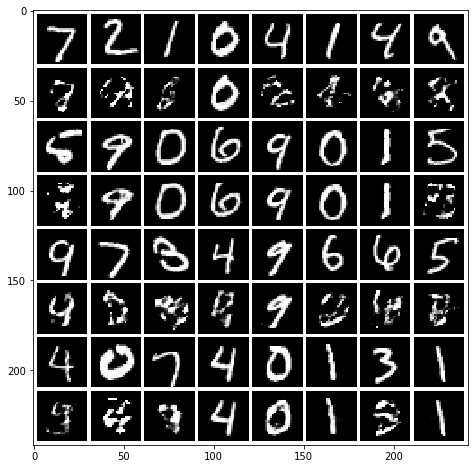

Signal error:
  MSE: 0.041688977666282254, std: 0.042515685176537574
  MAE: 0.0631508076168959, std: 0.05148374056734106
  SSIM: 0.6676078995413866, std: 0.2964529253850989
  FASI-MSE: 0.04539366577698266, std: 0.04765115566840448
  FASI-MAE: 0.0670717407429092, std: 0.05672033525362385
  COCO-MSE: 0.03931633815483068, std: 0.03896150935614368

Magnitude error:
  MSE Magnitude: 11.90409750150142, std: 11.98856495401881

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


In [33]:
print("Output under minimized magnitude distance:")

to_plot = np.stack([out_original[:32].reshape(4, 8, 28, 28), 
                    out_results[:32].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
           
plot_grid(to_plot, figsize=(8, 8),
          file="../out/vae/mnist/{0}{1}.png".format('Ameas_6_1024_', time.strftime("%Y%m%d_%H%M%S")))

benchmark(pred=out_results, true=out_original, check_all=True)

## Test A measurements random init (32 samples)

| Nr Type | iterations | restarts | lr | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 10000 | 3 | 1e-1 | 0.02342 | 0.04312 | 0.7958 | 0.02302 | 0.04258 | 0.02118 | 7.429
| 2 | 10000 | 3 | 1e-1 | 0.01330 | 0.03465 | 0.8724 | __0.01372__ | 0.03521 | __0.01266__ | 4.301
| 3 | 10000 | 3 | 1e-1 | 0.03041 | 0.05080 | 0.7355 | 0.03272 | 0.05349 | 0.02796 | 8.491
| 4 | 10000 | 3 | 1e-1 | 0.04132 | 0.06473 | 0.6605 | 0.04693 | 0.07081 | 0.04006 | 11.93
| 6 | 10000 | 3 | 1e-1 | 0.03812 | 0.06044 | 0.6532 | 0.03765 | 0.05997 | 0.03494 | 10.64


## Test A measurements random init (1024 samples)

| Nr Type | iterations | restarts | lr | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 3 | 10000 | 3 | 1e-1 | 0.01627 | 0.03226 | 0.8580 | 0.01690 | 0.03298 | 0.01507 | 4.466
| 6 | 10000 | 3 | 1e-1 | 0.04169 | 0.06315 | 0.6676 | 0.04539 | 0.06707 | 0.03932 | 11.90


Batch 1/32 finished
Batch 2/32 finished
Batch 3/32 finished
Batch 4/32 finished
Batch 5/32 finished
Batch 6/32 finished
Batch 7/32 finished
Batch 8/32 finished
Batch 9/32 finished
Batch 10/32 finished
Batch 11/32 finished
Batch 12/32 finished
Batch 13/32 finished
Batch 14/32 finished
Batch 15/32 finished
Batch 16/32 finished
Batch 17/32 finished
Batch 18/32 finished
Batch 19/32 finished
Batch 20/32 finished
Batch 21/32 finished
Batch 22/32 finished
Batch 23/32 finished
Batch 24/32 finished
Batch 25/32 finished
Batch 26/32 finished
Batch 27/32 finished
Batch 28/32 finished
Batch 29/32 finished
Batch 30/32 finished
Batch 31/32 finished
Batch 32/32 finished


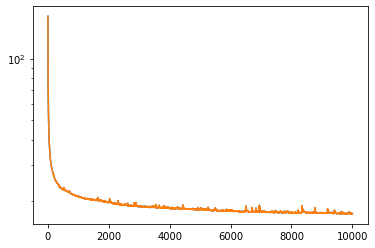

In [34]:
### Test one sample Fourier magnitudes with end-to-end init ###

num_batches = 32
batch_size = 32
max_steps = 10000
max_loss = 0.0
optim_lr= 1e-1

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results = np.zeros((batch_size * num_batches, *imsize))
mse_all = np.full((batch_size * num_batches), np.inf)

for batch_i, batch in enumerate(dataloader['test']):
    test_sample = batch.to(device)
    test_magnitudes = calc_mags(test_sample)
    out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()

    fcnet.to(device)
    fcnet.eval()
    init_x = fcnet(test_magnitudes).detach()

    cur_out_results, cur_loss, cur_mse_all = vaeopt(sample_magnitudes=test_magnitudes, vae=vae, device=device,
                                                    init_x=init_x, z_shape=(latent_dim, ), optim_lr=optim_lr,
                                                    max_steps=max_steps, max_loss=max_loss)
    cur_out_results = cur_out_results.cpu().numpy()
    
    out_results[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_out_results
    mse_all[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_mse_all.detach().cpu().numpy()
    
    print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
    if batch_i + 1 >= num_batches:
        break

plt.plot(cur_loss)
plt.semilogy(cur_loss)
plt.show()

In [35]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("/home/shared/phase-retrieval/test/VAE_MNIST/e2eInit_original_6_1024.p", "wb"))
pickle.dump(out_results, open("/home/shared/phase-retrieval/test/VAE_MNIST/e2eInit_6_1024.p", "wb"))

In [219]:
### LOAD RESULTS ###
import pickle

out_original = pickle.load(open("/home/shared/phase-retrieval/test/VAE_MNIST/e2eInit_original_3_1024.p", "rb"))
out_results = pickle.load(open("/home/shared/phase-retrieval/test/VAE_MNIST/e2eInit_3_1024.p", "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output under minimized magnitude distance:


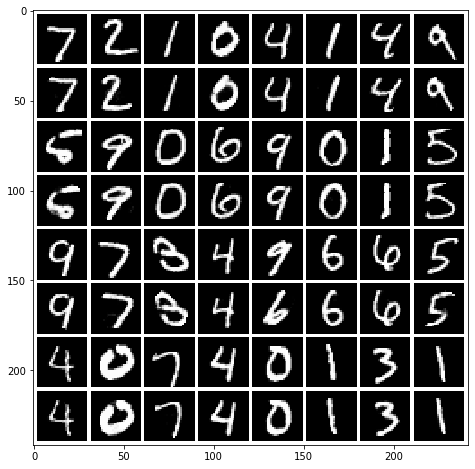

Signal error:
  MSE: 0.030286147258441195, std: 0.02900544580819682
  MAE: 0.052246515069052715, std: 0.037912793730072024
  SSIM: 0.7701555096567315, std: 0.19791287872166466
  FASI-MSE: 0.006401241633204781, std: 0.010683111935127226
  FASI-MAE: 0.0194095925145739, std: 0.01750645947481572
  COCO-MSE: 0.005787309135534688, std: 0.008226969985031415

Magnitude error:
  MSE Magnitude: 0.5341784610106803, std: 0.656365632021257

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


In [36]:
print("Output under minimized magnitude distance:")

to_plot = np.stack([out_original[:32].reshape(4, 8, 28, 28), 
                    out_results[:32].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
           
plot_grid(to_plot, figsize=(8, 8),
          file="../out/vae/mnist/{0}{1}.png".format('e2eInit_6_1024_', time.strftime("%Y%m%d_%H%M%S")))

benchmark(pred=out_results, true=out_original, check_all=True)

## Test Fourier magnitudes end-to-end init (32 samples)

| Nr Type | iterations | lr | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 10000 | 1e-1 | 0.02536 | 0.04709 | 0.8099 | 0.009244 | 0.02731 | 0.008945 | 1.411
| 2 | 10000 | 1e-1 | 0.02082 | 0.04451 | 0.8289 | 0.009645 | 0.03021 | 0.009441 | 1.534
| 3 | 10000 | 1e-1 | 0.01563 | 0.03029 | 0.8826 | __0.001309__ | 0.009306 | __0.001237__ | 0.1314
| 4 | 10000 | 1e-1 | 0.01343 | 0.03024 | 0.8989 | 0.003808 | 0.01778 | 0.003599 | 0.4975
| 6 | 10000 | 1e-1 | 0.03106 | 0.05328 | 0.7688 | 0.005794 | 0.01874 | 0.005147 | 0.54334


## Test Fourier magnitudes end-to-end init (1024 samples)

| Nr Type | iterations | restarts | lr | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 3 | 10000 | 3 | 1e-1 | 0.02089 | 0.03819 | 0.8402 | 0.002059 | 0.01034 | 0.001945 | 0.1583
| 6 | 10000 | 3 | 1e-1 | 0.03029 | 0.05225 | 0.7701 | 0.006401 | 0.01941 | 0.005787 | 0.5341
